In [1]:
# PPO + GPT2, 中文情感分析

import time
import random

import torch
from rich import print
from tqdm import tqdm
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from trl.gpt2 import GPT2HeadWithValueModel
from trl.ppo import PPOTrainer

from iTrainingLogger import iSummaryWriter

In [2]:
# !pip install rich

In [3]:
writer = iSummaryWriter(log_path = './logs', log_name = 'PPO-Sentiment-Zh')
config = {
    'model_name': 'uer/gpt2-chinese-cluecorpussmall',
    'steps': 20000,
    'batch_size': 32,
    'forward_batch_size': 16,
    'ppo_epoch': 4,
    'lr': 5e-5,
    'init_kl_ceof': 0.2,
    'target': 6,
    'horizon': 10000,
    'gamma': 1,
    'lam': 0.95,
    'cliprange': .2,
    'cliprange_value': .2,
    'vf_coef': .1,
    'gen_len': 16
}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_device = 0 if torch.cuda.is_available() else -1

In [5]:
prompts = [
    '刚收到货，感觉',
    '这部电影',
    '说实话，真的很',
    '这次购物总的来说体验很'
]

In [6]:
# 情感分类模型
senti_tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-jd-binary-chinese')
senti_model = AutoModelForSequenceClassification.from_pretrained('uer/roberta-base-finetuned-jd-binary-chinese')
sentiment_pipe = pipeline('sentiment-analysis', model = senti_model, tokenizer = senti_tokenizer, device = pipe_device)

In [7]:
# 文本生成模型
gpt2_model = GPT2HeadWithValueModel.from_pretrained(config['model_name'])
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(config['model_name'])
gpt2_tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
gpt2_tokenizer.eos_token = gpt2_tokenizer.pad_token
gpt2_model.to(device)
gpt2_model_ref.to(device)

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at uer/gpt2-chinese-cluecorpussmall and are newly initialized: ['v_head.summary.weight', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at uer/gpt2-chinese-cluecorpussmall and are newly initialized: ['v_head.summary.weight', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2HeadWithValueModel(
  (transformer): GPT2Model(
    (wte): Embedding(21128, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropou

In [9]:
gen_kwargs = {
    'min_length': -1,
    'top_k': 0.0,
    'top_p': 1.0,
    'do_sample': True,
    'pad_token_id': gpt2_tokenizer.eos_token_id
}

  0%|                                                  | 0/625 [00:00<?, ?it/s]

epoch 0 mean-reward: 0.7850995659828186

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很洽 撒 所 以 不 担 心 有 弄 虚 作 假 产 品 没 有

2. 刚收到货，感觉麦 不 错 ， 粥 的 不 好 喝 ， 实 物 和 别 家 的

3. 刚收到货，感觉感 觉 很 好 。 两 张 都 是 金 黄 色 的 ， 感 觉

4. 这次购物总的来说体验很洽 撒 所 以 不 担 心 有 弄 虚 作 假 产 品 没 有

5. 这次购物总的来说体验很与 值 [SEP] [SEP] 还 没 有 看 后 来 再 买 一 本 送 朋

  0%|                                        | 1/625 [00:14<2:28:18, 14.26s/it]

epoch 1 mean-reward: 0.8227102756500244

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉奶 茶 和 麦 旋 风 还 不 如 k ~ [SEP] 爱 不 错 的

2. 这次购物总的来说体验很容 值 得 赞 一 下 [SEP] 容 值 得 一 提 [SEP] 容 值 得

3. 刚收到货，感觉来 很 实 惠 。 外 观 性 能 都 很 好 ， 预 装 也

4. 刚收到货，感觉奶 茶 和 麦 旋 风 还 不 如 k ~ [SEP] 爱 不 错 的

5. 这部电影来 自 于 英 雄 电 影 和 乔 治 · 奥 威 尔 的 《

  0%|▏                                       | 2/625 [00:25<2:10:43, 12.59s/it]

epoch 2 mean-reward: 0.8318698406219482

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很常 识 aac 的 质 量 好 得 很 果 份 量 都 很 足

2. 这部电影阿 格 林 是 10 年 前 自 己 才 开 始 写 的 ， 但

3. 这部电影" h " 中 ， 她 将 错 过 。 这 个 青 年 虽 然

4. 这部电影首 次 披 露 了 14 纳 米 单 晶 。 其 中 45 度 角

5. 这部电影3 月 13 日 很 好 。 2014 年 4 月 7 日 中 日 合

  0%|▏                                       | 3/625 [00:36<2:04:28, 12.01s/it]

epoch 3 mean-reward: 0.7003593444824219

Random Sample 5 text(s) of model output:

1. 这部电影刘 青 云 的 真 正 巅 峰 时 期 ， 不 过 是 他 曾

2. 说实话，真的很俗 俗 翻 译 如 果 你 觉 得 我 是 逃 顶 了 都 可

3. 说实话，真的很俗 俗 么 的 说 yuan 可 是 是 个 老 字 号 ， 每

4. 这部电影吴 宇 森 导 演 杨 安 奇 选 了 李 安 ， 当 年 杨

5. 这次购物总的来说体验很俗 俗 我 用 来 打 tf12 是 很 的 俗 俗 但 是 确

  1%|▎                                       | 4/625 [00:48<2:00:59, 11.69s/it]

epoch 4 mean-reward: 0.8336919546127319

Random Sample 5 text(s) of model output:

1. 说实话，真的很俗 的 好 吃 ， 不 过 是 醉 翁 之 意 ， 老 是 能

2. 这部电影制 作 是 有 意 要 赶 人 进 去 的 还 是 贵 的 微

3. 这次购物总的来说体验很俗 俗 科 普 的 英 国 生 产 但 是 相 约 德 国 版

4. 刚收到货，感觉超 炫 的 化 学 版 本 。 世 界 上 最 有 用 的 手

5. 刚收到货，感觉我 地 日 本 也 有 啦 ！ 只 需 要 14 年 就 可 以

  1%|▎                                       | 5/625 [00:59<1:58:58, 11.51s/it]

epoch 5 mean-reward: 0.6398500800132751

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很俗 版 本 最 后 煮 宝 装 上 去 后 可 是 只 有 像

2. 刚收到货，感觉家 长 可 以 用 这 几 个 施 行 密 集 约 束 ， 我

3. 说实话，真的很俗 作 者 。 红 柳 夹 克 套 鞋 连 衣 裙 ， 和 银

4. 刚收到货，感觉除 了 蠢 货 ， 最 会 着 装 时 候 为 了 装 饰 品

5. 刚收到货，感觉一 分 钱 一 分 货 ， 现 在 一 分 钱 一 分 货 把

  1%|▍                                       | 6/625 [01:10<1:57:32, 11.39s/it]

epoch 6 mean-reward: 0.7207111716270447

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很俗 爆 发 ， 很 有 用 不 过 在 我 这 方 面 要 说

2. 这次购物总的来说体验很俗 说 的 更 不 错 的 [SEP] 但 是 买 回 来 并 不 是

3. 刚收到货，感觉路 过 藏 品 ， 请 各 位 藏 品 发 现 这 人 跟 我

4. 刚收到货，感觉和 张 扬 的 话 ， 诠 释 了 中 国 的 至 今 流 行

5. 刚收到货，感觉掩 耳 曼 就 算 了 ， 质 量 挺 好 ， 码 较 长 ，

  1%|▍                                       | 7/625 [01:21<1:57:16, 11.39s/it]

epoch 7 mean-reward: 0.7553087472915649

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉刚 开 始 是 的 准 的 ， 刚 开 始 不 是 的 ， 刚

2. 这部电影的 时 刻 我 们 終 究 不 是 我 們 生 的 ， 但 是

3. 刚收到货，感觉刚 进 来 就 纷 纷 红 了 ， 我 只 想 买 什 么 都

4. 这次购物总的来说体验很翰 的 都 赞 不 错 的 可 是 上 去 就 不 想 用 了

5. 这部电影上 来 的 当 年 世 界 领 袖 ， 不 过 先 不 说 了

  1%|▌                                       | 8/625 [01:33<1:56:37, 11.34s/it]

epoch 8 mean-reward: 0.7472963333129883

Random Sample 5 text(s) of model output:

1. 说实话，真的很相 形 为 实 ， 不 喜 欢 王 宝 强 的 是 真 不 想

2. 这次购物总的来说体验很不 是 不 想 买 的 那 种 了 但 是 也 是 比 较 喜

3. 这部电影还 算 不 错 应 该 挺 久 不 过 焦 乐 竟 然 不 用

4. 刚收到货，感觉还 是 北 京 的 好 点 ， 用 过 一 次 的 说 一 下

5. 这部电影确 实 不 怎 么 喜 欢 一 点 了 但 是 确 实 是 很

  1%|▌                                       | 9/625 [01:44<1:56:21, 11.33s/it]

epoch 9 mean-reward: 0.3335126042366028

Random Sample 5 text(s) of model output:

1. 说实话，真的很坑 爹 的 。 这 个 ， 大 师 级 别 的 怎 么 样 ，

2. 说实话，真的很坑 ， 这 个 我 不 想 去 用 ， 用 来 说 了 ， 就

3. 说实话，真的很坑 人 ， 坑 人 是 没 话 可 说 ， 坑 人 s 的 我

4. 刚收到货，感觉中 国 风 格 的 用 来 装 饰 的 ， 但 是 对 来 电

5. 这部电影很 坑 坑 坑 坑 坑 坑 坑 坑 坑 坑 坑 坑 坑 坑 坑

  2%|▌                                      | 10/625 [01:55<1:56:11, 11.34s/it]D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\transformers\pipelines\base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


epoch 10 mean-reward: 0.6320846080780029

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉中 虾 米 的 英 文 字 版 本 是 什 么 样 的 理 想

2. 这次购物总的来说体验很还 不 错 别 人 都 说 这 次 购 物 的 可 是 如 果

3. 这部电影不 怎 么 样 的 人 物 但 是 看 这 部 电 影 开 头

4. 这次购物总的来说体验很不 怎 么 就 是 来 一 个 书 法 师 傅 在 博 客 上

5. 说实话，真的很不 错 ， 谁 家 不 是 没 话 的 了 ， 这 家 店 得

  2%|▋                                      | 11/625 [02:07<1:56:15, 11.36s/it]

epoch 11 mean-reward: 0.7941609025001526

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很以 为 什 么 样 的 显 卡 咱 人 大 的 知 识 经 济

2. 刚收到货，感觉有 点 点 指 示 还 有 其 它 一 个 高 级 别 上 来

3. 这部电影不 错 从 来 没 有 看 过 星 级 的 人 物 但 是 这

4. 刚收到货，感觉有 点 市 面 上 的 烤 功 ， 但 是 要 说 是 这 家

5. 刚收到货，感觉有 点 点 喜 欢 ， 但 是 没 有 什 么 是 推 荐 的

  2%|▋                                      | 12/625 [02:18<1:56:40, 11.42s/it]

epoch 12 mean-reward: 0.725119948387146

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉不 经 测 试 ， 只 有 有 趣 的 专 栏 ， 可 是 每

2. 刚收到货，感觉狠 不 错 可 是 是 比 较 喜 欢 点 的 但 是 是 平

3. 刚收到货，感觉收 到 不 是 说 了 。 但 是 每 天 看 这 两 天 和

4. 刚收到货，感觉刚 刚 好 用 的 文 章 ， 感 觉 我 刚 刚 想 要 的

5. 这次购物总的来说体验很这 当 年 的 错 别 字 在 海 边 的 网 站 点 点 的

  2%|▊                                      | 13/625 [02:30<1:57:13, 11.49s/it]

epoch 13 mean-reward: 0.861705482006073

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很我 是 一 个 既 喜 欢 的 尤 其 是 想 要 的 东 西

2. 这次购物总的来说体验很叫 我 皮 衣 和 鼠 标 我 是 要 求 别 人 也 要 求

3. 说实话，真的很我 朋 友 喜 欢 的 这 一 天 想 要 的 东 西 我 们

4. 刚收到货，感觉这 看 到 兰 州 的 一 些 东 西 ， 但 是 说 说 我

5. 这部电影临 后 也 有 好 几 个 问 题 但 是 看 到 文 章 里

  2%|▊                                      | 14/625 [02:41<1:56:36, 11.45s/it]

epoch 14 mean-reward: 0.779145359992981

Random Sample 5 text(s) of model output:

1. 说实话，真的很说 便 85 里 面 有 个 游 戏 一 直 想 要 的 东 西

2. 这部电影不 错 乐 小 建 所 和 这 部 电 视 胜 的 可 以 说

3. 说实话，真的很超 过 我 爷 爷 说 话 的 台 词 真 站 着 你 们 姑

4. 刚收到货，感觉人 性 化 的 软 件 app ， 点 的 时 间 短 而 有 点

5. 刚收到货，感觉点 套 餐 是 基 本 齐 举 ， 而 且 我 之 前 见 过

  2%|▉                                      | 15/625 [02:53<1:56:29, 11.46s/it]

epoch 15 mean-reward: 0.7156638503074646

Random Sample 5 text(s) of model output:

1. 这部电影在 剧 情 ， 路 人 甲 ， （ 但 是 还 可 以 聊 天

2. 说实话，真的很在 这 看 书 5 日 ， 一 个 阴 天 晚 上 ， 去 学

3. 说实话，真的很在 这 看 书 5 日 ， 一 个 阴 天 晚 上 ， 去 学

4. 说实话，真的很说 的 泽 7 号 ， 反 正 我 去 了 几 次 ， 可 以

5. 说实话，真的很「 [UNK] 这 个 环 境 真 难 得 ， 公 园 ， 有 几 个

  3%|▉                                      | 16/625 [03:04<1:56:35, 11.49s/it]

epoch 16 mean-reward: 0.7835301160812378

Random Sample 5 text(s) of model output:

1. 说实话，真的很非 常 恶 毒 ， 啊 ， 百 姓 大 地 ， 非 常 喜 欢

2. 这部电影等 3 个 人 跟 男 朋 友 拍 了 几 个 微 博 给 他

3. 这部电影都 是 介 绍 他 们 的 快 乐 但 是 他 们 跪 着 为

4. 刚收到货，感觉不 错 可 以 脑 死 。 里 面 也 有 其 他 的 角 色

5. 这部电影延 续 了 我 买 这 部 电 视 剧 服 装 cosplay 但 是 这

  3%|█                                      | 17/625 [03:16<1:55:58, 11.44s/it]

epoch 17 mean-reward: 0.7230725884437561

Random Sample 5 text(s) of model output:

1. 说实话，真的很道 地 ， 麻 到 不 可 以 来 一 次 完 全 没 意 思

2. 这次购物总的来说体验很刚 踢 踏 ， 还 有 那 两 年 在 校 的 期 间 ， 每

3. 这部电影蜗 居 ， 但 是 自 己 的 喜 欢 的 女 生 走 道 ，

4. 说实话，真的很点 ， 真 正 的 环 境 很 平 庸 ， 不 用 找 个 几

5. 这次购物总的来说体验很就 是 传 说 中 那 座 城 市 的 每 天 / 每 次 出

  3%|█                                      | 18/625 [03:27<1:55:26, 11.41s/it]

epoch 18 mean-reward: 0.7579320669174194

Random Sample 5 text(s) of model output:

1. 这部电影由 张 杰 伦 的 创 作 人 员 为 他 提 出 了 几 个

2. 这部电影以 同 属 于 作 为 教 科 书 籍 来 对 章 节 的 各

3. 刚收到货，感觉撇 咯 收 的 是 环 境 的 设 计 师 ， 她 们 是 首

4. 这部电影估 计 从 一 千 个 小 小 的 故 事 中 找 到 了 两

5. 说实话，真的很印 盖 的 菜 品 ， 其 他 人 7 个 菜 盘 中 很 喜

  3%|█▏                                     | 19/625 [03:38<1:55:03, 11.39s/it]

epoch 19 mean-reward: 0.741397500038147

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉其 他 人 离 开 也 不 错 呢 ！ 全 年 几 乎 没 人

2. 这部电影艺 术 的 反 正 我 看 了 都 是 反 正 反 正 反 正

3. 这部电影在 此 是 由 于 画 的 有 几 调 紧 张 的 调 题 ，

4. 刚收到货，感觉其 他 人 离 开 也 不 错 呢 ！ 全 年 几 乎 没 人

5. 这次购物总的来说体验很是 自 己 唯 一 见 过 特 别 喜 欢 的 公 司 噢 ~

  3%|█▏                                     | 20/625 [03:50<1:55:16, 11.43s/it]

epoch 20 mean-reward: 0.6045796871185303

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很确 是 货 源 有 几 人 景 仰 一 些 所 谓 的 所 谓

2. 刚收到货，感觉坐 的 牛 坐 ， 坐 的 小 麂 子 ， 坐 的 小 沙 地

3. 刚收到货，感觉坐 的 牛 坐 ， 坐 的 小 麂 子 ， 坐 的 小 沙 地

4. 这次购物总的来说体验很如 果 是 不 喜 欢 请 气 管 枪 人 们 把 那 些 严

5. 刚收到货，感觉若 是 狭 窄 ， 酸 酸 的 吃 一 小 麻 辣 涮 一 小

  3%|█▎                                     | 21/625 [04:01<1:54:49, 11.41s/it]

epoch 21 mean-reward: 0.714931845664978

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉据 一 些 保 密 单 件 ， 有 什 么 自 己 的 能 判

2. 说实话，真的很好 吃 ， 最 喜 欢 ， 因 为 我 们 几 天 课 上 ，

3. 这部电影好 弱 还 是 说 了 了 不 少 的 小 会 议 程 序 ，

4. 这次购物总的来说体验很试 了 解 了 这 一 词 叫 当 天 的 首 次 考 试 年

5. 这次购物总的来说体验很还 是 可 以 用 的 交 通 工 具 这 也 是 小 天 天

  4%|█▎                                     | 22/625 [04:13<1:54:20, 11.38s/it]

epoch 22 mean-reward: 0.7160509824752808

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很一 般 的 可 是 不 用 之 前 的 人 看 看 我 们 猥

2. 说实话，真的很互 联 互 通 ， 有 包 含 的 各 种 服 装 备 ， 你

3. 说实话，真的很他 们 的 三 套 好 处 ， 吃 倒 ， 就 是 ， 一 般

4. 这部电影随 后 霍 城 的 房 子 是 深 圳 这 地 名 符 其 实

5. 这次购物总的来说体验很老 是 帮 你 们 年 轻 ， 我 们 未 曾 以 前 以 为

  4%|█▍                                     | 23/625 [04:24<1:53:58, 11.36s/it]

epoch 23 mean-reward: 0.8229591846466064

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉没 有 那 么 烦 躁 ， ， 的 的 的 不 用 人 学 习

2. 刚收到货，感觉吃 的 口 唇 琅 琅 的 看 着 楼 上 没 人 ， 很 喜

3. 这部电影若 不 任 何 人 都 适 用 ， 那 不 是 个 很 不 喜

4. 刚收到货，感觉医 疗 行 业 的 医 疗 企 业 之 所 以 为 ， 医 疗

5. 这部电影一 般 ， 不 用 回 顾 ， 不 用 依 旧 ， 我 一 般

  4%|█▍                                     | 24/625 [04:35<1:53:35, 11.34s/it]

epoch 24 mean-reward: 0.6279193162918091

Random Sample 5 text(s) of model output:

1. 说实话，真的很道 有 时 去 江 边 ， 没 吃 东 ， n 个 东 西 ，

2. 这次购物总的来说体验很我 是 看 起 没 人 在 网 站 上 面 有 一 些 和 实

3. 刚收到货，感觉我 为 回 切 过 说 的 投 资 ， 有 几 人 可 以 作

4. 说实话，真的很痔 的 那 医 生 问 题 不 帮 有 流 溢 ， 果 木 站

5. 这次购物总的来说体验很虽 然 看 了 别 人 的 过 往 的 的 的 的 观 察 的

  4%|█▌                                     | 25/625 [04:47<1:53:24, 11.34s/it]

epoch 25 mean-reward: 0.660679280757904

Random Sample 5 text(s) of model output:

1. 这部电影那 有 写 到 发 货 到 那 ， 有 一 些 关 于 、 还

2. 说实话，真的很， 小 ， ， 我 观 察 ， ， 能 做 到 的 ， ， ，

3. 这部电影有 什 没 有 什 么 用 反 正 就 是 可 以 的 的 了

4. 刚收到货，感觉mike 的 外 观 ， 现 在 在 写 所 从 事 的 的 的 的

5. 这部电影有 什 没 有 什 么 用 反 正 就 是 可 以 的 的 了

  4%|█▌                                     | 26/625 [04:58<1:53:11, 11.34s/it]

epoch 26 mean-reward: 0.6259654760360718

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很地 ， 就 是 颗 跑 在 别 人 的 车 上 跑 ， 上 面

2. 说实话，真的很呃 没 什 么 么 吧 ， 说 是 阔 ， 我 们 这 人 3

3. 这次购物总的来说体验很其 中 什 么 活 动 已 没 话 浅 级 那 有 什 么 好

4. 这部电影就 在 上 一 天 ， 但 是 ， 所 以 冬 天 的 时 间

5. 刚收到货，感觉有 什 么 么 么 气 味 道 。 据 村 的 人 ， 从 小

  4%|█▋                                     | 27/625 [05:09<1:53:11, 11.36s/it]

epoch 27 mean-reward: 0.6796886920928955

Random Sample 5 text(s) of model output:

1. 这部电影干 净 还 好 p2p ， 关 键 是 教 练 ， 如 果 是 教

2. 这次购物总的来说体验很买 了 内 存 但 是 在 变 化 这 时 间 该 季 度 日

3. 刚收到货，感觉对 比 较 喜 欢 的 因 为 ， 当 天 的 时 间 直 到

4. 刚收到货，感觉便 ， 它 们 颜 色 。 [SEP] 发 觉 ， 证 明 ， 你 当

5. 说实话，真的很这 部 小 布 厂 ， 一 般 ， 为 什 么 ？ 每 话 的

  4%|█▋                                     | 28/625 [05:21<1:52:55, 11.35s/it]

epoch 28 mean-reward: 0.7372338771820068

Random Sample 5 text(s) of model output:

1. 这部电影很 好 找 ， 总 体 放 在 中 国 的 。 china cup ， 以

2. 说实话，真的很， 了 ， 不 说 了 。 结 果 天 天 常 板 结 ， 日

3. 这部电影rt 冷 26 日 ， rt 体 例 是 到 底 铁 路 ， 在 闽

4. 这部电影rt 冷 26 日 ， rt 体 例 是 到 底 铁 路 ， 在 闽

5. 这次购物总的来说体验很[UNK] 虽 然 让 卡 在 一 一 次 机 构 说 的 下 去 ，

  5%|█▊                                     | 29/625 [05:32<1:52:46, 11.35s/it]

epoch 29 mean-reward: 0.7700345516204834

Random Sample 5 text(s) of model output:

1. 说实话，真的很， 不 [UNK] 。 因 为 人 人 啥 的 难 是 ， 因 为 不

2. 刚收到货，感觉就 是 既 有 借 以 这 个 ， 还 会 把 那 温 度 真

3. 刚收到货，感觉没 多 ， 还 给 可 以 的 ， 要 是 在 里 面 了 ，

4. 刚收到货，感觉是 ， 因 为 这 几 年 消 费 ， 等 离 开 爱 尔 沙

5. 这次购物总的来说体验很， 就 是 找 了 价 格 ， 然 比 较 喜 欢 的 一 些

  5%|█▊                                     | 30/625 [05:43<1:52:30, 11.35s/it]

epoch 30 mean-reward: 0.7131690979003906

Random Sample 5 text(s) of model output:

1. 说实话，真的很， 不 用 去 广 告 ， 好 多 来 撮 店 面 ， 那 的

2. 这部电影发 时 人 出 去 后 井 的 是 本 。 所 以 归 还 了

3. 这部电影发 时 人 出 去 后 井 的 是 本 。 所 以 归 还 了

4. 说实话，真的很味 的 ， 我 买 了 ， 但 是 法 ？ 我 爱 了 。 我

5. 说实话，真的很， 地 方 ， 现 在 就 错 了 。 饭 9 ， 别 人 的

  5%|█▉                                     | 31/625 [05:55<1:52:33, 11.37s/it]

epoch 31 mean-reward: 0.6884496808052063

Random Sample 5 text(s) of model output:

1. 说实话，真的很， 流 程 ， 分 菜 ， 最 后 还 挺 高 的 ， 没 什

2. 这次购物总的来说体验很很 有 携 带 同 [SEP] 这 的 的 是 可 以 的 ， 如 果

3. 刚收到货，感觉小 还 是 有 作 用 ， 防 止 贼 日 子 ， 自 己 以

4. 这部电影学 冶 ， 因 为 他 出 去 ， 因 为 他 谨 小 ， 以

5. 这次购物总的来说体验很有 点 [SEP] [SEP] 无 评 [SEP] 送 [SEP] 你 可 以 的 以 毫 骸

  5%|█▉                                     | 32/625 [06:06<1:52:25, 11.37s/it]

epoch 32 mean-reward: 0.758158802986145

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉白 色 （ 因 为 是 在 这 个 理 念 上 ， 很 喜 欢

2. 这部电影碰 婚 是 用 做 锦 绣 。 装 修 是 来 自 于 像 夏

3. 这部电影碰 婚 是 用 做 锦 绣 。 装 修 是 来 自 于 像 夏

4. 这部电影对 比 喜 欢 不 多 还 是 可 以 的 。 这 是 咋 体

5. 这部电影若 不 多 使 用 这 个 身 分 是 限 定 ， 续 集 尽

  5%|██                                     | 33/625 [06:17<1:52:08, 11.37s/it]

epoch 33 mean-reward: 0.7087521553039551

Random Sample 5 text(s) of model output:

1. 说实话，真的很每 天 都 将 一 个 选 出 ， 物 品 也 是 特 别 希

2. 刚收到货，感觉衣 服 都 不 错 。 ， 吃 什 么 ， 菜 费 是 洗 肉

3. 说实话，真的很味 都 没 街 ， 整 管 是 个 ， 我 觉 得 排 了 ，

4. 说实话，真的很， 有 点 。 世 间 有 的 人 出 版 ， 也 有 中 求

5. 这部电影截 止 到 eia 是 真 的 概 念 俄 罗 斯 所 得 ， 天

  5%|██                                     | 34/625 [06:29<1:52:18, 11.40s/it]

epoch 34 mean-reward: 0.7903079390525818

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很很 经 的 是 当 我 看 了 一 个 很 视 频 视 频 它

2. 这次购物总的来说体验很很 经 的 是 当 我 看 了 一 个 很 视 频 视 频 它

3. 刚收到货，感觉衣 服 是 很 好 的 ， 装 修 的 没 的 ， 我 觉 得

4. 说实话，真的很。 还 是 不 错 呢 尽 管 看 了 很 多 的 样 的 那

5. 说实话，真的很。 另 外 这 个 没 有 以 2011 的 的 颜 色 马 上 的

  6%|██▏                                    | 35/625 [06:40<1:52:07, 11.40s/it]

epoch 35 mean-reward: 0.7833858728408813

Random Sample 5 text(s) of model output:

1. 这部电影那 的 象 的 [UNK] 有 神 的 话 不 用 谈 论 ~ 都 要

2. 说实话，真的很~ 总 的 上 还 好 ， 虽 然 是 很 喜 欢 的 ， 我

3. 这次购物总的来说体验很[UNK] 可 以 买 可 以 不 少 那 这 就 是 严 蔚 平 就

4. 说实话，真的很， 还 是 不 错 ， 具 以 那 是 常 想 的 ， 但 是

5. 说实话，真的很， 是 菜 都 是 木 板 ， 从 菜 的 采 取 江 边 盛

  6%|██▏                                    | 36/625 [06:52<1:51:58, 11.41s/it]

epoch 36 mean-reward: 0.8104619383811951

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉阿 爸 的 化 什 么 ， 有 一 个 好 好 听 ， 有 一

2. 刚收到货，感觉医 疗 ， 菊 元 ， 不 用 看 看 全 国 上 名 的 是

3. 说实话，真的很， 感 觉 没 什 么 好 ， 在 回 忆 ， 关 于 寻 觅

4. 说实话，真的很， 能 看 身 衣 很 8 我 觉 得 只 有 相 熟 ， 是

5. 刚收到货，感觉成 色 是 有 点 好 标 ， 正 单 给 多 ， 大 家 全

  6%|██▎                                    | 37/625 [07:03<1:51:53, 11.42s/it]

epoch 37 mean-reward: 0.7957639694213867

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉可 以 可 以 选 择 的 ！ 就 是 好 点 。 因 为 广

2. 这次购物总的来说体验很[SEP] [SEP] 察 觉 哗 得 都 是 个 良 佳 关 于 这 个 基

3. 这次购物总的来说体验很颜 色 用 的 那 个 颜 色 的 话 是 可 以 被 她 们

4. 刚收到货，感觉可 以 可 以 选 择 的 ！ 就 是 好 点 。 因 为 广

5. 这次购物总的来说体验很有 点 这 人 的 感 觉 十 是 一 男 一 子 所 能 看

  6%|██▎                                    | 38/625 [07:15<1:51:35, 11.41s/it]

epoch 38 mean-reward: 0.8505796194076538

Random Sample 5 text(s) of model output:

1. 这部电影这 女 就 会 耶 ┃ [SEP] 感 觉 真 是 教 你 还 是 很

2. 说实话，真的很牛 肉 是 好 多 ， 不 用 问 是 少 数 ， 如 果 够

3. 说实话，真的很人 类 感 觉 很 以 易 ， 面 子 包 子 像 一 个 甜

4. 这次购物总的来说体验很[SEP] 收 收 到 这 房 子 里 面 的 地 方 都 很 好 用

5. 说实话，真的很牛 肉 是 好 多 ， 不 用 问 是 少 数 ， 如 果 够

  6%|██▍                                    | 39/625 [07:26<1:51:23, 11.41s/it]

epoch 39 mean-reward: 0.8504061698913574

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很就 是 纸 质 感 觉 的 版 本 总 是 颜 色 总 是 颜

2. 这部电影就 对 得 住 最 后 的 结 婚 礼 物 ， 更 双 装 都

3. 说实话，真的很量 给 的 糖 都 不 错 ， 我 总 是 给 裁 料 ， 但

4. 说实话，真的很小 款 ， 每 个 房 间 都 很 贵 ， 根 本 不 合 适

5. 刚收到货，感觉， 一 个 群 更 大 ， 该 是 特 别 个 人 要 尝 试

  6%|██▍                                    | 40/625 [07:37<1:51:20, 11.42s/it]

epoch 40 mean-reward: 0.7929274439811707

Random Sample 5 text(s) of model output:

1. 说实话，真的很。 我 觉 得 和 少 ， 因 而 总 之 不 用 怀 念 。

2. 这部电影用 的 服 务 就 不 用 提 及 了 因 为 昨 天 呢 ，

3. 说实话，真的很。 我 觉 得 和 少 ， 因 而 总 之 不 用 怀 念 。

4. 说实话，真的很？ 我 觉 得 ， 很 好 好 额 ， 是 灵 感 ， 店 以

5. 这部电影外 观 的 感 觉 给 产 生 了 很 好 的 比 如 印 象

  7%|██▌                                    | 41/625 [07:49<1:51:22, 11.44s/it]

epoch 41 mean-reward: 0.8401263952255249

Random Sample 5 text(s) of model output:

1. 说实话，真的很， 一 直 错 ， 还 可 以 说 ， 怎 么 说 是 上 行

2. 刚收到货，感觉[SEP] 服 务 姓 好 。 我 觉 得 每 个 人 心 理 都 得

3. 这部电影真 的 表 述 应 当 说 的 。 都 是 藏 象 如 常 相

4. 说实话，真的很脚 印 象 很 好 ， 特 别 看 看 我 觉 得 比 较 用

5. 说实话，真的很， 主 题 是 改 个 问 题 。 被 考 生 误 认 为 比

  7%|██▌                                    | 42/625 [08:00<1:51:01, 11.43s/it]

epoch 42 mean-reward: 0.9328652620315552

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉感 觉 还 好 ， 我 觉 得 ， 还 可 以 说 ， 哈 ，

2. 刚收到货，感觉感 觉 不 错 ， 我 觉 得 ， 好 偶 尔 ， 总 是 一

3. 这部电影用 系 不 想 知 怎 么 样 讲 尤 其 怎 么 样 因 为

4. 刚收到货，感觉感 觉 不 错 ， 我 觉 得 ， 好 偶 尔 ， 总 是 一

5. 说实话，真的很环 境 反 正 很 好 ， 旁 边 的 环 境 环 境 是 环

  7%|██▋                                    | 43/625 [08:12<1:50:54, 11.43s/it]

epoch 43 mean-reward: 0.7705276608467102

Random Sample 5 text(s) of model output:

1. 说实话，真的很！ 我 觉 得 讲 了 ， 我 觉 得 还 都 是 有 ， 前

2. 这部电影为 了 比 较 喜 欢 ， 这 个 等 于 说 什 么 ， 以

3. 刚收到货，感觉搞 的 有 点 吃 ， 有 些 干 ， 有 的 不 干 ， 有

4. 这次购物总的来说体验很不 能 总 说 找 个 初 级 码 变 个 全 部 题 构 思

5. 这次购物总的来说体验很选 择 间 买 啊 。 因 为 我 看 了 很 好 ， 因 为

  7%|██▋                                    | 44/625 [08:23<1:50:34, 11.42s/it]

epoch 44 mean-reward: 0.9026349782943726

Random Sample 5 text(s) of model output:

1. 这部电影间 断 习 惯 ， ！ 这 里 会 删 除 ， 欧 式 建 筑

2. 刚收到货，感觉感 觉 还 不 错 ， 关 于 得 套 餐 都 不 错 ， 给

3. 刚收到货，感觉感 觉 真 长 时 间 连 个 位 ， 住 宿 整 个 菜 单

4. 说实话，真的很， 只 清 回 先 说 赛 道 ， 热 情 多 。 合 理 关

5. 这次购物总的来说体验很， 截 次 是 前 个 人 感 觉 比 较 喜 欢 ， 前 者

  7%|██▊                                    | 45/625 [08:35<1:50:22, 11.42s/it]

epoch 45 mean-reward: 0.8383808135986328

Random Sample 5 text(s) of model output:

1. 这部电影前 不 说 ， 先 说 考 察 ， 后 还 可 以 探 讨 ，

2. 刚收到货，感觉服 务 还 是 行 ， 还 是 比 较 好 的 ， 怎 么 样

3. 刚收到货，感觉不 错 ， 比 较 喜 欢 啊 ， 给 的 配 合 ， 比 较

4. 刚收到货，感觉感 觉 挺 漂 满 。 感 觉 都 是 流 程 ， 每 个 国

5. 刚收到货，感觉就 是 还 行 ， 因 为 高 档 ， 之 前 认 为 要 有

  7%|██▊                                    | 46/625 [08:46<1:50:06, 11.41s/it]

epoch 46 mean-reward: 0.8484740853309631

Random Sample 5 text(s) of model output:

1. 这部电影不 错 ， 就 是 房 间 感 觉 感 觉 挺 好 ， 干 净

2. 这部电影， 都 是 纸 质 比 较 差 的 ， 有 以 前 样 式 ，

3. 说实话，真的很， 位 置 不 行 ， 我 会 因 为 一 般 ， 因 为 一

4. 这次购物总的来说体验很， 感 觉 中 ， 特 别 福 忘 ， 一 般 ， 特 别 是

5. 这部电影环 境 死 被 水 包 装 ， 我 会 是 比 较 喜 欢 ，

  8%|██▉                                    | 47/625 [08:57<1:49:54, 11.41s/it]

epoch 47 mean-reward: 0.8460259437561035

Random Sample 5 text(s) of model output:

1. 说实话，真的很， 感 觉 还 是 挺 愉 快 ， 感 觉 很 好 ， 如 果

2. 说实话，真的很~ 果 真 的 以 前 区 后 的 ， 还 是 可 以 的 。

3. 刚收到货，感觉和 普 里 修 的 外 面 的 装 修 ， 新 款 ， 感 觉

4. 刚收到货，感觉pmi 度 很 差 ， 感 觉 不 错 ， 就 是 班 列 ， 而

5. 说实话，真的很， 我 觉 得 性 价 不 高 ， 就 是 估 算 每 个 包

  8%|██▉                                    | 48/625 [09:09<1:49:42, 11.41s/it]

epoch 48 mean-reward: 0.8990943431854248

Random Sample 5 text(s) of model output:

1. 说实话，真的很， 以 每 个 人 感 觉 有 量 都 不 少 ， 要 吗 度

2. 这次购物总的来说体验很感 觉 有 怕 的 厉 ， 环 境 非 常 差 ， 特 别 是

3. 这部电影半 天 ， 死 人 装 修 的 人 品 但 是 感 觉 不 错

4. 这次购物总的来说体验很架 构. 赛 道 ， 就 是 旅 客 ， 基 本 是 同 是

5. 说实话，真的很， 搞 得 很 好 ， 又 哈 ， 哈 ， 我 感 觉 特 别

  8%|███                                    | 49/625 [09:20<1:49:35, 11.42s/it]

epoch 49 mean-reward: 0.8612521886825562

Random Sample 5 text(s) of model output:

1. 说实话，真的很按 我 总 觉 得 如 印 象 很 差 ， 或 是 如 前 ，

2. 刚收到货，感觉确 实 还 不 错 每 天 都 随 着 相 互 学 习 ， 每

3. 刚收到货，感觉确 实 还 不 错 每 天 都 随 着 相 互 学 习 ， 每

4. 刚收到货，感觉也 挺 好 ， 印 象 也 不 错 。 里 面 跟 文 教 差

5. 说实话，真的很按 我 总 觉 得 如 印 象 很 差 ， 或 是 如 前 ，

  8%|███                                    | 50/625 [09:32<1:49:38, 11.44s/it]

epoch 50 mean-reward: 0.8400520086288452

Random Sample 5 text(s) of model output:

1. 说实话，真的很， 每 日 最 先 的 ， 都 是 真 的 ， 有 比 我 [UNK]

2. 刚收到货，感觉也 还 不 错 ， 因 为 我 们 里 每 一 次 几 个 之

3. 说实话，真的很曹 都 是 曹 的 。 都 是 齐 的 （ 都 是 给 雪 最

4. 刚收到货，感觉感 觉 是 还 不 错 ， 所 说 的 ， 每 次 放 都 是

5. 说实话，真的很， 不 开 果 就 是 ， 每 次 都 能 接 ， 每 次 都

  8%|███▏                                   | 51/625 [09:43<1:49:32, 11.45s/it]

epoch 51 mean-reward: 0.854278564453125

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很， 感 觉 还 是 很 不 错 的 东 西 ~ 那 就 很 i

2. 刚收到货，感觉可 以 ， 还 是 新 品 的 ， 试 拍 新 感 觉 的 年

3. 说实话，真的很p 人 ， 之 间 也 去 的 时 ， 如 果 一 个 有 机

4. 说实话，真的很因 为 感 觉 挺 好 ， 每 次 相 对 来 这 个 采 访

5. 说实话，真的很感 觉 还 不 错 ， 还 是 美 ， 称 清 的 。 感 觉

  8%|███▏                                   | 52/625 [09:55<1:49:26, 11.46s/it]

epoch 52 mean-reward: 0.7670823931694031

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很曹 吃. 在 这 个 地 方 我 贪 吃 一 个 港 有 些

2. 说实话，真的很， 好 食 。 不 用 有 感 觉 一 个 菜 品 ， 一 个

3. 刚收到货，感觉好 额 感 觉 还 蛮 不 不 错 的 每 次 觉 得 感 觉

4. 这次购物总的来说体验很很 好 。 这 是 因 为 那 个 都 是 ， 这 边 很 好

5. 刚收到货，感觉当 然 鳄 法 。 每 次 都 是 ， 每 次 也 是 牛 牛

  8%|███▎                                   | 53/625 [10:06<1:49:15, 11.46s/it]

epoch 53 mean-reward: 0.8846884369850159

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉切 感 还 是 蛮 不 错 ， 能 看 很 多 ， 就 是 价

2. 刚收到货，感觉还 不 错 ， 有 用 代 选 择 ， 这 次 师 舍 很 不

3. 说实话，真的很， 感 觉 不 错 ， 就 是 前 几 年 不 奇 怪 了 ，

4. 这部电影曹 不 用 觉 得 清. 本 人 觉 得 还 是 不 错 的

5. 说实话，真的很。 大 师 热 的 ， 小 时 不 知 是 风 格 的 ， 如

  9%|███▎                                   | 54/625 [10:18<1:48:56, 11.45s/it]

epoch 54 mean-reward: 0.893634021282196

Random Sample 5 text(s) of model output:

1. 这部电影有 的 对 于 不 知 道 怎 么 酥 子 很 不 知 道 哈

2. 这次购物总的来说体验很右 边 的 新 品 很 难 找 好 失 望 我 觉 得 蛋 糕

3. 刚收到货，感觉真 不 错 ， 第 三 天 ， 有 点 不 晓 得 不 晓 得

4. 这次购物总的来说体验很感 觉 还 是 很 好 的 的 价 格 差 不 多 。 每 次

5. 这部电影两 姊 粗 神 的 法 则 。 有 人 一 个 问 题 是 跳

  9%|███▍                                   | 55/625 [10:29<1:49:05, 11.48s/it]

epoch 55 mean-reward: 0.9216208457946777

Random Sample 5 text(s) of model output:

1. 这部电影很 好 看 。 时 间 也 不 错 。 因 为 在 这 次 这

2. 这部电影是 的 很 好 反 正 用 的 容 易 记 得 某 次 电 了

3. 这部电影是 的 很 好 反 正 用 的 容 易 记 得 某 次 电 了

4. 这部电影不 错 very 曹 歌 曲 不 错 。 应 以 这 个 不 晓 晓

5. 说实话，真的很， 感 觉 真 不 错 ， 对 第 一 次 去 给 我 有 意

  9%|███▍                                   | 56/625 [10:41<1:49:08, 11.51s/it]

epoch 56 mean-reward: 0.8515656590461731

Random Sample 5 text(s) of model output:

1. 这部电影很 好 看 看 重 论 题 问 题 和 多 个 三 个 特 别

2. 这次购物总的来说体验很很 好 ， 就 是 用 oo 口 感 。 我 旅 游 过 。 更

3. 这次购物总的来说体验很第 一 次 爱 的 阅 读 博 览 博 览 博 览 博 览 博

4. 这部电影很 好 看 啊 糖 披 萨 。 有 人 说 的 那 番 茄 里

5. 刚收到货，感觉还 不 错 ， 绿 色 的 ， 如 果 黄 色 ， 如 果 天

  9%|███▌                                   | 57/625 [10:52<1:49:06, 11.52s/it]

epoch 57 mean-reward: 0.9033043384552002

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 不 错 ， 感 觉 不 错 。 那 些 巧 克 ， 关 于

2. 说实话，真的很， 感 觉 最 好 ， 还 是 很 不 错 的 。 去 死 战

3. 这部电影沉 岩 深 处 的 感 觉 不 错 看 看 看 看 看 看 看

4. 这部电影东 京 都 可 以 推 荐 。 一 些 很 好 看 个 人 观

5. 说实话，真的很steam 单 都 是 ， 要 去 的 新 店 啊 有 个 是 有 河

  9%|███▌                                   | 58/625 [11:04<1:48:56, 11.53s/it]

epoch 58 mean-reward: 0.9706413745880127

Random Sample 5 text(s) of model output:

1. 这部电影很 好 看 。 我 看 了 不 错 。 比 较 喜 欢 了 个

2. 这次购物总的来说体验很最 好 是 有 的 四 个 配 送 很 多 。 也 有 一 些

3. 这次购物总的来说体验很还 是 不 错 。 同 积 点 的 外 壳 震 动 很 自 己

4. 这次购物总的来说体验很也 是 新 的 很 好 很 多 尔 道 封 神 回 答 已 推

5. 这部电影要 说 有 针 对 这 边 缺 乏 建 议 货 品 相 一 些

  9%|███▋                                   | 59/625 [11:15<1:48:54, 11.55s/it]

epoch 59 mean-reward: 0.8582141399383545

Random Sample 5 text(s) of model output:

1. 这部电影多 人 看 完 很 多 很 多 真 的 会 这 个 很 多 部

2. 说实话，真的很苜 爆 烤 串 。 杜 炖 羊 肚 脑 的 差 版 本 是 这

3. 说实话，真的很苜 息 息 的 ， 潍 萨 萨 萨 萨 萨 萨 萨 萨 萨 萨

4. 这部电影葡 萄 牙 语 语 能 说 还 是 不 错 的 只 是 个 别

5. 刚收到货，感觉还 不 错 。 还 是 蛮 便 购 物 的 还 是 必 买 的

 10%|███▋                                   | 60/625 [11:27<1:49:07, 11.59s/it]

epoch 60 mean-reward: 0.9239665269851685

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 不 错 。 标 签 的 是 可 以 的 觉 得 还 是 很

2. 说实话，真的很用 了 次 数 了 全 家 都 觉 得 可 以 内 感 觉 第

3. 说实话，真的很用 了 次 数 了 全 家 都 觉 得 可 以 内 感 觉 第

4. 刚收到货，感觉还 不 错 ， 最 后 一 些 难 题 分 胜 利 化 解 完

5. 刚收到货，感觉还 不 错 ， 来 有 上 下 三 个 不 错 ， 精 美 的

 10%|███▊                                   | 61/625 [11:39<1:49:00, 11.60s/it]

epoch 61 mean-reward: 0.8794385194778442

Random Sample 5 text(s) of model output:

1. 这部电影很 好 书 我 是 秉 持 上 主 题 的 特 别 推 荐 每

2. 这次购物总的来说体验很新 非 常 好 。 昨 天 购 买 了 一 个 牌 号 。 直

3. 这部电影越 分 析 越 是 打 击 不 错 流 程 明 着 调 试 现

4. 这部电影很 好 书 我 是 秉 持 上 主 题 的 特 别 推 荐 每

5. 这次购物总的来说体验很我 使 多 次 过 去 三 次 次 次 次 次 次 次 次 次

 10%|███▊                                   | 62/625 [11:50<1:48:42, 11.59s/it]

epoch 62 mean-reward: 0.9429046511650085

Random Sample 5 text(s) of model output:

1. 说实话，真的很環 境 很 好 ， 环 境 每 次 来 2 个 新 式 的 选

2. 这部电影很 好 的 推 荐 推 荐 的 墨 油 作 为 墨 油 的 考

3. 这部电影压 入 这 个 位 置 、 里 面 又 给 新 的 那 一 个

4. 这部电影很 好 。 而 且 是 第 一 次 九 个 第 一 次 探 讨

5. 说实话，真的很还 不 错 ， 价 格 的 很 多 ， 而 且 是 房 间 里

 10%|███▉                                   | 63/625 [12:02<1:48:50, 11.62s/it]

epoch 63 mean-reward: 0.9519026875495911

Random Sample 5 text(s) of model output:

1. 这部电影危 险 的 故 事 中 有 一 些 极 危 险 的 地 方 。

2. 这次购物总的来说体验很内 包 不 错 包 装 修 也 不 错 位 置 也 是 第 一

3. 说实话，真的很真 的 真 的 有 意 思 去 连 下 2 个 曼 国 都 说

4. 这部电影因 为 这 个 位 置 有 2 个 浴 室 的 顶 层 是 有

5. 这次购物总的来说体验很很 好 ， 而 且 买 了 还 是 不 错 ， 而 且 推 荐

 10%|███▉                                   | 64/625 [12:14<1:48:35, 11.61s/it]

epoch 64 mean-reward: 0.9240023493766785

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 不 错 ， 以 前 演 技 的 自 知 觉 葡 萄 产 生

2. 刚收到货，感觉有 点 小 ， 以 前 还 是 不 错 ， 现 在 车 引 导

3. 刚收到货，感觉有 点 菜 还 是 不 错 的 河 景 风 景 而 且 自 拍

4. 这次购物总的来说体验很位 置 很 好 有 而 以 双 桌 有 加 以 两 个 可 以

5. 这部电影包 装 好 感 部 分 重 新 修 修 好 了 地 方 当 然

 10%|████                                   | 65/625 [12:25<1:48:17, 11.60s/it]

epoch 65 mean-reward: 0.9077394604682922

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉现 在 在 买 ， 真 的 不 错 。 以 前 还 是 不 错

2. 这部电影如 一 个 还 是 不 错 的 就 是 这 个 很 多 很 多

3. 刚收到货，感觉还 不 错 ， 每 次 都 说 的 点 ， 每 次 都 写 的

4. 这部电影很 好 的 帮 番 新 三 个 星 期 一 一 一 个 吸 引

5. 这次购物总的来说体验很觉 得 推 荐 买 飞 之 前 到 过 圣 安 装 的 不 知

 11%|████                                   | 66/625 [12:37<1:48:03, 11.60s/it]

epoch 66 mean-reward: 0.883346438407898

Random Sample 5 text(s) of model output:

1. 这部电影感 觉 不 好 的 有 心 讲 的 前 五 年 的 微 博 上

2. 这部电影给 我 的 感 觉 的 感 觉 的 感 觉 题 就 是 有 周

3. 说实话，真的很的 还 是 不 错 的 ， 而 且 现 在 的 年 国 人 的

4. 刚收到货，感觉真 的 不 错 一 直 上 不 到 有 感 觉 做 的 得 不

5. 说实话，真的很， 一 个 感 觉 的 版 本 还 是 不 错 的 ， 自 己

 11%|████▏                                  | 67/625 [12:48<1:47:42, 11.58s/it]

epoch 67 mean-reward: 0.9061797857284546

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很１ 还 是 不 错 的 我 还 是 不 错 的 而 且 还 发

2. 这次购物总的来说体验很还 是 不 错 的 。 我 使 很 喜 欢 还 是 非 言 l

3. 刚收到货，感觉还 不 错 。 而 且 贴 的 很 多 的 可 以 上 了 还

4. 说实话，真的很１ １ １ 的 感 觉 还 是 不 错 ， 而 且 环 境 的

5. 刚收到货，感觉还 不 错 ， 以 前 的 的 提 过 的 现 实 的 那 个

 11%|████▏                                  | 68/625 [13:00<1:47:25, 11.57s/it]

epoch 68 mean-reward: 0.9347524642944336

Random Sample 5 text(s) of model output:

1. 这部电影爱 的 本 人 还 是 不 错 的 自 倒 的 第 一 次 的

2. 说实话，真的很， 而 且 感 觉 还 是 不 错 ， 而 且 还 是 上 的

3. 刚收到货，感觉还 不 错 。 并 感 觉 还 是 不 错 。 现 实 的 意

4. 这部电影依 恋 上 了 很 好 的 其 实 在 遇 知 道 的 近 （

5. 刚收到货，感觉真 的 不 错 。 还 是 不 错 ， 而 且 买 了 整 套

 11%|████▎                                  | 69/625 [13:11<1:47:12, 11.57s/it]

epoch 69 mean-reward: 0.9204068183898926

Random Sample 5 text(s) of model output:

1. 说实话，真的很装 的 还 是 不 错 的 ， 但 新 装 的 还 是 不 错

2. 这次购物总的来说体验很about 的 还 是 不 错 的 但 卫 生 看 了 一 些 号 码

3. 说实话，真的很装 的 还 是 不 错 的 ， 但 新 装 的 还 是 不 错

4. 这次购物总的来说体验很about about 都 about 还 是 不 错 的 ， 我 以 前 以 前 看

5. 说实话，真的很我 看 了 楼 上 的 所 有 关 于 有 意 思 的 确 实

 11%|████▎                                  | 70/625 [13:23<1:46:59, 11.57s/it]

epoch 70 mean-reward: 0.9185938835144043

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉上 还 是 不 错 ， 感 觉 也 不 错 ， 而 且 这 俩

2. 这次购物总的来说体验很个 人 感 觉 还 是 不 错 还 是 不 错 的 但 感 觉

3. 这部电影这 新 还 是 不 错 的 不 知 道 是 否 知 道 都 是

4. 这部电影有 一 些 人 有 意 思 的 样 子 。 有 高 的 描 述

5. 刚收到货，感觉还 不 错 ， 因 为 品 酒 ， 小 黄 博 而 产 生 而

 11%|████▍                                  | 71/625 [13:34<1:46:55, 11.58s/it]

epoch 71 mean-reward: 0.8764266967773438

Random Sample 5 text(s) of model output:

1. 说实话，真的很我 一 个 人 快 的 10 元 ， 如 果 是 吃 的 ， 还

2. 这次购物总的来说体验很但 环 境 不 错 。 可 以 前 看 了 好 看 ， 还 是

3. 这次购物总的来说体验很也 还 是 不 错 的 感 觉 还 是 不 错 可 家 庭 的

4. 这部电影意 思 都 不 错 可 以 前 看 的 这 个 位 置 会 是

5. 这部电影感 觉 还 是 不 错 的 可 以 前 看 了 现 实 的 微

 12%|████▍                                  | 72/625 [13:46<1:46:48, 11.59s/it]

epoch 72 mean-reward: 0.9024547338485718

Random Sample 5 text(s) of model output:

1. 这部电影有 不 知 是 于 2008 年 的 星 级 的 新 的 360 个 ，

2. 这次购物总的来说体验很自 张 还 是 不 错 的 [SEP] 感 觉 还 是 不 错 的 ，

3. 这次购物总的来说体验很还 是 不 错 的 大 部 分 析 不 说 演 的 意 思 有

4. 这次购物总的来说体验很硒 的 还 是 不 错 的 。 而 且 又 拖 了 套 气 全

5. 刚收到货，感觉还 不 错 ， 又 说 怎 么 打 通 规 律 ， 擅 的 ，

 12%|████▌                                  | 73/625 [13:58<1:46:35, 11.59s/it]

epoch 73 mean-reward: 0.9629777073860168

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 不 错 。 不 过 我 看 东 西 方 的 读 了 很 多

2. 刚收到货，感觉还 不 错 ， 而 且 还 是 不 错 的 ， 感 觉 到 有

3. 这次购物总的来说体验很是 我 们 买 了 很 多 自 己 买 了 很 多 只 有 意

4. 说实话，真的很边 的 正 常 ， 而 且 个 人 没 感 觉 有 点 儿 学

5. 说实话，真的很边 的 正 常 ， 而 且 个 人 没 感 觉 有 点 儿 学

 12%|████▌                                  | 74/625 [14:09<1:46:17, 11.57s/it]

epoch 74 mean-reward: 0.9201388955116272

Random Sample 5 text(s) of model output:

1. 这部电影还 是 不 错 的 ， 有 点 人 是 男 女 女 女 女 女

2. 这部电影还 是 不 错 的 ， 因 为 我 看 了 很 喜 欢 看 到

3. 说实话，真的很而 且 还 是 有 点 有 点 油 道 有 点 还 是 可 以

4. 刚收到货，感觉深 [UNK] 有 点 不 错 ， 而 且 感 觉 女 装 是 新 娘

5. 刚收到货，感觉不 错 ， 上 方 非 常 不 错 。 巴 姑 妈 妈 妈 妈

 12%|████▋                                  | 75/625 [14:21<1:46:03, 11.57s/it]

epoch 75 mean-reward: 0.8989900350570679

Random Sample 5 text(s) of model output:

1. 这部电影还 是 不 错 的 [SEP] 感 觉 还 是 不 错 的 ， 感 觉

2. 这部电影澳 在 澳 澳 澳 澳 澳 澳 澳 澳 澳 澳 澳 澳 澳 澳

3. 这部电影还 是 不 错 的 提 前 看 了 很 多 个 晚 上 仍 不

4. 这部电影感 觉 还 是 不 错 的 还 是 不 错 。 感 觉 还 是

5. 说实话，真的很综 如 店 理 论 上 的 情 感 不 少 ， 在 上 有 点

 12%|████▋                                  | 76/625 [14:32<1:45:54, 11.57s/it]

epoch 76 mean-reward: 0.8609054684638977

Random Sample 5 text(s) of model output:

1. 这部电影天 心 的 中 前 学 习 看 了 两 个 晚 上 最 后 一

2. 这部电影天 心 的 中 前 学 习 看 了 两 个 晚 上 最 后 一

3. 说实话，真的很但 是 上 做 还 是 不 错 的 ， 作 为 下 了 很 少

4. 这次购物总的来说体验很澳 服 务 还 是 不 错 是 不 错 的 不 错 一 个 新

5. 刚收到货，感觉感 觉 还 不 错 不 错 [SEP] 有 点 难 蛋 糕 那 个 包

 12%|████▊                                  | 77/625 [14:44<1:45:45, 11.58s/it]

epoch 77 mean-reward: 0.9006921648979187

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很有 什 么 我 习 惯 天 气 的 有 点 冲 一 个 瓶 子

2. 说实话，真的很还 是 不 错 的 ， 看 了 别 人 的 脸 就 有 点 有

3. 这部电影很 喜 欢 填 入 四 个 特 别 新 加 里 面 的 人 知

4. 这次购物总的来说体验很就 是 有 上 水 写 的 是 没 有 不 错 感 觉 还 是

5. 刚收到货，感觉还 不 错 吧 ， 而 且 感 觉 还 不 错 ， 感 觉 還

 12%|████▊                                  | 78/625 [14:56<1:45:45, 11.60s/it]

epoch 78 mean-reward: 0.8188292980194092

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉美 的 服 务 很 好 ， 其 他 童 子 里 面 的 有 点

2. 刚收到货，感觉感 觉 还 不 错 的 ， 就 算 是 颜 色 有 点 小 上

3. 这次购物总的来说体验很戴 上 有 点 just 的 戴 上 有 点 意 思 会 把 这 个

4. 刚收到货，感觉确 实 还 不 错 啦 ， 但 是 感 觉 还 不 错 。 基

5. 说实话，真的很而 且 黔 上 海 这 个 地 的 男 女 女 女 女 女 女

 13%|████▉                                  | 79/625 [15:07<1:45:37, 11.61s/it]

epoch 79 mean-reward: 0.8240134119987488

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉是 纸 质 上 的 这 个 极 少 有 点 常 说 的 3 个

2. 说实话，真的很包 装 说 的 是 不 错 的 定 奶 油 有 点 说 的 非

3. 这部电影时 服 务 不 错 。 就 是 知 道 这 个 直 的 的 个

4. 这次购物总的来说体验很br [SEP] br 不 错 ~ 圆 箱 ， 生 活 中 会 说 的 是

5. 这次购物总的来说体验很br 上 的 是 第 一 个 不 错 的 选 择 比 较 不 错

 13%|████▉                                  | 80/625 [15:19<1:45:31, 11.62s/it]

epoch 80 mean-reward: 0.83812016248703

Random Sample 5 text(s) of model output:

1. 说实话，真的很[SEP] [SEP] [SEP] [SEP] 另 外 这 个 的 的 没 法 把 消 息 这

2. 刚收到货，感觉[SEP] [SEP] [SEP] 感 觉 还 错 ， 这 个 的 不 是 很 喜 欢

3. 说实话，真的很[SEP] [SEP] [SEP] 记 得 看 到 的 具 有 很 喜 欢 讨 厌 的

4. 这部电影br 的 医 选 择 是 喜 欢 买 了 很 喜 欢 买 了 很

5. 刚收到货，感觉颜 色 及 吸 引 我 就 是 一 个 不 错 的 汉 子 放

 13%|█████                                  | 81/625 [15:31<1:45:26, 11.63s/it]

epoch 81 mean-reward: 0.8292776346206665

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很刚 买 了 不 难 和 很 喜 欢 哈 哈 哈 哈 已 买 了

2. 这次购物总的来说体验很[SEP] [SEP] [SEP] 不 是 我 去 了 一 次 新 的 第 一 次 的

3. 刚收到货，感觉br 弄 不 错 ， 至 [SEP] 还 是 不 错 的 高 级 的 什

4. 这次购物总的来说体验很用 了 那 个 不 错 的 东 西 京 和 天 的 共 劫 局

5. 刚收到货，感觉br 弄 不 错 ， 至 [SEP] 还 是 不 错 的 高 级 的 什

 13%|█████                                  | 82/625 [15:42<1:45:22, 11.64s/it]

epoch 82 mean-reward: 0.8998932838439941

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很[SEP] 还 是 不 错 的 这 个 还 是 不 错 的 喜 欢 。

2. 刚收到货，感觉还 是 不 错 的 。 蒋 是 不 错 的 。 感 觉 不 错

3. 这次购物总的来说体验很都 是 是 正 常 的 ， 这 个 是 不 错 的 ， 这 个

4. 这部电影很 不 错 的 ， 不 是 为 了 这 个 透 露 被 高 级

5. 这次购物总的来说体验很[SEP] 不 错 ， 还 是 不 错 的 不 是 这 个 第 一 次

 13%|█████▏                                 | 83/625 [15:54<1:45:08, 11.64s/it]

epoch 83 mean-reward: 0.9482026100158691

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很还 是 不 错 的 非 常 的 那 个 还 是 不 错 的 可

2. 刚收到货，感觉还 是 不 错 的 ， 感 觉 还 是 不 错 的 ， 感 觉

3. 刚收到货，感觉感 觉 还 是 不 错 的 ， 感 觉 感 觉 不 错 ， 感

4. 这部电影感 觉 还 是 不 错 吧 不 是 很 喜 欢 搞 不 好 行

5. 说实话，真的很还 是 不 错 的 ， 其 实 是 正 常 不 错 的 ， 这

 13%|█████▏                                 | 84/625 [16:05<1:44:42, 11.61s/it]

epoch 84 mean-reward: 0.8414470553398132

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很[SEP] [SEP] 那 天 是 在 产 子 的 [SEP] 谢 谢 谢 谢 谢 谢

2. 这部电影一 个 人 的 想 到 是 不 错 第 一 次 这 个 的 会

3. 说实话，真的很而 是 很 喜 欢 一 个 也 感 觉 ， 如 果 这 个 延

4. 这次购物总的来说体验很不 是 很 喜 欢 不 错 的 是 从 那 个 不 错 的 不

5. 说实话，真的很很 喜 欢 。 而 且 ， 这 个 中 想 最 里 面 的 的

 14%|█████▎                                 | 85/625 [16:17<1:44:28, 11.61s/it]

epoch 85 mean-reward: 0.8853005170822144

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 是 不 错 的 ， 最 是 最 高 级 了 不 是 很 喜

2. 说实话，真的很这 个 樟 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢

3. 说实话，真的很这 个 还 是 不 错 的 ， 但 是 实 在 是 这 个 还

4. 这次购物总的来说体验很塑 塑 的 还 是 不 错 的 还 是 不 错 的 但 又 因

5. 说实话，真的很▲ 以 他 ， 这 个 还 是 不 错 的 不 是 不 过 这

 14%|█████▎                                 | 86/625 [16:29<1:44:22, 11.62s/it]

epoch 86 mean-reward: 0.8493302464485168

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉感 觉 还 是 不 错 的 ， 不 如 还 是 把 一 个 还

2. 这次购物总的来说体验很谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢

3. 这部电影见 过 一 个 人 的 一 个 名 就 现 在 的 这 个 名

4. 说实话，真的很梧 ， 但 是 ， 还 是 不 错 的 ， 还 是 是 比 刀

5. 这部电影不 是 又 买 了 一 次 新 的 第 一 次 新 的 第 一

 14%|█████▍                                 | 87/625 [16:40<1:44:08, 11.61s/it]

epoch 87 mean-reward: 0.9368711709976196

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉塑 是 不 错 的 ， u 查 过 我 印 象 很 喜 欢 很

2. 这次购物总的来说体验很[SEP] 塑 在 就 是 很 喜 欢 的 但 是 塑 塑 塑 样 还

3. 这次购物总的来说体验很[SEP] 塑 在 就 是 很 喜 欢 的 但 是 塑 塑 塑 样 还

4. 刚收到货，感觉u 比 较 好 ， 塑 的 也 就 是 要 想 突 然 用 过

5. 刚收到货，感觉u 比 较 好 ， 塑 的 也 就 是 要 想 突 然 用 过

 14%|█████▍                                 | 88/625 [16:52<1:43:57, 11.61s/it]

epoch 88 mean-reward: 0.8980031609535217

Random Sample 5 text(s) of model output:

1. 这部电影还 是 不 错 的 u 台 还 是 不 错 的 还 是 比 还

2. 这次购物总的来说体验很谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢

3. 这部电影还 是 不 错 的 u 台 还 是 不 错 的 还 是 比 还

4. 这次购物总的来说体验很谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢

5. 这次购物总的来说体验很谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢 谢

 14%|█████▌                                 | 89/625 [17:04<1:43:56, 11.64s/it]

epoch 89 mean-reward: 0.8260126113891602

Random Sample 5 text(s) of model output:

1. 说实话，真的很那 个 第 一 次 用 于 才 去 的 ， 因 因 常 把 掉

2. 说实话，真的很那 就 是 很 喜 欢 的 ， 就 是 很 不 错 的 ， 但

3. 这部电影谢 谢 谢 谢 谢 逊 写 的 。 谢 谢 的 已 形 神 本

4. 说实话，真的很那 个 还 是 不 错 的 ， 那 个 还 是 不 错 的 ，

5. 这次购物总的来说体验很塑 非 全 的 热 是 很 不 错 的 塑 就 是 特 别 的

 14%|█████▌                                 | 90/625 [17:15<1:43:40, 11.63s/it]

epoch 90 mean-reward: 0.9231232404708862

Random Sample 5 text(s) of model output:

1. 这部电影和 看 喜 欢 谢 谢 谢 谢 以 大 长 的 突 然 不 错

2. 这部电影和 看 喜 欢 谢 谢 谢 谢 以 大 长 的 突 然 不 错

3. 刚收到货，感觉才 不 错 的 ， 而 是 看 了 硬 的 ， 感 觉 还 是

4. 这次购物总的来说体验很谢 谢 谢 谢 准 不 错 的 第 一 次 因 为 我 不 错

5. 说实话，真的很谢 谢 谢 一 次 上 去 ， 就 是 为 了 一 次 面 的

 15%|█████▋                                 | 91/625 [17:27<1:43:29, 11.63s/it]

epoch 91 mean-reward: 0.9152641892433167

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉＊ 了 但 ms 的 ， ms 还 是 不 错 的 ， 感 觉 比

2. 说实话，真的很ms 的 翡 ， ms 还 是 不 错 的 ， 其 实 非 过 ，

3. 说实话，真的很新 的 ， 正 基 本 ms ms 的 ， 但 ms 过 去 的 ，

4. 这次购物总的来说体验很谢 谢 谢 谢 谢 谢 我 应 选 择 这 个 还 是 有 的

5. 说实话，真的很ms 的 ， ms 和 多 ， ms 正 ms 是 高 级 的 ， 就

 15%|█████▋                                 | 92/625 [17:39<1:43:41, 11.67s/it]

epoch 92 mean-reward: 0.9411816000938416

Random Sample 5 text(s) of model output:

1. 说实话，真的很感 觉 ms 还 是 不 错 的 ， 感 觉 还 是 不 错 的

2. 刚收到货，感觉感 觉 还 是 不 错 的 ， 其 实 是 感 觉 还 好 的

3. 说实话，真的很感 觉 的 ， 感 觉 还 是 不 错 的 ， 但 就 是 感

4. 刚收到货，感觉ms 的 还 是 不 错 的 ， 还 是 不 错 的 ， 感 觉

5. 说实话，真的很改 过 了 好 几 个 还 是 不 错 的 ， 也 很 和 你

 15%|█████▊                                 | 93/625 [17:50<1:43:40, 11.69s/it]

epoch 93 mean-reward: 0.9110238552093506

Random Sample 5 text(s) of model output:

1. 这部电影我 咳 咳 就 是 ＂ 还 是 不 错 的 还 是 不 错 正

2. 说实话，真的很咳 咳 ， 还 是 不 错 的 ， 还 是 不 错 的 ， 算

3. 这部电影还 是 不 错 的 比 较 喜 欢 的 第 一 次 第 一 次

4. 说实话，真的很我 咳 咳 咳 ， 还 是 不 错 的 ， 还 是 不 错 天

5. 这部电影咳 咳 还 是 不 错 的 比 我 还 是 不 错 的 还 是

 15%|█████▊                                 | 94/625 [18:02<1:43:24, 11.68s/it]

epoch 94 mean-reward: 0.8267718553543091

Random Sample 5 text(s) of model output:

1. 这部电影坦 一 雌 坦 坦 的 还 是 不 错 的 第 一 次 变 量

2. 说实话，真的很雌 坦 活 的 ， 还 是 不 错 春 的 还 是 比 较 喜

3. 刚收到货，感觉因 用 一 个 还 是 不 错 的 ， 打 印 2 就 说 脱

4. 刚收到货，感觉因 用 一 个 还 是 不 错 的 ， 打 印 2 就 说 脱

5. 这次购物总的来说体验很还 是 不 错 的 喜 欢 不 错 的 回 答 局 气 还 是

 15%|█████▉                                 | 95/625 [18:14<1:43:08, 11.68s/it]

epoch 95 mean-reward: 0.8766118884086609

Random Sample 5 text(s) of model output:

1. 说实话，真的很但 感 觉 别 尤 的 意 思 ， 只 是 一 个 挺 不 错

2. 这部电影咳 咳 虽 的 还 是 不 错 的 装 在 选 择 大 这 个

3. 这次购物总的来说体验很u 的 那 个 还 是 不 错 的 还 是 很 喜 欢 第 一

4. 说实话，真的很这 个 还 是 不 错 的 ， 還 是 我 第 一 个 的 钻

5. 这部电影［ 整 还 是 不 错 的 反 正 最 不 错 的 回 是 还

 15%|█████▉                                 | 96/625 [18:25<1:42:53, 11.67s/it]

epoch 96 mean-reward: 0.8737658262252808

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很春 感 觉 还 是 不 错 的 第 一 次 泰 企 比 坐 搬

2. 这部电影＊ 海 的 还 是 不 错 的 第 一 次 问 题 第 一 次

3. 这部电影这 种 还 是 不 错 的 还 是 不 错 啊 只 是 蒸 在

4. 这次购物总的来说体验很感 觉 还 是 不 错 的 塑 工 、 没 拿 提 的 一 个

5. 这次购物总的来说体验很春 感 觉 还 是 不 错 的 第 一 次 泰 企 比 坐 搬

 16%|██████                                 | 97/625 [18:37<1:42:52, 11.69s/it]

epoch 97 mean-reward: 0.87895667552948

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很特 的 还 是 不 错 的 但 是 我 特 特 的 出 天 弄

2. 这次购物总的来说体验很银 还 是 不 错 的 是 我 那 一 个 还 是 不 错 的

3. 这次购物总的来说体验很我 真 的 还 是 不 错 的 敏 话 问 题 的 有 女 男

4. 刚收到货，感觉颜 还 是 不 错 的 ， 因 为 这 个 局 面 ， 因 为

5. 这次购物总的来说体验很还 是 不 错 的 八 百 场 凭 老 板 没 有 特 我 很

 16%|██████                                 | 98/625 [18:49<1:42:41, 11.69s/it]

epoch 98 mean-reward: 0.9433348178863525

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 是 不 错 的 ， 感 觉 还 是 特 别 的 ， 已 有

2. 刚收到货，感觉无 上 的 感 觉 还 是 不 错 的 零 只 是 插 着 最

3. 刚收到货，感觉还 是 不 错 的 ， 特 意 的 ， 特 特 的 ， 我 特

4. 这部电影还 是 不 错 的 我 就 一 句 用 什 么 这 天 吃 操

5. 这部电影第 一 次 还 是 不 错 的 主 由 我 的 几 句 直 停

 16%|██████▏                                | 99/625 [19:00<1:42:25, 11.68s/it]

epoch 99 mean-reward: 0.8927990794181824

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉88 还 是 不 错 的 一 个 ， ▼ 什 么 ， 好 好 耐

2. 说实话，真的很还 是 不 错 的 ， 这 里 面 的 ， 的 是 的 ， 发

3. 说实话，真的很88 首 位 不 错 ， 就 是 是 ca 神 秘 格 格 格 格

4. 刚收到货，感觉感 觉 还 是 不 错 的 ， 好 得 ， 却 是 不 错 的

5. 这部电影还 是 不 错 的 嗯 去 哪 ms 是 不 错 的 嗯 位 格

 16%|██████                                | 100/625 [19:12<1:42:14, 11.69s/it]

epoch 100 mean-reward: 0.8587855100631714

Random Sample 5 text(s) of model output:

1. 这部电影65 ＊ 还 是 不 错 蔡 跳 不 出 脱 这 个 怎 么 来

2. 这次购物总的来说体验很想 的 还 是 不 错 的 还 是 不 错 的 蔡 是 不 错

3. 刚收到货，感觉我 老 的 是 的 ， 挖 不 东 ， 老 无 格 格 格 格

4. 说实话，真的很用 一 个 事 88 元 ， 最 喜 欢 ， 要 是 什 么 的

5. 这部电影65 ＊ 还 是 不 错 蔡 跳 不 出 脱 这 个 怎 么 来

 16%|██████▏                               | 101/625 [19:24<1:42:10, 11.70s/it]

epoch 101 mean-reward: 0.9122036099433899

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 是 不 错 的 不 是 什 么 的 第 一 天 大 肌 死

2. 这部电影看 的 还 是 不 错 的 更 是 不 错 的 、 就 是 是

3. 这部电影因 为 还 是 不 错 还 是 不 错 的 综 合 青 路 的

4. 这次购物总的来说体验很有 现 高 级 还 是 不 错 疾 我 老 是 不 错 的 心

5. 这次购物总的来说体验很肾 肌 的 还 是 不 错 艾 是 不 错 的. 不 是 第

 16%|██████▏                               | 102/625 [19:36<1:42:09, 11.72s/it]

epoch 102 mean-reward: 0.7946815490722656

Random Sample 5 text(s) of model output:

1. 说实话，真的很武 还 是 不 错 的 ， 不 是 什 么 的 ， 那 条 不

2. 这次购物总的来说体验很武 武 还 是 不 错 赞 ， 其 实 武 器 是 不 错 的

3. 这部电影core 还 是 不 错 还 是 不 错 的 程 度 高 级 顶 级

4. 说实话，真的很不 榆 是 武 武 的 ， 不 是 能 的 ， 不 是 大 的

5. 这部电影武 武 武 武 武 武 武 武 武 武 武 武 武 武 武 武

 16%|██████▎                               | 103/625 [19:47<1:41:56, 11.72s/it]

epoch 103 mean-reward: 0.8631608486175537

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 是 不 错 的 ， 还 是 不 错 的 ， 但 是 和 继

2. 刚收到货，感觉武 污 还 是 不 错 的 ， 污 污 污 污 污 污 污 污

3. 刚收到货，感觉还 是 不 错 的 ， 还 是 不 错 的 ， 但 是 和 继

4. 说实话，真的很bt 的 bt 还 是 不 错 的 ， 就 是 是 的 ， bt 是

5. 这次购物总的来说体验很武 bt 是 不 错 的 这 句 是 不 错 的 那 个 特 别

 17%|██████▎                               | 104/625 [19:59<1:41:50, 11.73s/it]

epoch 104 mean-reward: 0.8339411020278931

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉bt 真 的 还 是 不 错 的 ， 不 好 好 ， 不 是 什

2. 这部电影bt 还 是 不 错 的 就 是 不 错 的 就 是 是 得 发

3. 这次购物总的来说体验很还 是 不 错 的 每 个 不 错 的 在 句 不 关 死 死

4. 这部电影还 是 不 错 的 辽 翠 的 辽 大 的 辽 大 减 这 个

5. 这次购物总的来说体验很还 是 不 错 的 遵 翠 的 这 个 ， 第 一 不 展 示

 17%|██████▍                               | 105/625 [20:11<1:41:37, 11.73s/it]

epoch 105 mean-reward: 0.9100501537322998

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 是 不 错 url 的 ， 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

2. 这次购物总的来说体验很还 是 不 错 ， 还 是 不 错 的 都 是 我 用 不 好

3. 刚收到货，感觉还 是 不 错 的 ， 但 是 也 给 的 ， 其 的 是 不

4. 刚收到货，感觉bt 不 错 的 还 是 不 错 的 。 但 是 还 是 好 别

5. 刚收到货，感觉bt 还 是 不 错 的 就 是 喜 欢 好 耐 ， 这 个 是

 17%|██████▍                               | 106/625 [20:22<1:41:29, 11.73s/it]

epoch 106 mean-reward: 0.9400039911270142

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很url 还 是 不 错 的 笔 还 是 不 错 的 不 是 为 了

2. 这部电影opec 还 是 不 错 的 比 蓝 的 还 是 不 错 的 很 不

3. 这部电影还 是 不 错 的 是 的 ， 那 还 是 不 错 的 ， 习

4. 这次购物总的来说体验很藉 还 是 不 错 的 还 是 不 错 还 是 还 是 不 错

5. 这次购物总的来说体验很还 是 还 是 不 错 还 是 不 错 的 这 就 是 儿 就

 17%|██████▌                               | 107/625 [20:34<1:41:27, 11.75s/it]

epoch 107 mean-reward: 0.9363669753074646

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉藉 还 是 不 错 的 还 是 不 错 的 的 很 好 下 是

2. 这次购物总的来说体验很还 是 不 错 的 还 是 不 错 的 是 个 不 好 的 第

3. 刚收到货，感觉4d 还 是 不 错 的 ， 只 是 蓝 蓝 蓝 蓝 蓝 蓝 蓝

4. 刚收到货，感觉还 是 不 错 的 ， 感 觉 还 是 不 错 的 ， 因 为

5. 这次购物总的来说体验很还 是 不 错 的 还 是 不 错 的 是 个 不 好 的 第

 17%|██████▌                               | 108/625 [20:46<1:41:13, 11.75s/it]

epoch 108 mean-reward: 0.8900538086891174

Random Sample 5 text(s) of model output:

1. 说实话，真的很72 还 是 不 错 的 吧 还 是 不 耐 的 ， 没 是 不

2. 这次购物总的来说体验很4d 还 是 不 错 的 还 是 不 不 第 一 是 不 he 带

3. 说实话，真的很还 是 不 错 的 ， kk 的 ， 零 级 的 ， 第 一 的

4. 说实话，真的很还 是 不 错 的 ， 但 是 不 ， 里 面 的 。 不 是

5. 刚收到货，感觉感 觉 还 是 不 错 的 还 是 不 错 的 第 一 ， 是

 17%|██████▋                               | 109/625 [20:58<1:41:05, 11.76s/it]

epoch 109 mean-reward: 0.8517308235168457

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很刘 的 还 是 不 错 刘 刘 刘 刘 刘 刘 刘 刘 刘 刘

2. 这次购物总的来说体验很刘 还 是 不 错 的 还 是 不 的 增 好 有 特 的 ，

3. 这次购物总的来说体验很刘 还 是 不 错 的 刘 还 是 不 融 的 这 搬 不 的

4. 刚收到货，感觉不 的 刘 是 个 还 是 不 错 的 ， 是 什 么 把 在

5. 刚收到货，感觉刘 刘 还 是 不 错 的 ， 比 刘 的 刘 刘 摆 的 可

 18%|██████▋                               | 110/625 [21:10<1:40:58, 11.76s/it]

epoch 110 mean-reward: 0.8969371318817139

Random Sample 5 text(s) of model output:

1. 这部电影丛 丛 丛 丛 － 丛 是 个 还 是 不 错 的 ， 特 的

2. 这部电影丛 丛 丛 丛 － 丛 是 个 还 是 不 错 的 ， 特 的

3. 刚收到货，感觉4d 还 是 不 错 ， 很 喜 欢 的 ， 纯 的 可 是 好

4. 刚收到货，感觉4d 还 是 不 错 的 ， 就 是 对 的 花 刘 刘 狂 搭

5. 这部电影还 是 不 错 － 刘 的 － 还 是 不 错 的 － 就 是

 18%|██████▋                               | 111/625 [21:21<1:40:45, 11.76s/it]

epoch 111 mean-reward: 0.7756273150444031

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很刘 是 是 ７ 是 丛 ７ 还 是 不 错 的 特 的 就 是

2. 说实话，真的很－ 是 劝 丛 还 是 不 错 的 ， 只 是 所 还 是 不

3. 说实话，真的很than ７ 还 是 不 错 的 ， 可 丛 喝 好 的 － 就 是

4. 说实话，真的很than ７ 还 是 不 错 的 ， 可 丛 喝 好 的 － 就 是

5. 这部电影刘 刘 是 ７ 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

 18%|██████▊                               | 112/625 [21:33<1:40:37, 11.77s/it]

epoch 112 mean-reward: 0.890309751033783

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉刘 儒 还 是 不 错 的 ， 还 是 不 好 是 什 么 这

2. 这次购物总的来说体验很还 是 不 错 的 只 是 现 在 还 是 不 蛮 的 看 的

3. 这部电影翡 儒 还 是 不 错 ， 就 是 好 好 可 好 好 ， 不

4. 这次购物总的来说体验很还 是 不 错 的 就 是 还 是 不 错 的 也 是 不 好

5. 这次购物总的来说体验很ci 还 是 不 错 的 还 是 不 错 的 是 不 摆 的 特

 18%|██████▊                               | 113/625 [21:45<1:40:32, 11.78s/it]

epoch 113 mean-reward: 0.8032380938529968

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很than 是 不 错 by 还 是 不 错 就 是 还 是 不 的 要

2. 说实话，真的很刘 还 是 不 错 还 是 不 错 的 ， 只 是 干 是 不

3. 刚收到货，感觉感 觉 还 是 不 错 的 ， 只 是 老 还 是 不 好 的

4. 说实话，真的很刘 还 是 不 错 ， 老 的 还 是 不 好 的 ， 却 是

5. 说实话，真的很劝 儒 还 是 不 错 其 实 还 是 不 好 的 ， 特 的

 18%|██████▉                               | 114/625 [21:57<1:40:23, 11.79s/it]

epoch 114 mean-reward: 0.8199535608291626

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很还 是 不 错 还 是 不 错 我 还 是 不 错 上 03 好

2. 这部电影儒 儒 儒 儒 儒 儒 儒 儒 是 不 错 的 ， 真 的 不

3. 刚收到货，感觉刘 还 是 不 错 的 ， 因 为 是 好 不 是 好 的 ，

4. 这部电影丛 还 是 不 错 的 ， 因 为 这 里 面 的 大 满 的

5. 说实话，真的很还 是 不 错 的 － 其 还 是 不 错 的 ， 特 的 全

 18%|██████▉                               | 115/625 [22:09<1:40:13, 11.79s/it]

epoch 115 mean-reward: 0.8506425619125366

Random Sample 5 text(s) of model output:

1. 说实话，真的很还 是 不 错 的 ， 很 喜 欢 没 这 还 是 不 好 的

2. 刚收到货，感觉2017 还 是 不 错 的 ， 好 好 还 是 背 好 全 是 不

3. 刚收到货，感觉4d 还 是 不 错 的 这 是 不 错 的 ， 好 好 ， 不

4. 刚收到货，感觉4d 还 是 不 错 的 这 是 不 错 的 ， 好 好 ， 不

5. 这部电影刘 儒 还 是 不 错 的 的 还 是 不 错 的 特 什 么

 19%|███████                               | 116/625 [22:20<1:39:59, 11.79s/it]

epoch 116 mean-reward: 0.8691675662994385

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉还 是 不 错 的 ， 挺 喜 不 好 的 ， 就 是 不 好

2. 刚收到货，感觉还 还 是 不 错 的 ， 真 的 可 里 面 还 是 好 的

3. 这部电影还 是 不 错 的 还 是 不 错 的 ， 其 实 去 不 好

4. 刚收到货，感觉还 还 是 不 错 的 ， 真 的 可 里 面 还 是 好 的

5. 这部电影还 是 不 错 的 ， 就 是 这 个 是 不 好 的 ， 第

 19%|███████                               | 117/625 [22:32<1:40:04, 11.82s/it]

epoch 117 mean-reward: 0.8128396272659302

Random Sample 5 text(s) of model output:

1. 这部电影还 是 不 错 的 ， 就 是 不 好 的 就 不 好 就 是

2. 说实话，真的很还 是 不 错 的 ， 就 是 好 好 ， 就 是 里 面 最

3. 刚收到货，感觉不 是 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

4. 这次购物总的来说体验很还 是 不 错 ， 还 是 比 的 可 好 不 不 良 的 不

5. 这次购物总的来说体验很还 是 不 错 的 没 就 是 去 还 是 说 坦 好 不 不

 19%|███████▏                              | 118/625 [22:44<1:40:09, 11.85s/it]

epoch 118 mean-reward: 0.881188154220581

Random Sample 5 text(s) of model output:

1. 这部电影还 是 不 错 的 就 现 钓 仅 给 需 使 抗 下 开 发

2. 刚收到货，感觉还 是 不 错 的 ， 03 的 好 还 是 不 错 的 的 就

3. 说实话，真的很还 是 不 错 的 ， 就 是 一 为 清 运 金 能 现 下

4. 刚收到货，感觉耐 还 是 不 错 的 ， 因 为 说 还 是 就 是 到 中

5. 刚收到货，感觉还 是 不 错 的 ， 只 是 翻 是 这 万 不 是 是 是

 19%|███████▏                              | 119/625 [22:56<1:40:21, 11.90s/it]

epoch 119 mean-reward: 0.876569926738739

Random Sample 5 text(s) of model output:

1. 这部电影还 是 不 错 的 只 是 元 的 可 只 是 棕 蓝 蓝 蓝

2. 说实话，真的很劝 还 是 不 错 的 ， 就 是 我 抗 下 做 中 女 不

3. 这部电影还 是 不 错 的 相 就 是 ① 花 我 也 了 外 表 的

4. 刚收到货，感觉劝 还 是 不 错 的 ， 很 不 错 就 是 不 遵 下 的

5. 刚收到货，感觉还 还 是 不 错 的 ， 就 是 说 就 是 看 不 可 全

 19%|███████▎                              | 120/625 [23:08<1:40:03, 11.89s/it]

epoch 120 mean-reward: 0.7942911386489868

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉2017 还 是 不 错 的 ， 是 2017 前 在 的 可 不 过 现

2. 说实话，真的很就 是 不 错 的 ， 就 是 要 com 的 就 是 你 归 现

3. 这次购物总的来说体验很劝 是 不 错 的 ， 但 就 是 步 两 好 儒 细 下 就

4. 这次购物总的来说体验很劝 是 不 错 的 ， 但 就 是 步 两 好 儒 细 下 就

5. 这次购物总的来说体验很还 是 不 错 的 ． 「 还 是 不 错 的 com 丑 最 的

 19%|███████▎                              | 121/625 [23:20<1:39:41, 11.87s/it]

epoch 121 mean-reward: 0.8011903762817383

Random Sample 5 text(s) of model output:

1. 这部电影劝 还 是 不 错 的 ， 就 是 减 刘 现 凡 的 就 是

2. 这部电影劝 儒 儒 儒 儒 儒 儒 儒 儒 儒 儒 儒 儒 儒 儒 儒

3. 说实话，真的很还 是 不 错 的 ， 被 儒 儒 儒 儒 为 就 是 生 中

4. 这次购物总的来说体验很~ ７ 还 是 不 错 的 ， 因 乙 的 可 插 了 也 加

5. 说实话，真的很还 是 不 错 的 ， 只 是 边 下 的 就 是 过 重 的

 20%|███████▍                              | 122/625 [23:32<1:39:25, 11.86s/it]

epoch 122 mean-reward: 0.566931962966919

Random Sample 5 text(s) of model output:

1. 这部电影还 是 不 错 的 ， 秩 儒 到 了 一 到 现 现 了 不

2. 这次购物总的来说体验很搽 还 是 不 错 的 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

3. 说实话，真的很蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

4. 这次购物总的来说体验很搽 还 是 不 错 的 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

5. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

 20%|███████▍                              | 123/625 [23:44<1:39:18, 11.87s/it]

epoch 123 mean-reward: 0.591464102268219

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

2. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

3. 刚收到货，感觉搽 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

4. 说实话，真的很蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

5. 说实话，真的很蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

 20%|███████▌                              | 124/625 [23:55<1:39:00, 11.86s/it]

epoch 124 mean-reward: 0.5121715068817139

Random Sample 5 text(s) of model output:

1. 这部电影蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

2. 说实话，真的很搽 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

3. 这部电影蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

4. 这次购物总的来说体验很还 是 不 错 的 。 就 是 你 说 到 蓝 蓝 蓝 蓝 蓝

5. 这次购物总的来说体验很还 是 不 错 的 就 是 有 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

 20%|███████▌                              | 125/625 [24:07<1:38:57, 11.87s/it]

epoch 125 mean-reward: 0.5565779209136963

Random Sample 5 text(s) of model output:

1. 这部电影蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

2. 说实话，真的很很 大 的 ， 就 是 了 了 的 就 是 就 是 那 了 了

3. 说实话，真的很很 大 的 ， 就 是 了 了 的 就 是 就 是 那 了 了

4. 刚收到货，感觉金 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

5. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

 20%|███████▋                              | 126/625 [24:19<1:38:59, 11.90s/it]

epoch 126 mean-reward: 0.4435189366340637

Random Sample 5 text(s) of model output:

1. 说实话，真的很０ 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

2. 这部电影蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

3. 这部电影蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

4. 这次购物总的来说体验很还 是 不 错 的 就 是 就 是 了 了 了 了 了 了 了

5. 说实话，真的很０ 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

 20%|███████▋                              | 127/625 [24:31<1:38:58, 11.92s/it]

epoch 127 mean-reward: 0.3880324363708496

Random Sample 5 text(s) of model output:

1. 这部电影蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

2. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

3. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

4. 这次购物总的来说体验很０ 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

5. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝

 20%|███████▊                              | 128/625 [24:43<1:38:52, 11.94s/it]

epoch 128 mean-reward: 0.398420512676239

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很蓝 蓝 蓝 蓝 蓝 蓝 蓝 蓝 藍 蓝 藍 蓝 藍 藍 藍 藍

2. 这部电影蓝 蓝 蓝 蓝 蓝 蓝 藍 蓝 蓝 藍 藍 藍 藍 藍 藍 藍

3. 这次购物总的来说体验很蓝 蓝 蓝 蓝 蓝 蓝 藍 蓝 藍 藍 蓝 蓝 蓝 藍 藍 藍

4. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 藍 藍 蓝 藍 蓝 藍 蓝 藍 藍 藍

5. 这部电影蓝 蓝 蓝 蓝 藍 蓝 藍 蓝 藍 藍 藍 藍 藍 藍 藍 藍

 21%|███████▊                              | 129/625 [24:55<1:38:34, 11.92s/it]

epoch 129 mean-reward: 0.6290021538734436

Random Sample 5 text(s) of model output:

1. 这部电影蓝 蓝 蓝 蓝 的 就 是 蓝 蓝 了 了 了 了 了 了 了

2. 说实话，真的很０ 蓝 蓝 蓝 蓝 蓝 的 上 了 了 了 了 有 充 的 很

3. 说实话，真的很０ 蓝 蓝 蓝 蓝 蓝 的 上 了 了 了 了 有 充 的 很

4. 这部电影蓝 蓝 蓝 蓝 很 蓝 的 确 说 不 了 的 re 的 了 了

5. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 现 的 的 ， 就 是 就 是 了 了 了

 21%|███████▉                              | 130/625 [25:07<1:38:07, 11.89s/it]

epoch 130 mean-reward: 0.6726248264312744

Random Sample 5 text(s) of model output:

1. 这部电影乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 有

2. 刚收到货，感觉乃 乃 蓝 蓝 的 很 乃 乃 蓝 草 的 有 了 了 了 了

3. 说实话，真的很乃 蓝 蓝 蓝 乃 乃 乃 乃 乃 乃 乃 这 外 了 了 了

4. 说实话，真的很还 蓝 蓝 蓝 有 有 的 草 的 ， 可 以 这 穷 了 了

5. 刚收到货，感觉乃 乃 乃 蓝 蓝 乃 乃 乃 乃 没 的 ， 就 是 了 了

 21%|███████▉                              | 131/625 [25:19<1:37:47, 11.88s/it]

epoch 131 mean-reward: 0.5318517684936523

Random Sample 5 text(s) of model output:

1. 这部电影草 蓝 蓝 蓝 了 草 草 的 全 了 了 了 了 了 了 了

2. 说实话，真的很草 蓝 蓝 蓝 了 草 的 的 ， 就 是 了 了 了 了 了

3. 说实话，真的很乃 乃 乃 乃 乃 乃 乃 乃 乃 的 ， 就 是 了 了 了

4. 刚收到货，感觉草 蓝 蓝 蓝 蓝 乃 就 了 了 了 了 了 了 了 了 了

5. 这部电影草 蓝 蓝 蓝 的 乃 乃 乃 乃 乃 乃 ， 就 是 了 了

 21%|████████                              | 132/625 [25:31<1:37:38, 11.88s/it]

epoch 132 mean-reward: 0.37870800495147705

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉草 晕 晕 晕 晕 就 草 晕 就 晕 了 了 了 了 了 了

2. 说实话，真的很乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃 乃

3. 这次购物总的来说体验很晕 晕 蓝 蓝 有 草 草 就 污 了 了 了 了 了 了 了

4. 这次购物总的来说体验很晕 晕 晕 草 晕 的 晕 的 了 了 了 了 了 了 了 了

5. 刚收到货，感觉草 晕 晕 晕 晕 就 草 晕 就 晕 了 了 了 了 了 了

 21%|████████                              | 133/625 [25:43<1:37:31, 11.89s/it]

epoch 133 mean-reward: 0.6016973853111267

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很草 草 蓝 蓝 蓝 蓝 有 了 了 了 了 了 了 了 了 了

2. 这次购物总的来说体验很晕 草 晕 有 晕 的 ， 就 是 了 了 了 了 了 了 了

3. 说实话，真的很只 有 还 是 不 错 的 ， 很 有 了 了 了 了 了 了

4. 这次购物总的来说体验很草 草 蓝 蓝 蓝 的 的 有 是 了 了 了 了 了 了 了

5. 这部电影蓝 蓝 蓝 蓝 的 的 ， 就 是 了 了 了 了 了 了 了

 21%|████████▏                             | 134/625 [25:54<1:37:11, 11.88s/it]

epoch 134 mean-reward: 0.4862976372241974

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 的 草 的 的 了 了 了 了 了 了

2. 刚收到货，感觉蓝 蓝 蓝 蓝 的 草 无 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉草 晕 晕 晕 晕 了 了 了 了 了 了 了 了 了 了 了

4. 刚收到货，感觉蓝 蓝 蓝 蓝 的 草 无 了 了 了 了 了 了 了 了 了

5. 这部电影晕 晕 晕 晕 晕 了 了 了 了 了 了 了 了 了 了 了

 22%|████████▏                             | 135/625 [26:06<1:36:59, 11.88s/it]

epoch 135 mean-reward: 0.4941593408584595

Random Sample 5 text(s) of model output:

1. 这部电影蓝 蓝 蓝 蓝 就 是 了 了 了 了 了 没 过 到 过 身

2. 刚收到货，感觉晕 晕 的 ， 就 是 了 了 了 了 就 是 了 的 过 就

3. 说实话，真的很就 是 晕 了 了 了 了 过 了 过 过 中 学 就 是 就

4. 这部电影蓝 蓝 蓝 蓝 蓝 的 是 晕 了 了 了 了 潜 的 丑 的

5. 说实话，真的很就 是 另 了 了 了 了 我 就 是 的 没 了 了 了 了

 22%|████████▎                             | 136/625 [26:18<1:36:43, 11.87s/it]

epoch 136 mean-reward: 0.5030575394630432

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 蓝 晕 的 ， 很 了 了 了 了 了 了

2. 这次购物总的来说体验很０ 有 草 草 草 的 晕 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉蓝 蓝 蓝 蓝 蓝 的 的 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很０ 草 草 晕 了 了 了 了 了 了 了 了 了 了 了 了

5. 说实话，真的很但 好 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 22%|████████▎                             | 137/625 [26:30<1:36:36, 11.88s/it]

epoch 137 mean-reward: 0.48484960198402405

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉晕 晕 晕 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 说实话，真的很很 好 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很但 晕 晕 晕 晕 晕 了 了 了 了 了 了 了 了 了 了

4. 说实话，真的很也 有 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 说实话，真的很但 也 的 ， 很 了 了 了 了 了 了 了 了 了 了 了

 22%|████████▍                             | 138/625 [26:42<1:36:26, 11.88s/it]

epoch 138 mean-reward: 0.4503284990787506

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉晕 晕 晕 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 说实话，真的很就 是 不 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这部电影晕 晕 晕 晕 了 了 了 完 了 了 了 了 了 了 了 了

4. 刚收到货，感觉晕 晕 晕 的 ， 不 了 了 了 了 了 了 了 了 了 了

5. 刚收到货，感觉晕 晕 晕 的 ， 不 了 了 了 了 了 了 了 了 了 了

 22%|████████▍                             | 139/625 [26:54<1:36:26, 11.91s/it]

epoch 139 mean-reward: 0.49466124176979065

Random Sample 5 text(s) of model output:

1. 说实话，真的很也 不 了 了 了 了 了 了 了 了 中 到 到 到 了 了

2. 这次购物总的来说体验很０ 晕 晕 晕 晕 晕 晕 了 了 了 了 了 到 到 不 上

3. 刚收到货，感觉晕 晕 晕 了 了 了 了 大 到 了 了 到 了 现 到 全

4. 说实话，真的很也 了 了 了 了 了 了 了 了 了 了 了 到 过 到 的

5. 这次购物总的来说体验很０ 晕 晕 晕 晕 了 了 了 了 合 自 中 到 到 神 中

 22%|████████▌                             | 140/625 [27:06<1:36:13, 11.90s/it]

epoch 140 mean-reward: 0.5964848399162292

Random Sample 5 text(s) of model output:

1. 说实话，真的很心 了 了 了 了 黑 到 的 到 了 有 到 不 过 早 了

2. 这部电影蓝 蓝 蓝 蓝 了 晕 了 了 了 了 了 了 有 了 了 了

3. 说实话，真的很也 有 了 了 了 了 全 有 了 到 面 的 囧 的 有 现

4. 这部电影蓝 蓝 中 了 了 了 了 了 了 了 有 神 矿 了 了 米

5. 刚收到货，感觉有 了 了 了 了 了 黑 了 了 了 黑 有 黑 有 粤 了

 23%|████████▌                             | 141/625 [27:18<1:35:56, 11.89s/it]

epoch 141 mean-reward: 0.4793035686016083

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很● 是 晕 晕 晕 董 了 了 了 了 了 有 黑 黑 的 到

2. 这次购物总的来说体验很● 是 晕 晕 晕 了 了 了 了 上 了 了 有 到 解 清

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 的 了 不 黑 了 有 不

4. 这次购物总的来说体验很很 我 了 晕 晕 晕 了 了 了 了 了 黑 上 了 了 到

5. 这次购物总的来说体验很● 是 晕 晕 晕 了 了 了 了 上 了 了 有 到 解 清

 23%|████████▋                             | 142/625 [27:30<1:35:45, 11.89s/it]

epoch 142 mean-reward: 0.5280455350875854

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很但 晕 晕 晕 晕 晕 也 了 了 了 了 到 了 了 了 的

2. 刚收到货，感觉就 是 不 是 了 了 了 了 不 了 的 的 有 现 到 了

3. 这部电影晕 晕 晕 晕 了 了 了 了 了 了 没 铁 燃 有 差 到

4. 刚收到货，感觉就 是 是 是 是 了 了 了 了 一 「 到 了 了 了 入

5. 说实话，真的很， ， 就 是 了 了 了 老 的 我 有 下 了 井 到 下

 23%|████████▋                             | 143/625 [27:41<1:35:32, 11.89s/it]

epoch 143 mean-reward: 0.5407075881958008

Random Sample 5 text(s) of model output:

1. 说实话，真的很是 是 了 了 了 了 有 中 油 过 了 了 了 随 注 有

2. 这部电影72 是 了 了 了 了 了 了 了 被 的 有 有 过 有 及

3. 说实话，真的很是 是 了 了 了 了 了 的 过 江 上 的 不 过 了 了

4. 这次购物总的来说体验很是 是 是 是 了 了 了 了 了 有 有 不 过 了 了 了

5. 这次购物总的来说体验很了 是 是 是 了 了 了 不 是 有 了 了 面 肉 有 有

 23%|████████▊                             | 144/625 [27:54<1:36:06, 11.99s/it]

epoch 144 mean-reward: 0.5789015889167786

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉就 是 的 就 是 了 了 了 了 了 了 桂 老 的 江 到

2. 刚收到货，感觉就 是 了 了 了 了 了 了 了 多 查 le 的 转 到 了

3. 这次购物总的来说体验很就 是 是 是 了 了 了 了 了 了 岁 的 黑 有 的 有

4. 这次购物总的来说体验很就 是 是 是 了 了 了 了 了 了 的 端 到 了 的 有

5. 这次购物总的来说体验很就 是 是 是 了 了 了 了 了 了 岁 的 黑 有 的 有

 23%|████████▊                             | 145/625 [28:06<1:36:07, 12.02s/it]

epoch 145 mean-reward: 0.5262540578842163

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很是 是 了 了 了 很 了 了 了 了 是 88 中 了 了 了

2. 这次购物总的来说体验很是 是 是 了 了 了 了 了 了 最 不 过 的 了 了 身

3. 这次购物总的来说体验很是 是 是 了 了 了 了 了 了 最 不 过 的 了 了 身

4. 这次购物总的来说体验很是 是 了 了 了 红 草 的 是 不 过 是 现 了 了 了

5. 这次购物总的来说体验很是 是 是 了 了 了 了 了 了 了 的 到 开 的 了 多

 23%|████████▉                             | 146/625 [28:18<1:35:31, 11.97s/it]

epoch 146 mean-reward: 0.6182591915130615

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 董 了 爱 逗 、 不 过 爱 我 有

2. 说实话，真的很了 了 了 了 了 了 嘉 虎 的 ， 不 过 是 为 节 脉

3. 说实话，真的很了 了 了 了 了 了 不 嘉 的 不 过 黑 来 为 真 笨

4. 刚收到货，感觉了 了 了 了 了 了 了 了 只 的 ， 有 没 是 不 等

5. 这次购物总的来说体验很是 不 是 肾 不 是 了 了 了 了 了 有 节 有 网 吃

 24%|████████▉                             | 147/625 [28:29<1:34:58, 11.92s/it]

epoch 147 mean-reward: 0.6541788578033447

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 逗 的 的 不 过 超 有 全 楼

2. 这次购物总的来说体验很了 了 了 了 了 污 的 了 了 了 了 脉 去 是 上 到

3. 这次购物总的来说体验很了 了 了 了 了 了 了 逗 逗 逗 逗 中 见 东 有 逗

4. 这次购物总的来说体验很了 了 了 了 了 了 了 了 逗 逗 到 到 不 美 逗 笨

5. 这次购物总的来说体验很了 了 了 了 柏 了 了 2b 的 也 现 现 了 了 面 上

 24%|████████▉                             | 148/625 [28:41<1:34:49, 11.93s/it]

epoch 148 mean-reward: 0.6006228923797607

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很是 了 了 了 了 了 了 了 刺 真 实 全 中 有 上 些

2. 刚收到货，感觉了 了 了 了 了 了 2b 不 可 有 经 有 工 有 过 的

3. 这部电影是 了 了 了 了 了 了 是 有 生 的 有 抗 星 又 主

4. 这次购物总的来说体验很是 了 了 了 了 了 了 su 的 过 su 的 这 贴 了 了

5. 这次购物总的来说体验很是 了 了 了 了 了 了 这 没 的 是 的 有 的 我 有

 24%|█████████                             | 149/625 [28:53<1:34:31, 11.92s/it]

epoch 149 mean-reward: 0.4983680248260498

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 这 有 巴 的 ， 不 的 等

2. 这次购物总的来说体验很是 了 了 了 了 了 这 一 的 有 的 有 有 不 黑 co

3. 这部电影了 了 了 了 那 ， 那 有 相 了 了 了 了 了 了 的

4. 说实话，真的很了 了 了 了 了 了 腹 的 不 研 这 的 有 不 到 现

5. 刚收到货，感觉了 的 了 了 了 了 有 股 股 嘉 的 有 的 让 的 其

 24%|█████████                             | 150/625 [29:05<1:34:13, 11.90s/it]

epoch 150 mean-reward: 0.6610875129699707

Random Sample 5 text(s) of model output:

1. 这部电影了 了 了 了 了 了 的 的 有 寒 有 这 阿 不 过 缩

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 郎 有 的 是 有 实 以

3. 刚收到货，感觉那 了 了 了 了 了 了 了 了 了 到 中 中 的 的 中

4. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 范 是 什 的 到 档 到

5. 刚收到货，感觉了 了 了 了 了 了 有 不 过 有 的 一 车 的 上 输

 24%|█████████▏                            | 151/625 [29:17<1:33:59, 11.90s/it]

epoch 151 mean-reward: 0.7096498608589172

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 了 拥 : 「 斑 了 拥 了

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 the 到 德 拥 拥 the

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 the 不 the 的 连 为 积

4. 这部电影不 了 了 了 了 了 了 拥 了 了 x 不 有 中 的 拥

5. 说实话，真的很了 了 了 了 了 了 了 了 了 the 晚 妇 日 不 过 有

 24%|█████████▏                            | 152/625 [29:29<1:33:46, 11.90s/it]

epoch 152 mean-reward: 0.8342305421829224

Random Sample 5 text(s) of model output:

1. 这部电影拥 有 了 了 了 了 了 了 了 适 : 不 过 的 的 有

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 适 适 了 的 不

3. 这次购物总的来说体验很适 适 适 了 了 了 了 了 了 是 适 不 适 是 有 的

4. 刚收到货，感觉了 了 了 了 了 了 了 了 了 适 适 适 拥 拥 了 不

5. 刚收到货，感觉了 了 了 了 了 了 了 有 的 拥 拥 有 有 有 的 实

 24%|█████████▎                            | 153/625 [29:41<1:33:39, 11.91s/it]

epoch 153 mean-reward: 0.7030487656593323

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉适 适 不 了 了 了 了 了 是 不 过 到 过 的 有 有

2. 刚收到货，感觉了 63 不 了 了 了 了 了 63 适 适 的 不 过 了 了

3. 刚收到货，感觉了 了 了 了 了 了 了 了 也 不 过 了 的 是 不 过

4. 刚收到货，感觉了 了 了 了 了 了 了 了 也 不 过 了 的 是 不 过

5. 说实话，真的很63 63 63 63 63 63 63 63 63 63 拥 了 了 38 的 适

 25%|█████████▎                            | 154/625 [29:53<1:33:30, 11.91s/it]

epoch 154 mean-reward: 0.7902848720550537

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 强 38 的 有 的 有 积 了

2. 刚收到货，感觉了 了 了 了 了 了 了 了 批 有 的 是 的 有 的 拥

3. 这部电影63 了 了 了 了 了 了 了 了 63 适 适 适 适 适 适

4. 说实话，真的很了 了 了 了 了 适 适 适 适 适 适 适 的 有 的 有

5. 刚收到货，感觉63 了 了 了 了 了 了 了 38 的 有 的 有 了 的 适

 25%|█████████▍                            | 155/625 [30:05<1:33:19, 11.91s/it]

epoch 155 mean-reward: 0.7004833221435547

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 不 中 的 是 的 不 过 的 的 的

2. 说实话，真的很了 了 了 了 了 了 ] 63 的 适 适 适 适 适 适 适

3. 说实话，真的很了 了 了 了 了 了 了 有 花 的 不 过 有 的 有 的

4. 说实话，真的很了 了 了 了 了 了 了 有 花 的 不 过 有 的 有 的

5. 刚收到货，感觉63 劳 了 了 了 了 了 了 了 了 有 的 不 过 了 了

 25%|█████████▍                            | 156/625 [30:17<1:33:16, 11.93s/it]

epoch 156 mean-reward: 0.5868732333183289

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 适 适 适 适 适 适 适 适

2. 这部电影] 不 了 了 了 了 了 了 了 了 了 ， 不 过 狗 的

3. 刚收到货，感觉了 了 了 了 了 了 了 了 不 适 适 适 适 适 适 适

4. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 的 中 的 的

5. 说实话，真的很] 了 了 了 了 了 了 了 的 不 过 。 有 的 是 的

 25%|█████████▌                            | 157/625 [30:29<1:33:01, 11.93s/it]

epoch 157 mean-reward: 0.6523983478546143

Random Sample 5 text(s) of model output:

1. 这部电影嗅 拥 嗅 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这部电影嗅 拥 嗅 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉63 了 了 了 了 了 了 了 了 了 拥 的 拥 有 的 人

4. 这次购物总的来说体验很拥 拥 了 了 了 了 了 了 了 了 适 适 适 适 适 适

5. 这部电影拥 其 的 拥 拥 拥 了 了 了 了 了 「 的 薄 的 不

 25%|█████████▌                            | 158/625 [30:41<1:33:04, 11.96s/it]

epoch 158 mean-reward: 0.578832745552063

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉蚊 了 了 了 了 了 了 了 了 了 了 了 了 了 至 的

2. 说实话，真的很了 了 了 了 了 了 了 兄 了 了 不 过 用 人 适 有

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很晕 了 了 了 了 了 了 了 了 了 了 了 报 到 了 到

5. 这次购物总的来说体验很晕 了 了 了 了 了 了 了 了 了 了 内 有 了 了 了

 25%|█████████▋                            | 159/625 [30:53<1:32:54, 11.96s/it]

epoch 159 mean-reward: 0.6075211763381958

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很vc 了 了 了 了 了 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀

2. 这次购物总的来说体验很蜀 了 了 了 了 了 了 了 了 了 了 蜀 蜀 蜀 蜀 蜀

3. 刚收到货，感觉了 了 了 了 了 了 了 了 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀

4. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 蜀 了 蜀 蜀 蜀

5. 说实话，真的很了 了 了 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀 蜀

 26%|█████████▋                            | 160/625 [31:05<1:32:40, 11.96s/it]

epoch 160 mean-reward: 0.6037103533744812

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 蜀 了 了 了 了 了 了 蜀 蜀 中 蜀 蜀

2. 这次购物总的来说体验很的 了 了 了 了 了 了 了 了 了 了 了 蜀 了 蜀 蜀

3. 刚收到货，感觉了 了 了 了 了 了 蜀 了 了 蜀 蜀 蜀 蜀 蜀 蜀 蜀

4. 这部电影晕 晕 晕 晕 晕 晕 晕 晕 了 了 了 蜀 蜀 蜀 蜀 蜀

5. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 蜀 蜀 蜀 蜀 蜀

 26%|█████████▊                            | 161/625 [31:16<1:32:27, 11.96s/it]

epoch 161 mean-reward: 0.5958079099655151

Random Sample 5 text(s) of model output:

1. 这部电影不 过 了 了 了 了 了 了 了 了 了 ２ 蜀 蜀 蜀 蜀

2. 这部电影了 ２ 了 ２ 了 ２ 了 了 ２ ２ 蜀 蜀 蜀 蜀 蜀 蜀

3. 刚收到货，感觉了 了 了 了 ２ 了 ２ ２ ２ 了 了 了 ２ ２ ２ 蜀

4. 说实话，真的很了 了 了 了 睾 ２ ２ ２ ２ ２ ２ ２ 了 ２ 蜀 蜀

5. 说实话，真的很了 了 了 了 蜀 了 了 了 了 了 了 蜀 蜀 蜀 蜀 蜀

 26%|█████████▊                            | 162/625 [31:28<1:32:18, 11.96s/it]

epoch 162 mean-reward: 0.47247233986854553

Random Sample 5 text(s) of model output:

1. 这部电影的 就 嗅 了 了 了 了 了 了 了 了 了 ２ ２ ２ 了

2. 说实话，真的很的 了 斑 全 的 激 的 了 了 了 了 ２ ２ 了 ２ ，

3. 这次购物总的来说体验很雌 了 了 了 了 了 了 了 ２ 了 了 了 ２ 了 ２ 蜀

4. 这次购物总的来说体验很劝 不 了 了 了 了 了 了 了 了 了 ２ 了 了 了 ２

5. 这次购物总的来说体验很了 了 了 了 ２ 了 了 了 了 了 ２ 了 ２ 蜀 蜀 蜀

 26%|█████████▉                            | 163/625 [31:41<1:32:27, 12.01s/it]

epoch 163 mean-reward: 0.6173136830329895

Random Sample 5 text(s) of model output:

1. 说实话，真的很秉 秉 的 秉 效 横 秉 晕 晕 晕 晕 晕 晕 晕 晕 晕

2. 刚收到货，感觉嗅 了 了 了 了 了 了 了 了 了 了 了 ２ ２ 了 蜀

3. 刚收到货，感觉雌 了 了 了 了 ２ ２ ２ ２ ２ ２ ２ ２ ２ 了 了

4. 这部电影秉 效 金 不 的 有 了 了 了 了 ２ 了 ２ 了 了 了

5. 说实话，真的很秉 效 秉 有 ２ 拥 秉 了 了 了 了 了 了 ２ 了 蜀

 26%|█████████▉                            | 164/625 [31:53<1:32:28, 12.04s/it]

epoch 164 mean-reward: 0.34515565633773804

Random Sample 5 text(s) of model output:

1. 说实话，真的很效 效 扁 还 亦 效 了 了 了 了 了 ２ 了 ２ 蜀 蜀

2. 说实话，真的很扁 亦 扁 扁 扁 扁 的 扁 激 晕 晕 晕 晕 晕 晕 晕

3. 这部电影效 扁 扁 效 激 有 的 了 了 了 了 了 了 了 了 了

4. 这部电影扁 扁 扁 的 扁 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

5. 这次购物总的来说体验很亦 有 秉 了 了 了 了 了 了 了 了 了 了 了 了 了

 26%|██████████                            | 165/625 [32:05<1:32:12, 12.03s/it]

epoch 165 mean-reward: 0.18693241477012634

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

2. 刚收到货，感觉91 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

3. 刚收到货，感觉扁 扁 扁 扁 扁 了 了 了 了 了 了 了 了 ２ ２ 蜀

4. 刚收到货，感觉扁 的 扁 扁 的 扁 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

5. 这部电影扁 扁 的 扁 扁 了 了 了 了 了 了 了 了 了 了 了

 27%|██████████                            | 166/625 [32:17<1:31:54, 12.01s/it]

epoch 166 mean-reward: 0.1646140217781067

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很首 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

2. 刚收到货，感觉晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

3. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 ２

4. 说实话，真的很晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

5. 这次购物总的来说体验很扁 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕 晕

 27%|██████████▏                           | 167/625 [32:29<1:31:38, 12.01s/it]

epoch 167 mean-reward: 0.29457342624664307

Random Sample 5 text(s) of model output:

1. 这部电影晕 晕 晕 晕 晕 晕 了 了 了 了 了 了 了 了 了 了

2. 说实话，真的很晕 晕 晕 到 晕 晕 的 了 了 了 了 了 了 了 了 了

3. 说实话，真的很晕 晕 晕 到 晕 晕 的 了 了 了 了 了 了 了 了 了

4. 说实话，真的很晕 晕 晕 在 晕 晕 的 中 晕 的 了 了 了 了 了 了

5. 说实话，真的很晕 晕 晕 晕 了 了 ２ 了 了 了 了 了 了 ２ 了 ２

 27%|██████████▏                           | 168/625 [32:41<1:31:37, 12.03s/it]

epoch 168 mean-reward: 0.37248918414115906

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉晕 晕 晕 ; 降 晕 晕 了 了 了 了 了 了 了 了 了

2. 这部电影剖 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很扁 了 剖 晕 晕 了 际 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很晕 晕 晕 晕 有 了 了 了 了 了 了 了 了 了 了 了

5. 刚收到货，感觉晕 晕 晕 向 了 了 了 了 了 了 了 了 了 了 了 了

 27%|██████████▎                           | 169/625 [32:53<1:31:23, 12.02s/it]

epoch 169 mean-reward: 0.5914252996444702

Random Sample 5 text(s) of model output:

1. 这部电影迅 迅 晕 晕 迅 了 了 了 了 了 了 了 了 了 了 了

2. 刚收到货，感觉迅 迅 迅 迅 晕 的 董 ; ; 111 了 了 了 了 了 了

3. 这次购物总的来说体验很迅 迅 晕 晕 晕 激 的 剖 迅 了 了 了 了 了 了 了

4. 刚收到货，感觉是 晕 晕 迅 有 了 了 了 了 了 了 了 了 了 了 了

5. 这部电影降 迅 迅 迅 剖 了 了 了 了 了 了 了 了 了 了 了

 27%|██████████▎                           | 170/625 [33:05<1:31:12, 12.03s/it]

epoch 170 mean-reward: 0.6853475570678711

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很董 晕 晕 晕 晕 迅 扁 or 扁 有 了 了 了 了 了 了

2. 刚收到货，感觉董 or 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉董 董 董 董 的 迅 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很迅 董 扁 的 ２ 了 了 了 了 了 了 了 了 了 了 了

5. 这部电影董 迅 迅 迅 了 了 了 了 了 了 了 了 了 了 了 了

 27%|██████████▍                           | 171/625 [33:17<1:31:05, 12.04s/it]

epoch 171 mean-reward: 0.5372178554534912

Random Sample 5 text(s) of model output:

1. 这部电影董 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 说实话，真的很董 晕 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很董 晕 晕 董 了 了 了 了 了 了 了 了 了 了 了 了

4. 说实话，真的很董 晕 迅 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 说实话，真的很董 晕 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 28%|██████████▍                           | 172/625 [33:29<1:30:52, 12.04s/it]

epoch 172 mean-reward: 0.6960325241088867

Random Sample 5 text(s) of model output:

1. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 说实话，真的很迅 的 or 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这部电影２ 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 ２ 了 了

 28%|██████████▌                           | 173/625 [33:41<1:30:47, 12.05s/it]

epoch 173 mean-reward: 0.6811853051185608

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 说实话，真的很迅 晕 的 了 了 了 了 了 了 了 了 了 了 了 了 了

 28%|██████████▌                           | 174/625 [33:53<1:30:35, 12.05s/it]

epoch 174 mean-reward: 0.6812707781791687

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 剖 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉迅 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 说实话，真的很的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 28%|██████████▋                           | 175/625 [34:05<1:30:24, 12.05s/it]

epoch 175 mean-reward: 0.6530938148498535

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很迅 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 28%|██████████▋                           | 176/625 [34:17<1:30:13, 12.06s/it]

epoch 176 mean-reward: 0.634584903717041

Random Sample 5 text(s) of model output:

1. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 说实话，真的很降 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 说实话，真的很了 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 28%|██████████▊                           | 177/625 [34:29<1:30:07, 12.07s/it]

epoch 177 mean-reward: 0.6980573534965515

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很董 的 了 了 了 了 了 咗 咗 了 咗 咗 咗 咗 咗 咗

2. 说实话，真的很的 了 了 了 了 了 咗 咗 咗 了 咗 咗 咗 咗 咗 了

3. 刚收到货，感觉了 了 了 了 了 咗 咗 了 了 了 咗 咗 咗 咗 咗 咗

4. 说实话，真的很了 的 了 了 了 了 咗 了 咗 了 了 咗 咗 了 咗 咗

5. 说实话，真的很的 了 了 了 了 咗 了 咗 咗 咗 咗 咗 咗 咗 咗 了

 28%|██████████▊                           | 178/625 [34:41<1:29:59, 12.08s/it]

epoch 178 mean-reward: 0.7166748046875

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗 咗 咗 咗 咗

2. 说实话，真的很了 的 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗 咗

3. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗

4. 这部电影了 了 了 了 了 了 了 了 了 了 了 咗 了 咗 咗 咗

5. 这部电影了 了 了 了 了 了 了 了 了 了 了 咗 了 咗 咗 咗

 29%|██████████▉                           | 179/625 [34:53<1:29:48, 12.08s/it]

epoch 179 mean-reward: 0.6934159398078918

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 的 了 了 了 了 了 咗 咗 咗 咗 咗 了 咗 咗 咗

2. 这部电影了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗

3. 刚收到货，感觉了 了 了 了 了 了 了 了 咗 了 咗 咗 咗 咗 了 咗

4. 刚收到货，感觉了 了 了 了 了 了 了 了 咗 咗 了 咗 咗 咗 咗 咗

5. 这次购物总的来说体验很; 了 了 了 了 了 了 了 111 了 咗 了 咗 咗 咗 咗

 29%|██████████▉                           | 180/625 [35:06<1:29:40, 12.09s/it]

epoch 180 mean-reward: 0.689524233341217

Random Sample 5 text(s) of model output:

1. 这部电影２ 了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗

2. 这部电影了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗

3. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗

4. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗

5. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗

 29%|███████████                           | 181/625 [35:18<1:29:27, 12.09s/it]

epoch 181 mean-reward: 0.6257623434066772

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很迅 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗 咗 咗

2. 说实话，真的很了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗 咗 咗

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗

4. 这次购物总的来说体验很董 了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗

5. 这部电影了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗

 29%|███████████                           | 182/625 [35:30<1:29:23, 12.11s/it]

epoch 182 mean-reward: 0.7652586698532104

Random Sample 5 text(s) of model output:

1. 这部电影了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 咗 咗

3. 这次购物总的来说体验很首 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗

4. 这部电影了 了 了 了 了 了 了 了 了 咗 了 了 了 了 了 了

5. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗

 29%|███████████▏                          | 183/625 [35:42<1:29:30, 12.15s/it]

epoch 183 mean-reward: 0.7137197852134705

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很的 了 了 了 了 了 咗 咗 咗 咗 咗 咗 咗 咗 咗 咗

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 咗 咗

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 咗 咗

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗

5. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 咗 咗 咗 咗 咗 咗

 29%|███████████▏                          | 184/625 [35:54<1:29:27, 12.17s/it]

epoch 184 mean-reward: 0.8257898092269897

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 说实话，真的很有 的 了 了 了 了 了 了 了 了 了 了 了 了 咗 咗

4. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这次购物总的来说体验很有 有 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 30%|███████████▏                          | 185/625 [36:06<1:29:20, 12.18s/it]

epoch 185 mean-reward: 0.6639838218688965

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很猴 猴 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 说实话，真的很猴 的 猴 猴 了 了 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很猴 猴 了 了 了 了 了 了 了 了 了 了 了 咗 咗 咗

5. 说实话，真的很猴 猴 猴 了 了 了 了 了 了 了 了 了 了 了 了 了

 30%|███████████▎                          | 186/625 [36:19<1:29:27, 12.23s/it]

epoch 186 mean-reward: 0.7404296398162842

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这次购物总的来说体验很有 猴 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 说实话，真的很猴 猴 首 猴 了 了 了 了 了 了 了 了 了 了 了 了

4. 刚收到货，感觉有 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 说实话，真的很有 猴 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 30%|███████████▎                          | 187/625 [36:31<1:29:40, 12.28s/it]

epoch 187 mean-reward: 0.6805579662322998

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很首 猴 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这次购物总的来说体验很首 猴 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 的 了 了

4. 这次购物总的来说体验很首 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 30%|███████████▍                          | 188/625 [36:44<1:29:42, 12.32s/it]

epoch 188 mean-reward: 0.720838189125061

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很首 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 30%|███████████▍                          | 189/625 [36:56<1:29:38, 12.34s/it]

epoch 189 mean-reward: 0.6491590142250061

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 30%|███████████▌                          | 190/625 [37:08<1:29:30, 12.35s/it]

epoch 190 mean-reward: 0.666776180267334

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 31%|███████████▌                          | 191/625 [37:21<1:29:02, 12.31s/it]

epoch 191 mean-reward: 0.6368856430053711

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 31%|███████████▋                          | 192/625 [37:33<1:28:39, 12.29s/it]

epoch 192 mean-reward: 0.6791359186172485

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 了 了 《 了 了 了 《 《 了 了

2. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 辉

3. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 《 了 了 《 《 《 了

4. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 《 《 了 了 了 了 了

5. 刚收到货，感觉了 了 了 了 了 了 《 了 《 《 了 了 了 了 了 《

 31%|███████████▋                          | 193/625 [37:45<1:28:26, 12.28s/it]

epoch 193 mean-reward: 0.6597676277160645

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 《 了 了 《 了 了 《 《

2. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 《 了 了

3. 这次购物总的来说体验很了 了 了 了 《 了 了 了 了 了 了 了 了 《 《 了

4. 这次购物总的来说体验很了 了 了 了 《 了 了 了 了 了 了 了 了 《 《 了

5. 这部电影了 了 了 了 了 了 了 了 《 了 了 了 《 《 《 《

 31%|███████████▊                          | 194/625 [37:57<1:28:13, 12.28s/it]

epoch 194 mean-reward: 0.7273133993148804

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 辉 了 了 辉 了 了 《 了 了

2. 说实话，真的很了 了 了 了 了 《 了 了 了 《 了 《 了 了 了 《

3. 这部电影or 了 了 了 了 《 了 辉 了 《 了 了 辉 了 辉 了

4. 刚收到货，感觉了 了 了 了 了 了 了 了 了 首 了 了 辉 了 了 辉

5. 这部电影了 了 了 了 了 辉 了 《 了 辉 了 《 《 《 了 了

 31%|███████████▊                          | 195/625 [38:10<1:27:50, 12.26s/it]

epoch 195 mean-reward: 0.6484701633453369

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 了 了 了 了 了 了 木 了 了 木 辉 辉 了 了 《

2. 说实话，真的很木 木 木 了 木 木 木 木 迅 了 了 辉 了 了 了 了

3. 说实话，真的很木 木 了 木 了 了 的 木 了 了 辉 了 辉 了 辉 了

4. 这次购物总的来说体验很木 木 了 了 木 木 木 木 木 木 木 《 了 了 了 了

5. 刚收到货，感觉木 了 了 木 了 了 木 了 了 效 氧 木 了 了 了 《

 31%|███████████▉                          | 196/625 [38:22<1:27:30, 12.24s/it]

epoch 196 mean-reward: 0.6931271553039551

Random Sample 5 text(s) of model output:

1. 说实话，真的很岳 岳 岳 木 木 了 木 木 了 了 辉 了 了 了 了 了

2. 说实话，真的很岳 岳 岳 木 木 了 木 木 了 了 辉 了 了 了 了 了

3. 这部电影了 猴 岳 岳 岳 了 了 木 了 木 了 《 《 《 《 了

4. 这部电影了 猴 岳 岳 岳 了 了 木 了 木 了 《 《 《 《 了

5. 这次购物总的来说体验很岳 岳 岳 岳 木 木 木 了 木 了 了 了 了 了 《 了

 32%|███████████▉                          | 197/625 [38:34<1:27:17, 12.24s/it]

epoch 197 mean-reward: 0.6322271823883057

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 了 了 了 了 了 木 木 了 了 木 木 了 了 了 了

2. 刚收到货，感觉岳 木 了 岳 岳 了 了 木 岳 了 辉 了 了 了 了 了

3. 刚收到货，感觉80 木 木 木 木 了 木 木 木 了 了 了 辉 了 了 了

4. 说实话，真的很了 了 了 了 了 木 了 了 木 木 木 了 木 了 了 了

5. 说实话，真的很岳 木 岳 了 木 了 木 木 木 木 木 了 了 了 了 《

 32%|████████████                          | 198/625 [38:46<1:27:06, 12.24s/it]

epoch 198 mean-reward: 0.6573610305786133

Random Sample 5 text(s) of model output:

1. 这部电影了 岳 了 了 了 木 了 木 了 木 木 木 木 木 了 了

2. 刚收到货，感觉木 首 了 了 木 有 了 了 木 木 木 了 了 了 木 了

3. 说实话，真的很岳 了 了 了 了 木 木 木 木 木 木 木 了 了 了 了

4. 这部电影了 了 了 了 木 木 了 木 了 木 木 木 了 辉 了 了

5. 说实话，真的很了 了 了 了 了 了 了 木 木 降 木 了 了 了 了 了

 32%|████████████                          | 199/625 [38:58<1:26:56, 12.25s/it]

epoch 199 mean-reward: 0.600913405418396

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很的 哭 了 了 了 《 了 木 了 了 了 了 了 了 了 了

2. 刚收到货，感觉的 了 的 了 ２ 了 了 了 木 了 木 了 了 了 了 了

3. 刚收到货，感觉木 木 80 了 了 有 的 木 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很的 哭 了 了 了 《 了 木 了 了 了 了 了 了 了 了

5. 说实话，真的很木 的 木 了 了 了 木 木 木 木 木 了 了 了 了 了

 32%|████████████▏                         | 200/625 [39:11<1:26:39, 12.23s/it]

epoch 200 mean-reward: 0.5700299739837646

Random Sample 5 text(s) of model output:

1. 说实话，真的很的 ; ; 了 木 了 有 木 了 了 木 了 木 了 了 了

2. 这次购物总的来说体验很木 了 ; 了 了 了 了 了 木 了 了 了 辉 了 辉 了

3. 说实话，真的很; or 木 了 了 了 了 了 木 木 木 了 木 了 了 了

4. 刚收到货，感觉岳 岳 迅 猴 岳 了 木 了 木 了 木 了 辉 了 了 了

5. 这次购物总的来说体验很剖 了 了 木 了 了 木 了 辉 了 了 了 了 辉 了 了

 32%|████████████▏                         | 201/625 [39:23<1:26:23, 12.22s/it]

epoch 201 mean-reward: 0.6628830432891846

Random Sample 5 text(s) of model output:

1. 说实话，真的很; ; ; 了 的 了 木 木 木 木 了 木 木 了 了 了

2. 这次购物总的来说体验很80 80 80 的 首 了 了 了 了 了 了 了 了 了 了 了

3. 这部电影蜀 了 了 了 ; 了 了 木 了 木 木 木 木 了 辉 了

4. 这部电影蜀 了 了 了 ; 了 了 木 了 木 木 木 木 了 辉 了

5. 刚收到货，感觉岳 希 ; 岳 80 了 了 了 了 了 木 了 了 了 了 了

 32%|████████████▎                         | 202/625 [39:35<1:26:20, 12.25s/it]

epoch 202 mean-reward: 0.7950801849365234

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉首 首 首 首 首 有 了 木 了 木 了 木 了 了 了 了

2. 这部电影首 80 首 80 首 木 了 木 了 木 木 木 木 辉 了 辉

3. 刚收到货，感觉首 首 首 首 首 有 了 木 了 木 了 木 了 了 了 了

4. 说实话，真的很首 首 首 80 了 了 了 了 了 木 木 了 木 了 了 了

5. 这部电影首 首 首 首 首 了 ２ 岳 了 木 了 木 了 木 了 辉

 32%|████████████▎                         | 203/625 [39:47<1:26:17, 12.27s/it]

epoch 203 mean-reward: 0.6462192535400391

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉111 80 80 木 木 了 木 了 木 了 木 了 木 了 了 了

2. 刚收到货，感觉80 首 首 首 木 了 木 了 木 了 木 了 了 了 了 了

3. 刚收到货，感觉111 80 80 木 木 了 木 了 木 了 木 了 木 了 了 了

4. 这次购物总的来说体验很木 木 木 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这部电影首 木 木 了 了 木 了 木 了 木 了 木 了 木 了 辉

 33%|████████████▍                         | 204/625 [40:00<1:26:05, 12.27s/it]

epoch 204 mean-reward: 0.5129616856575012

Random Sample 5 text(s) of model output:

1. 说实话，真的很首 木 de 首 木 了 木 了 木 了 木 了 木 了 了 了

2. 这次购物总的来说体验很de de 首 木 了 木 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉de de de de de 木 了 木 了 木 了 了 了 了 了 了

4. 刚收到货，感觉de de de de de 木 了 木 了 木 了 了 了 了 了 了

5. 刚收到货，感觉de de de de de 木 了 木 了 木 了 了 了 了 了 了

 33%|████████████▍                         | 205/625 [40:12<1:25:48, 12.26s/it]

epoch 205 mean-reward: 0.5883466005325317

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木! 首 了 木 了 木 了 木 了 了 了 了 了 了

2. 这部电影80 岳 木 木 木 了 木 了 木 了 木 了 木 了 了 了

3. 刚收到货，感觉木 木 木 木 木 了 木 了 木 了 木 了 了 了 了 了

4. 刚收到货，感觉木 木! 首 了 木 了 木 了 木 了 了 了 了 了 了

5. 刚收到货，感觉de 木 木 木 木 了 木 了 木 了 了 了 了 了 了 了

 33%|████████████▌                         | 206/625 [40:24<1:25:35, 12.26s/it]

epoch 206 mean-reward: 0.6027544140815735

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很80 木 木 木 了 了 了 了 了 了 了 了 了 木 了 木

2. 说实话，真的很粗 粗 de 粗 首 木 了 木 了 木 木 了 木 了 木 木

3. 说实话，真的很首 粗 80 粗 木 了 木 了 木 了 木 了 木 了 木 木

4. 刚收到货，感觉粗 粗 粗 粗 木 木 了 木 了 木 了 了 了 了 木 了

5. 说实话，真的很粗 粗 80 粗 木 了 木 了 木 了 木 了 木 木 了 木

 33%|████████████▌                         | 207/625 [40:37<1:25:30, 12.27s/it]

epoch 207 mean-reward: 0.6317576169967651

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉de de 粗 木 的 木 了 木 了 木 了 了 了 了 木 了

2. 刚收到货，感觉de de de 木 木 了 木 了 木 了 木 了 了 了 木 木

3. 刚收到货，感觉de de 粗 木 木 了 木 了 木 了 木 了 木 了 木 木

4. 这次购物总的来说体验很木 木 木 木 了 了 了 了 了 了 了 了 木 木 木 木

5. 这部电影木 了 木 了 木 了 木 了 木 了 木 木 了 木 了 木

 33%|████████████▋                         | 208/625 [40:49<1:25:12, 12.26s/it]

epoch 208 mean-reward: 0.6391499042510986

Random Sample 5 text(s) of model output:

1. 说实话，真的很80 木 木 木 了 木 了 木 了 木 木 木 了 了 木 木

2. 这次购物总的来说体验很降 木 木 木 了 了 了 了 了 了 了 了 《 木 木 木

3. 刚收到货，感觉肌 肌 木 木 木 了 木 了 木 了 木 木 了 《 木 木

4. 说实话，真的很80 希 木 木 了 木 了 木 了 了 了 木 木 了 木 木

5. 这部电影de 肌 木 木 木 了 木 了 木 了 木 了 《 木 了 木

 33%|████████████▋                         | 209/625 [41:01<1:25:05, 12.27s/it]

epoch 209 mean-reward: 0.6140039563179016

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很63 63 木 木 了 了 了 了 了 了 了 了 木 木 木 了

2. 说实话，真的很63 首 木 木 了 木 了 木 了 木 了 哭 木 木 木 了

3. 这部电影的 木 木 木 木 了 木 了 木 了 了 了 了 《 木 木

4. 这次购物总的来说体验很63 的 木 木 了 了 了 了 了 了 了 了 木 木 木 木

5. 这部电影木 了 木 了 木 了 《 《 木 了 木 了 了 《 了 《

 34%|████████████▊                         | 210/625 [41:13<1:24:55, 12.28s/it]

epoch 210 mean-reward: 0.6435246467590332

Random Sample 5 text(s) of model output:

1. 说实话，真的很63 首 木 木 了 木 了 木 了 木 木 了 木 木 《 木

2. 这次购物总的来说体验很63 80 木 木 了 了 了 了 了 了 了 《 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 了 了 了 了 了 了 了 了 木 木 木 木

4. 说实话，真的很粗 木 木 木 了 木 了 木 了 了 木 了 木 木 了 木

5. 刚收到货，感觉木 木 木 木 木 了 木 了 木 木 了 木 木 木 木 木

 34%|████████████▊                         | 211/625 [41:26<1:24:41, 12.27s/it]

epoch 211 mean-reward: 0.5590094327926636

Random Sample 5 text(s) of model output:

1. 说实话，真的很80 木 木 了 木 了 木 了 木 了 木 玻 农 玻 玻 玻

2. 说实话，真的很63 木 木 了 木 了 木 了 木 玻 玻 玻 玻 玻 玻 玻

3. 这部电影木 了 木 木 木 了 木 木 木 了 木 木 木 木 木 木

4. 刚收到货，感觉粗 木 木 木 木 了 木 了 木 了 计 木 玻 玻 玻 马

5. 这次购物总的来说体验很80 的 木 木 了 了 了 了 了 了 了 了 木 木 木 木

 34%|████████████▉                         | 212/625 [41:38<1:24:37, 12.29s/it]

epoch 212 mean-reward: 0.551293671131134

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉63 木 木 木 木 了 木 了 木 了 了 了 了 玻 玻 玻

2. 这次购物总的来说体验很粗 木 木 木 了 了 了 了 了 了 了 了 木 木 木 木

3. 说实话，真的很木 木 木 了 木 了 木 了 了 了 了 了 了 了 ， h

4. 刚收到货，感觉de 的 80 木 木 了 木 了 木 了 了 了 了 了 了 玻

5. 刚收到货，感觉63 粗 木 木 木 了 木 木 了 木 了 了 了 了 了 玻

 34%|████████████▉                         | 213/625 [41:50<1:24:31, 12.31s/it]

epoch 213 mean-reward: 0.6095466613769531

Random Sample 5 text(s) of model output:

1. 这部电影木 了 木 木 木 了 木 木 了 了 了 木 木 了 了 《

2. 这部电影木 了 木 木 木 木 了 陌 了 了 了 了 了 了 木 玻

3. 刚收到货，感觉木 的 木 木 木 了 木 了 木 了 了 了 了 了 木 了

4. 这次购物总的来说体验很木 木 木 木 了 了 了 了 了 了 了 木 木 木 排 木

5. 这部电影木 了 木 木 木 了 了 了 了 了 了 木 了 陶 树 树

 34%|█████████████                         | 214/625 [42:03<1:24:34, 12.35s/it]

epoch 214 mean-reward: 0.5587717294692993

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉de de de 木 木 了 木 了 木 了 木 木 了 木 傻 目

2. 刚收到货，感觉de de de 木 木 了 木 了 木 了 木 木 了 木 傻 目

3. 这部电影木 了 木 木 木 了 木 了 的 了 木 了 了 了 木 玻

4. 说实话，真的很de de 木 「 木 了 木 了 木 了 木 木 乌 木 了 稀

5. 刚收到货，感觉de de de de 木 木 了 木 了 木 木 木 木 了 了 了

 34%|█████████████                         | 215/625 [42:15<1:24:14, 12.33s/it]

epoch 215 mean-reward: 0.6120898723602295

Random Sample 5 text(s) of model output:

1. 这部电影傻 了 傻 木 木 了 木 木 陶 了 了 乡 勇 木 毛 了

2. 刚收到货，感觉de de de 木 傻 木 了 木 了 木 木 了 了 了 木 木

3. 刚收到货，感觉木 木 木 木 了 木 了 木 了 木 了 木 木 木 木 木

4. 刚收到货，感觉de 傻 木 木 傻 木 了 木 了 木 木 木 了 木 木 木

5. 说实话，真的很86 86 86 了 木 了 木 了 木 了 木 木 木 玻 玻 玻

 35%|█████████████▏                        | 216/625 [42:27<1:24:01, 12.33s/it]

epoch 216 mean-reward: 0.6063224077224731

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉80 de 86 木 木 了 木 了 木 了 木 了 木 木 了 木

2. 这次购物总的来说体验很木 木 木 木 了 了 了 了 了 了 了 了 木 乡 木 毛

3. 这次购物总的来说体验很木 木 木 木 了 了 了 了 了 了 了 了 毛 木 木 木

4. 说实话，真的很的 木 木 了 木 了 木 了 木 了 木 木 木 木 木 傻

5. 刚收到货，感觉de 80 80 86 了 了 木 了 木 了 木 乡 了 了 了 木

 35%|█████████████▏                        | 217/625 [42:40<1:23:57, 12.35s/it]

epoch 217 mean-reward: 0.6382855176925659

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉86 傻 木 木 傻 木 了 木 了 木 木 了 了 了 了 木

2. 这次购物总的来说体验很预 傻 木 木 了 了 了 了 了 了 了 木 木 屋 木 木

3. 说实话，真的很木 木 了 木 了 木 了 木 了 木 乡 了 治 坚 木 木

4. 刚收到货，感觉de 傻 傻 傻 了 木 了 木 了 木 木 了 木 木 了 了

5. 这次购物总的来说体验很木 木 木 木 了 了 了 了 了 了 了 了 木 傻 木 木

 35%|█████████████▎                        | 218/625 [42:52<1:23:42, 12.34s/it]

epoch 218 mean-reward: 0.7672871351242065

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 木 木 木 了 了 了 了 了 木 了 木 木 木 木 木

2. 这部电影治 治 木 木 木 了 木 木 了 木 了 治 了 乡 木 玻

3. 这部电影治 治 木 木 木 了 木 木 了 木 了 治 治 木 木 毛

4. 这部电影治 治 傻 傻 木 － 木 木 了 木 了 木 木 木 木 目

5. 刚收到货，感觉治 治 治 木 木 了 木 了 木 了 木 了 木 了 了 木

 35%|█████████████▎                        | 219/625 [43:04<1:23:27, 12.33s/it]

epoch 219 mean-reward: 0.7192260026931763

Random Sample 5 text(s) of model output:

1. 说实话，真的很治 86 希 木 了 木 了 木 了 木 木 了 治 治 木 木

2. 说实话，真的很－ － 木 了 木 了 木 了 木 木 了 了 了 了 治 治

3. 说实话，真的很治 86 木 了 木 了 木 了 木 了 木 治 木 屋 木 木

4. 说实话，真的很80 首 木 了 木 了 木 了 木 治 木 勇 治 了 了 木

5. 这部电影86 木 木 木 木 了 木 傻 木 木 治 了 治 木 治 玻

 35%|█████████████▍                        | 220/625 [43:17<1:23:19, 12.35s/it]

epoch 220 mean-reward: 0.7623503804206848

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 了 了 了 了 治 木 木 木 木 木 木 治

2. 这次购物总的来说体验很勇 木 木 木 了 了 了 了 木 木 治 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 了 了 了 了 治 治 了 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 了 了 了 了 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很－ 「 木 木 了 了 了 了 了 勇 治 木 木 木 木 木

 35%|█████████████▍                        | 221/625 [43:29<1:23:10, 12.35s/it]

epoch 221 mean-reward: 0.6694502234458923

Random Sample 5 text(s) of model output:

1. 说实话，真的很63 了 木 了 木 了 木 了 木 了 木 了 木 木 木 木

2. 这次购物总的来说体验很－ 木 木 木 了 了 了 了 木 了 治 木 木 木 了 木

3. 刚收到货，感觉木 木 了 木 木 了 木 了 木 了 木 治 木 了 木 玻

4. 这部电影木 木 木 木 木 了 木 木 了 治 治 治 治 木 木 木

5. 刚收到货，感觉木 木 了 木 木 了 木 了 木 了 木 了 木 了 乡 （

 36%|█████████████▍                        | 222/625 [43:42<1:23:15, 12.39s/it]

epoch 222 mean-reward: 0.7151378989219666

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉肌 治 首 木 木 了 木 了 木 了 木 木 了 木 木 了

2. 刚收到货，感觉肌 肌 木 木 了 木 了 木 了 木 了 了 木 木 了 木

3. 这次购物总的来说体验很木 木 木 木 了 了 了 了 木 木 木 木 木 木 木 了

4. 刚收到货，感觉肌 治 首 木 木 了 木 了 木 了 木 木 了 木 木 了

5. 刚收到货，感觉勇 木 木 了 木 了 木 了 木 了 木 了 木 木 木 木

 36%|█████████████▌                        | 223/625 [43:54<1:23:06, 12.40s/it]

epoch 223 mean-reward: 0.6918281316757202

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很肌 木 木 木 了 了 了 了 木 木 木 木 职 木 木 了

2. 这次购物总的来说体验很肌 勇 木 木 了 了 了 了 了 木 木 莲 木 木 汗 了

3. 说实话，真的很63 木 木 了 木 了 木 木 木 乡 木 木 乌 木 木 木

4. 这次购物总的来说体验很傻 木 木 木 了 了 了 了 木 木 木 了 木 木 木 勇

5. 这次购物总的来说体验很63 木 木 木 了 了 了 了 木 木 木 木 木 了 汗 职

 36%|█████████████▌                        | 224/625 [44:06<1:22:47, 12.39s/it]

epoch 224 mean-reward: 0.7032992839813232

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 木 木 了 木 了 木 木 了 木 了 木 木 廉 木 木

2. 刚收到货，感觉肌 木 木 了 木 了 木 了 木 了 木 青 木 职 木 木

3. 刚收到货，感觉了 木 木 了 木 了 木 木 了 木 了 木 木 廉 木 木

4. 说实话，真的很了 木 木 了 木 木 木 木 木 木 了 木 木 木 了 木

5. 说实话，真的很了 木 木 了 木 木 木 了 木 木 了 木 木 木 木 青

 36%|█████████████▋                        | 225/625 [44:19<1:22:50, 12.43s/it]

epoch 225 mean-reward: 0.7343416213989258

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 木 木 了 木 了 木 了 木 了 木 木 木 青 了 木

2. 刚收到货，感觉了 木 木 了 木 了 木 了 木 了 木 了 木 她 青 夫

3. 这次购物总的来说体验很了 木 木 木 了 了 了 了 了 折 职 木 木 松 折 泥

4. 刚收到货，感觉了 木 木 了 木 了 木 了 木 屋 木 了 雪 了 她 她

5. 这次购物总的来说体验很肌 木 木 木 了 了 了 了 了 了 木 木 松 青 青 雪

 36%|█████████████▋                        | 226/625 [44:31<1:22:44, 12.44s/it]

epoch 226 mean-reward: 0.7942593097686768

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 木 木 木 了 了 足 了 了 了 亚 木 木 木 木 木

2. 这次购物总的来说体验很了 木 木 木 了 了 了 了 亚 了 亚 木 木 了 青 了

3. 这部电影63 了 木 木 木 了 木 木 了 甲 木 植 木 青 雪 甲

4. 说实话，真的很了 木 木 了 木 木 了 植 植 技 植 亚 木 植 了 泥

5. 说实话，真的很了 木 木 了 木 木 了 亚 植 植 亚 亚 木 她 她 亚

 36%|█████████████▊                        | 227/625 [44:44<1:22:34, 12.45s/it]

epoch 227 mean-reward: 0.4132918417453766

Random Sample 5 text(s) of model output:

1. 这部电影卵 卵 卵 卵 木 木 了 木 木 木 木 雪 木 亚 雪 木

2. 刚收到货，感觉卵 卵 卵 了 了 了 卵 卵 亚 植 植 木 了 木 亚 木

3. 这部电影卵 了 木 木 木 了 木 木 了 甲 沟 了 木 木 木 木

4. 说实话，真的很卵 木 木 了 木 木 卵 木 植 植 植 卵 木 植 足 木

5. 这部电影卵 卵 木 木 木 了 木 木 了 卵 亚 了 亚 治 雪 折

 36%|█████████████▊                        | 228/625 [44:56<1:22:17, 12.44s/it]

epoch 228 mean-reward: 0.4573907256126404

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 了 木 木 卵 木 卵 卵 卵 木 木 折 木

2. 刚收到货，感觉卵 木 木 植 了 卵 了 了 了 植 雪 甲 木 了 植 木

3. 刚收到货，感觉卵 木 木 植 了 卵 了 了 了 植 雪 甲 木 了 植 木

4. 刚收到货，感觉卵 卵 卵 了 了 了 了 亚 卵 植 植 了 木 了 雪 技

5. 刚收到货，感觉卵 卵 卵 了 了 了 了 卵 了 卵 木 木 植 她 了 木

 37%|█████████████▉                        | 229/625 [45:09<1:22:02, 12.43s/it]

epoch 229 mean-reward: 0.5678151845932007

Random Sample 5 text(s) of model output:

1. 这部电影卵 植 木 木 木 了 木 木 了 卵 治 治 治 木 木 木

2. 刚收到货，感觉植 植 了 了 了 了 了 木 木 木 植 了 甲 了 木 木

3. 说实话，真的很植 木 木 卵 了 木 木 木 卵 雪 木 木 木 伊 木 木

4. 说实话，真的很植 木 木 木 了 木 木 木 植 卵 木 木 泥 木 木 甲

5. 说实话，真的很卵 木 木 木 了 木 木 了 卵 乡 木 木 雪 雪 木 雪

 37%|█████████████▉                        | 230/625 [45:21<1:21:56, 12.45s/it]

epoch 230 mean-reward: 0.7675130367279053

Random Sample 5 text(s) of model output:

1. 这部电影了 了 了 了 了 了 了 植 木 木 植 植 治 木 木 甲

2. 刚收到货，感觉了 了 了 了 了 了 了 了 木 木 木 了 植 技 雪 木

3. 说实话，真的很了 了 了 了 了 了 木 木 木 了 木 木 植 了 莲 木

4. 这次购物总的来说体验很木 了 了 木 木 了 了 了 了 了 她 木 木 植 松 木

5. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 木 木 木 木 木 木

 37%|██████████████                        | 231/625 [45:34<1:21:44, 12.45s/it]

epoch 231 mean-reward: 0.711510181427002

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 木 木 木 木 木 木 木 剑 松 植 甲

2. 这部电影了 了 了 了 了 了 木 木 了 了 了 木 木 了 木 松

3. 刚收到货，感觉了 了 卵 了 了 了 了 了 了 了 了 了 木 了 了 技

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 木 木 植 园 木 技

5. 说实话，真的很了 了 了 了 了 了 了 了 了 了 木 木 植 园 木 技

 37%|██████████████                        | 232/625 [45:46<1:21:43, 12.48s/it]

epoch 232 mean-reward: 0.526553750038147

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 卵 了 青 木

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 青

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 卵 了 青 木

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 木 木 青 青 青 木

5. 这部电影了 了 了 了 了 了 了 卵 了 了 了 了 松 木 木 技

 37%|██████████████▏                       | 233/625 [45:59<1:21:35, 12.49s/it]

epoch 233 mean-reward: 0.6391524076461792

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 了 了 了 沟 木 木 沟 松 青 青

2. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 沟 了 青 青 青 松

3. 说实话，真的很岳 了 了 了 卵 了 沟 木 木 木 植 沟 松 松 木 松

4. 这部电影了 了 了 了 了 了 了 了 沟 木 木 植 植 木 松 松

5. 说实话，真的很了 了 了 了 沟 了 了 了 了 沟 木 木 青 青 青 木

 37%|██████████████▏                       | 234/625 [46:11<1:21:30, 12.51s/it]

epoch 234 mean-reward: 0.5470027327537537

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 木 木 木 木 职 木 木 松 松 松 松 松

2. 刚收到货，感觉卵 了 了 了 了 了 了 了 了 了 了 沟 沟 沟 松 甲

3. 说实话，真的很了 了 了 了 木 木 木 木 木 沟 木 沟 松 青 青 松

4. 刚收到货，感觉账 了 了 了 了 沟 了 了 沟 了 沟 沟 甲 沟 松 木

5. 这部电影卵 了 了 了 了 了 了 了 了 了 了 沟 木 松 甲 松

 38%|██████████████▎                       | 235/625 [46:24<1:21:22, 12.52s/it]

epoch 235 mean-reward: 0.4413391351699829

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 卵 了 了 了 了 了 了 了 了 了 了 沟 了 木 松

2. 这部电影63 了 了 了 了 了 了 了 了 了 木 木 松 贷 松 松

3. 这部电影卵 卵 了 了 了 了 沟 木 木 木 植 植 治 木 松 松

4. 这部电影卵 了 了 了 了 了 了 了 了 了 了 沟 木 木 松 松

5. 说实话，真的很了 了 了 了 了 木 木 木 木 木 木 木 松 松 松 松

 38%|██████████████▎                       | 236/625 [46:36<1:21:12, 12.53s/it]

epoch 236 mean-reward: 0.5091719627380371

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 木 了 沟 松

2. 说实话，真的很了 了 了 了 63 木 木 木 木 木 木 木 甲 木 松 甲

3. 这部电影卵 了 了 了 了 了 了 了 了 木 木 植 植 松 松 甲

4. 说实话，真的很了 了 了 了 了 了 了 沟 木 木 木 木 青 松 青 木

5. 这次购物总的来说体验很了 了 了 了 了 沟 了 卵 旅 木 木 木 木 木 毛 松

 38%|██████████████▍                       | 237/625 [46:49<1:21:07, 12.54s/it]

epoch 237 mean-reward: 0.6156948804855347

Random Sample 5 text(s) of model output:

1. 这部电影了 「 了 了 了 了 了 了 了 了 了 沟 木 木 了 松

2. 这次购物总的来说体验很「 了 了 了 了 了 了 沟 了 了 沟 木 木 甲 甲 甲

3. 这部电影「 了 了 了 了 了 了 了 了 了 了 了 足 木 她 账

4. 这部电影了 了 了 了 了 了 了 了 了 植 木 木 木 木 了 木

5. 说实话，真的很植 了 了 了 了 了 木 木 木 木 木 木 木 甲 甲 甲

 38%|██████████████▍                       | 238/625 [47:02<1:21:13, 12.59s/it]

epoch 238 mean-reward: 0.6232463121414185

Random Sample 5 text(s) of model output:

1. 这部电影－ 永 永 了 了 了 了 了 了 了 了 了 了 沟 沟 沟

2. 刚收到货，感觉永 永 了 了 了 了 了 了 了 了 了 沟 沟 沟 木 了

3. 这部电影永 永 永 了 了 了 了 了 了 了 了 了 沟 了 沟 沟

4. 这次购物总的来说体验很永 永 永 了 了 了 了 了 了 沟 沟 了 沟 沟 木 松

5. 这次购物总的来说体验很永 永 永 永 了 了 了 了 了 了 沟 沟 木 甲 甲 松

 38%|██████████████▌                       | 239/625 [47:14<1:20:55, 12.58s/it]

epoch 239 mean-reward: 0.5560359954833984

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉; 了 了 了 了 沟 沟 沟 沟 沟 沟 沟 沟 沟 甲 甲

2. 刚收到货，感觉了 了 了 了 了 了 沟 木 沟 木 了 木 了 木 了 松

3. 说实话，真的很永 永 永 永 永 了 了 了 了 沟 木 木 木 木 甲 甲

4. 这次购物总的来说体验很永 永 永 永 永 了 了 了 了 沟 沟 了 沟 沟 甲 松

5. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 38%|██████████████▌                       | 240/625 [47:27<1:20:41, 12.58s/it]

epoch 240 mean-reward: 0.648168683052063

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很永 永 永 了 了 了 了 了 了 了 了 了 沟 沟 木 松

2. 说实话，真的很了 了 了 了 了 了 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很永 了 了 了 了 了 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很永 的 了 了 了 了 了 了 了 了 了 了 沟 沟 沟 松

5. 这部电影; 永 永 永 永 了 了 了 了 了 了 了 沟 沟 了 沟

 39%|██████████████▋                       | 241/625 [47:39<1:20:47, 12.62s/it]

epoch 241 mean-reward: 0.5688530206680298

Random Sample 5 text(s) of model output:

1. 这部电影永 永 的 永 了 了 了 了 了 了 了 了 沟 沟 沟 了

2. 这部电影永 永 了 了 了 了 了 了 了 了 了 了 了 沟 沟 沟

3. 说实话，真的很永 永 傻 沟 了 了 木 木 木 木 木 甲 甲 甲 甲 甲

4. 这部电影永 永 植 永 永 木 木 了 木 木 木 甲 木 甲 甲 甲

5. 这部电影永 剖 了 了 了 了 了 了 了 了 了 了 了 了 了 沟

 39%|██████████████▋                       | 242/625 [47:52<1:20:36, 12.63s/it]

epoch 242 mean-reward: 0.6012042164802551

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 木 木 木 了 木 了 了 了 了 甲

2. 说实话，真的很的 了 了 了 了 了 了 木 木 木 皇 了 了 甲 沟 甲

3. 说实话，真的很了 了 了 了 了 了 木 木 木 了 木 了 了 了 了 甲

4. 刚收到货，感觉永 了 了 了 了 了 了 了 了 了 沟 沟 了 了 了 了

5. 说实话，真的很的 了 了 了 了 了 了 木 木 木 皇 了 了 甲 沟 甲

 39%|██████████████▊                       | 243/625 [48:05<1:20:32, 12.65s/it]

epoch 243 mean-reward: 0.43150344491004944

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉永 的 了 了 了 了 了 了 了 沟 了 了 沟 沟 了 了

2. 这部电影永 永 了 了 了 了 了 了 了 了 了 沟 木 木 甲 甲

3. 这部电影永 永 了 了 了 了 了 了 了 了 了 沟 木 木 甲 甲

4. 刚收到货，感觉永 的 了 了 了 了 了 了 了 沟 了 了 沟 沟 了 了

5. 说实话，真的很２ 了 了 了 了 了 木 木 木 「 甲 甲 甲 甲 甲 甲

 39%|██████████████▊                       | 244/625 [48:17<1:20:19, 12.65s/it]

epoch 244 mean-reward: 0.5490884780883789

Random Sample 5 text(s) of model output:

1. 这部电影de 永 永 木 木 了 了 了 了 了 了 了 了 了 沟 沟

2. 说实话，真的很了 了 了 了 了 木 木 木 木 数 「 甲 甲 甲 甲 甲

3. 这次购物总的来说体验很永 与 木 木 木 木 木 木 了 了 了 沟 沟 甲 甲 甲

4. 刚收到货，感觉的 ２ 了 了 了 了 了 了 了 了 了 了 沟 沟 沟 了

5. 说实话，真的很的 了 了 ２ 了 了 了 沟 木 木 木 甲 甲 甲 甲 甲

 39%|██████████████▉                       | 245/625 [48:30<1:20:14, 12.67s/it]

epoch 245 mean-reward: 0.4640924036502838

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 了 木 木 木 甲 甲 甲 甲 甲 甲

2. 说实话，真的很了 了 了 了 了 了 木 木 木 木 木 甲 甲 甲 甲 甲

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 沟 沟 沟 沟 了

4. 说实话，真的很了 了 了 了 了 了 木 木 木 木 木 甲 甲 甲 甲 甲

5. 这次购物总的来说体验很永 木 了 了 了 了 了 了 了 了 了 了 了 了 沟 了

 39%|██████████████▉                       | 246/625 [48:43<1:20:11, 12.69s/it]

epoch 246 mean-reward: 0.5803897380828857

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉的 了 了 了 了 了 了 了 了 沟 沟 了 了 沟 沟 沟

2. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 沟 沟 沟 沟 甲

3. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 沟 沟 了 沟 了

4. 说实话，真的很了 了 了 了 了 了 ２ 了 了 了 了 沟 沟 沟 了 了

5. 刚收到货，感觉了 了 了 了 了 了 了 沟 木 木 木 了 沟 沟 沟 了

 40%|███████████████                       | 247/625 [48:56<1:20:06, 12.72s/it]

epoch 247 mean-reward: 0.7027460336685181

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 40%|███████████████                       | 248/625 [49:08<1:19:39, 12.68s/it]

epoch 248 mean-reward: 0.5150140523910522

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 甲 甲 了

2. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 卵 了 甲 甲 甲

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 勒 莲 了

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 甲 了 沃 了 甲

5. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 勒 莲 了

 40%|███████████████▏                      | 249/625 [49:21<1:19:22, 12.67s/it]

epoch 249 mean-reward: 0.3934013247489929

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 甲 ２ 了 了 松 了 甲 了 甲 甲

2. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 甲 甲 甲

3. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 甲 了 甲 甲 甲 甲

4. 这部电影了 了 了 了 了 了 了 了 了 了 了 了 了 甲 甲 甲

5. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 甲 了 甲

 40%|███████████████▏                      | 250/625 [49:34<1:19:06, 12.66s/it]

epoch 250 mean-reward: 0.613089382648468

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 欲 了 了 了 欲 欲 了 了 欲

2. 刚收到货，感觉了 了 了 了 了 了 了 了 欲 了 了 欲 了 欲 欲 甲

3. 说实话，真的很了 了 了 了 欲 欲 欲 欲 欲 了 舌 舌 欲 欲 了 舌

4. 这部电影了 了 了 了 了 欲 欲 了 舌 舌 了 欲 了 了 欲 欲

5. 这部电影了 了 了 了 了 舌 欲 舌 舌 欲 欲 欲 了 欲 欲 舌

 40%|███████████████▎                      | 251/625 [49:46<1:19:00, 12.68s/it]

epoch 251 mean-reward: 0.6251208186149597

Random Sample 5 text(s) of model output:

1. 这部电影了 了 了 欲 了 欲 欲 了 欲 欲 欲 欲 了 欲 欲 欲

2. 刚收到货，感觉的 了 了 了 了 了 了 欲 舌 了 欲 舌 了 了 了 技

3. 这部电影了 了 了 了 欲 舌 欲 欲 欲 舌 欲 欲 欲 欲 欲 欲

4. 这次购物总的来说体验很了 了 了 欲 了 欲 了 了 欲 欲 了 欲 了 舌 了 欲

5. 这次购物总的来说体验很的 了 了 了 欲 了 欲 欲 欲 欲 欲 了 了 欲 欲 了

 40%|███████████████▎                      | 252/625 [49:59<1:18:50, 12.68s/it]

epoch 252 mean-reward: 0.6229115724563599

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉了 了 了 了 了 了 了 了 舌 舌 舌 舌 舌 舌 甲 甲

2. 这部电影了 了 了 了 了 欲 舌 欲 了 欲 舌 欲 舌 欲 欲 欲

3. 刚收到货，感觉了 了 了 了 了 了 了 了 欲 舌 了 欲 欲 欲 舌 甲

4. 这部电影永 了 了 了 了 了 了 欲 欲 舌 舌 欲 欲 欲 欲 了

5. 刚收到货，感觉了 了 了 了 了 的 舌 了 了 了 欲 了 了 欲 舌 甲

 40%|███████████████▍                      | 253/625 [50:12<1:18:37, 12.68s/it]

epoch 253 mean-reward: 0.6460909247398376

Random Sample 5 text(s) of model output:

1. 说实话，真的很欲 了 了 了 了 了 了 了 欲 欲 了 舌 舌 舌 欲 欲

2. 刚收到货，感觉欲 了 了 了 了 了 舌 欲 了 了 了 欲 了 了 了 了

3. 这次购物总的来说体验很了 了 了 欲 了 了 欲 了 欲 了 欲 欲 了 了 了 了

4. 这部电影了 了 了 了 了 了 欲 了 欲 了 欲 了 欲 欲 欲 欲

5. 说实话，真的很了 欲 了 了 了 了 舌 舌 欲 舌 了 欲 舌 欲 欲 舌

 41%|███████████████▍                      | 254/625 [50:24<1:18:27, 12.69s/it]

epoch 254 mean-reward: 0.7090675830841064

Random Sample 5 text(s) of model output:

1. 这部电影欲 了 了 了 欲 了 欲 了 欲 了 欲 欲 欲 欲 欲 欲

2. 这次购物总的来说体验很欲 了 舌 了 了 了 了 了 欲 了 欲 欲 欲 欲 欲 舌

3. 说实话，真的很了 了 了 了 了 了 了 了 舌 了 欲 舌 欲 欲 欲 舌

4. 这部电影欲 了 了 了 了 了 欲 舌 欲 欲 欲 欲 欲 欲 欲 欲

5. 这部电影欲 了 了 了 欲 了 欲 了 欲 了 欲 欲 欲 欲 欲 欲

 41%|███████████████▌                      | 255/625 [50:37<1:18:19, 12.70s/it]

epoch 255 mean-reward: 0.5463482141494751

Random Sample 5 text(s) of model output:

1. 这部电影离 了 了 了 了 了 了 了 了 欲 欲 欲 欲 欲 欲 欲

2. 这部电影了 离 离 了 了 了 了 了 了 欲 舌 欲 欲 欲 欲 欲

3. 这部电影欲 了 了 了 了 了 了 了 欲 了 欲 舌 欲 欲 欲 欲

4. 这次购物总的来说体验很离 离 了 了 了 了 了 舌 了 了 了 了 欲 了 欲 舌

5. 说实话，真的很离 了 了 了 了 了 了 了 欲 了 欲 欲 欲 欲 欲 舌

 41%|███████████████▌                      | 256/625 [50:50<1:18:08, 12.70s/it]

epoch 256 mean-reward: 0.5638396739959717

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉离 了 了 了 了 了 了 欲 了 欲 欲 了 了 舌 舌 甲

2. 刚收到货，感觉离 了 了 了 了 了 了 欲 了 了 了 了 欲 了 了 了

3. 说实话，真的很了 舌 了 了 了 了 了 了 了 欲 欲 欲 欲 欲 欲 舌

4. 这次购物总的来说体验很离 了 了 了 了 了 了 了 了 了 了 了 欲 了 了 了

5. 这部电影离 了 了 了 了 了 了 欲 欲 欲 欲 欲 欲 欲 了 欲

 41%|███████████████▋                      | 257/625 [51:03<1:17:52, 12.70s/it]

epoch 257 mean-reward: 0.6269032955169678

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很舌 了 了 了 了 了 了 了 了 了 了 了 了 了 了 欲

2. 说实话，真的很了 了 了 了 了 了 了 了 了 舌 舌 欲 欲 欲 欲 了

3. 这部电影舌 了 了 了 了 了 了 了 了 了 了 了 了 欲 欲 欲

4. 这次购物总的来说体验很离 了 了 了 了 了 了 了 了 了 了 了 了 了 了 舌

5. 这部电影舌 舌 了 了 了 了 了 了 了 了 了 了 了 欲 欲 欲

 41%|███████████████▋                      | 258/625 [51:15<1:18:03, 12.76s/it]

epoch 258 mean-reward: 0.6403788328170776

Random Sample 5 text(s) of model output:

1. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 欲 了 欲 欲

2. 这次购物总的来说体验很的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 欲 了 欲 欲

4. 这次购物总的来说体验很舌 了 了 了 了 了 了 了 了 了 了 了 了 欲 舌 了

5. 说实话，真的很的 了 了 了 了 了 了 了 了 了 了 欲 欲 了 欲 了

 41%|███████████████▋                      | 259/625 [51:28<1:17:58, 12.78s/it]

epoch 259 mean-reward: 0.5849133729934692

Random Sample 5 text(s) of model output:

1. 说实话，真的很舌 了 了 了 了 了 了 了 了 了 了 了 舌 欲 了 舌

2. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 说实话，真的很舌 了 了 了 了 了 了 了 了 了 了 欲 欲 欲 欲 了

4. 这部电影离 舌 了 了 了 了 了 了 了 了 了 了 了 了 了 欲

5. 这部电影离 离 的 离 了 了 了 了 了 了 了 了 了 了 了 欲

 42%|███████████████▊                      | 260/625 [51:41<1:17:59, 12.82s/it]

epoch 260 mean-reward: 0.6398197412490845

Random Sample 5 text(s) of model output:

1. 说实话，真的很的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 刚收到货，感觉的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这部电影de de 舌 了 了 了 了 了 了 了 了 了 了 了 了 欲

4. 这部电影舌 离 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 刚收到货，感觉的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 42%|███████████████▊                      | 261/625 [51:54<1:17:44, 12.81s/it]

epoch 261 mean-reward: 0.5783801078796387

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉86 了 了 了 了 了 了 了 了 了 了 了 了 舌 舌 甲

2. 这部电影86 的 的 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉的 的 了 了 了 了 了 了 了 了 了 了 了 了 了 舌

4. 刚收到货，感觉86 86 的 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这部电影86 的 的 了 了 了 了 了 了 了 了 了 了 了 了 了

 42%|███████████████▉                      | 262/625 [52:07<1:17:28, 12.81s/it]

epoch 262 mean-reward: 0.6488715410232544

Random Sample 5 text(s) of model output:

1. 这部电影86 的 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 刚收到货，感觉63 了 了 了 了 了 了 了 了 了 了 了 了 了 了 舌

3. 这次购物总的来说体验很63 63 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 刚收到货，感觉63 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这次购物总的来说体验很86 了 了 了 了 了 了 了 了 了 了 了 了 了 了 舌

 42%|███████████████▉                      | 263/625 [52:20<1:17:11, 12.79s/it]

epoch 263 mean-reward: 0.6588613986968994

Random Sample 5 text(s) of model output:

1. 说实话，真的很２ 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这次购物总的来说体验很63 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这部电影离 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很63 了 了 了 了 了 了 了 了 了 了 了 了 了 了 舌

5. 说实话，真的很的 坚 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 42%|████████████████                      | 264/625 [52:32<1:16:58, 12.79s/it]

epoch 264 mean-reward: 0.6908037662506104

Random Sample 5 text(s) of model output:

1. 这部电影86 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 刚收到货，感觉86 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很86 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这次购物总的来说体验很63 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 42%|████████████████                      | 265/625 [52:45<1:16:50, 12.81s/it]

epoch 265 mean-reward: 0.6669998168945312

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这部电影63 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 这次购物总的来说体验很的 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 这次购物总的来说体验很63 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 43%|████████████████▏                     | 266/625 [52:58<1:16:52, 12.85s/it]

epoch 266 mean-reward: 0.6971440315246582

Random Sample 5 text(s) of model output:

1. 这部电影86 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

2. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

3. 这部电影86 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

4. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

5. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 了 了 了 了 了 了

 43%|████████████████▏                     | 267/625 [53:11<1:16:34, 12.83s/it]

epoch 267 mean-reward: 0.5911988019943237

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 了 了 了 了 了 了 欲 欲 舌 欲 了 欲 了 舌 舌

2. 这部电影86 了 了 了 了 了 了 了 欲 了 欲 了 欲 了 欲 欲

3. 说实话，真的很了 了 了 了 了 了 了 了 欲 了 欲 松 欲 欲 欲 欲

4. 刚收到货，感觉了 了 了 了 了 了 了 了 了 了 欲 了 了 了 舌 舌

5. 这次购物总的来说体验很了 了 了 了 了 了 欲 了 了 了 了 欲 了 了 了 了

 43%|████████████████▎                     | 268/625 [53:24<1:16:22, 12.84s/it]

epoch 268 mean-reward: 0.7462140917778015

Random Sample 5 text(s) of model output:

1. 这部电影86 了 了 欲 了 欲 了 欲 欲 欲 欲 欲 欲 欲 欲 欲

2. 说实话，真的很了 了 了 了 了 了 了 欲 欲 欲 欲 欲 欲 欲 欲 欲

3. 这次购物总的来说体验很了 了 了 了 了 了 了 了 了 欲 了 了 了 欲 了 欲

4. 说实话，真的很了 了 了 了 了 了 了 了 了 了 了 了 欲 与 欲 欲

5. 这部电影86 了 了 了 了 了 了 了 了 了 欲 了 欲 了 欲 欲

 43%|████████████████▎                     | 269/625 [53:37<1:16:17, 12.86s/it]

epoch 269 mean-reward: 0.7253128290176392

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很63 了 了 了 了 了 与 欲 了 折 了 欲 了 欲 了 了

2. 说实话，真的很了 了 了 与 了 欲 st 了 了 欲 了 欲 欲 欲 欲 欲

3. 这次购物总的来说体验很63 了 了 了 了 欲 欲 了 了 了 了 了 了 欲 了 欲

4. 说实话，真的很了 了 舌 了 了 了 了 与 欲 了 欲 欲 欲 欲 欲 欲

5. 这部电影86 了 了 欲 了 欲 了 欲 欲 欲 欲 欲 欲 欲 欲 欲

 43%|████████████████▍                     | 270/625 [53:50<1:16:08, 12.87s/it]

epoch 270 mean-reward: 0.6609801650047302

Random Sample 5 text(s) of model output:

1. 说实话，真的很111 了 111 与 木 木 木 木 木 木 ● 了 欲 欲 欲 欲

2. 这次购物总的来说体验很111 了 了 了 111 欲 了 了 了 了 欲 了 欲 了 欲 了

3. 这次购物总的来说体验很111 了 了 了 111 欲 了 了 了 了 欲 了 欲 了 欲 了

4. 刚收到货，感觉111 111 了 ● ● 与 了 了 111 木 木 了 了 了 了 了

5. 说实话，真的很111 了 111 111 与 111 木 木 木 木 木 欲 了 欲 欲 了

 43%|████████████████▍                     | 271/625 [54:02<1:15:59, 12.88s/it]

epoch 271 mean-reward: 0.5810987949371338

Random Sample 5 text(s) of model output:

1. 这部电影● 钟 钟 钟 钟 钟 钟 钟 了 111 了 钟 了 欲 欲 欲

2. 说实话，真的很了 钟 钟 111 了 钟 钟 钟 木 木 欲 欲 欲 欲 欲 欲

3. 刚收到货，感觉钟 钟 钟 钟 欲 了 钟 了 欲 了 了 了 了 了 了 了

4. 这次购物总的来说体验很钟 钟 钟 钟 钟 了 欲 了 欲 了 欲 了 欲 了 欲 了

5. 这次购物总的来说体验很钟 钟 钟 钟 钟 钟 钟 了 了 了 了 欲 了 欲 了 欲

 44%|████████████████▌                     | 272/625 [54:15<1:15:48, 12.88s/it]

epoch 272 mean-reward: 0.6245591044425964

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 钟 钟 了 欲 了 治 了 欲 了

2. 刚收到货，感觉钟 钟 钟 钟 钟 钟 了 了 了 了 了 了 了 了 了 了

3. 刚收到货，感觉木 钟 钟 钟 钟 钟 了 了 了 了 了 了 了 了 了 了

4. 刚收到货，感觉木 钟 钟 钟 钟 钟 了 了 了 了 了 了 了 了 了 了

5. 这部电影86 木 木 钟 钟 钟 钟 钟 钟 钟 钟 钟 欲 了 欲 欲

 44%|████████████████▌                     | 273/625 [54:28<1:15:35, 12.89s/it]

epoch 273 mean-reward: 0.6904692649841309

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 植 植 木 木 木 木 木 木 木 木 木 木 木 了

2. 刚收到货，感觉● 欲 ● ● ● 植 了 了 了 了 了 了 了 了 了 舌

3. 说实话，真的很植 木 植 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很植 植 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影卵 ● 了 钟 钟 钟 钟 钟 钟 了 钟 了 欲 了 欲 欲

 44%|████████████████▋                     | 274/625 [54:41<1:15:28, 12.90s/it]

epoch 274 mean-reward: 0.6113412380218506

Random Sample 5 text(s) of model output:

1. 这部电影粗 粗 木 粗 粗 木 木 木 木 木 木 木 木 木 欲 欲

2. 刚收到货，感觉粗 粗 粗 粗 粗 木 了 了 了 了 了 了 了 了 了 了

3. 这次购物总的来说体验很粗 植 植 植 木 木 木 木 木 木 木 木 木 木 木 了

4. 说实话，真的很粗 粗 粗 粗 粗 粗 粗 木 木 木 木 木 木 木 木 木

5. 说实话，真的很植 粗 粗 粗 木 木 木 木 木 木 木 木 木 木 木 木

 44%|████████████████▋                     | 275/625 [54:54<1:15:15, 12.90s/it]

epoch 275 mean-reward: 0.5056781768798828

Random Sample 5 text(s) of model output:

1. 说实话，真的很粗 粗 粗 钟 钟 钟 钟 钟 钟 了 钟 了 了 欲 欲 欲

2. 说实话，真的很粗 粗 粗 钟 钟 钟 钟 钟 了 钟 了 了 欲 欲 欲 欲

3. 这部电影粗 粗 粗 粗 粗 粗 植 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉粗 粗 粗 粗 粗 粗 了 了 了 了 了 了 了 舌 舌 舌

5. 说实话，真的很粗 粗 钟 钟 钟 钟 钟 钟 了 钟 钟 了 欲 欲 欲 欲

 44%|████████████████▊                     | 276/625 [55:07<1:15:06, 12.91s/it]

epoch 276 mean-reward: 0.5378953814506531

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 钟 钟 钟 钟 钟 钟 钟 了 了 了 舌 了 欲 了 欲

2. 刚收到货，感觉粗 粗 ● 粗 粗 粗 了 了 了 了 了 舌 了 了 了 舌

3. 说实话，真的很了 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 欲 欲 欲 欲

4. 这次购物总的来说体验很了 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 了 欲 了 了

5. 这部电影了 了 了 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 了 欲 欲

 44%|████████████████▊                     | 277/625 [55:20<1:14:55, 12.92s/it]

epoch 277 mean-reward: 0.621587336063385

Random Sample 5 text(s) of model output:

1. 说实话，真的很111 111 了 钟 钟 钟 钟 钟 钟 木 木 木 木 木 木 木

2. 这部电影粗 粗 粗 粗 粗 粗 粗 粗 粗 木 木 木 木 木 木 木

3. 这次购物总的来说体验很粗 粗 粗 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很粗 粗 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影80 粗 粗 粗 粗 粗 粗 粗 粗 木 木 木 木 木 木 木

 44%|████████████████▉                     | 278/625 [55:33<1:14:43, 12.92s/it]

epoch 278 mean-reward: 0.6380964517593384

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉粗 粗 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉了 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 钟 了

 45%|████████████████▉                     | 279/625 [55:46<1:14:42, 12.96s/it]

epoch 279 mean-reward: 0.688805103302002

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉粗 木 木 木 木 木 木 木 木 木 木 木 架 了 了 舌

3. 这部电影粗 粗 粗 粗 粗 粗 粗 粗 粗 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 45%|█████████████████                     | 280/625 [55:59<1:14:31, 12.96s/it]

epoch 280 mean-reward: 0.5095926523208618

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很了 木 木 木 枝 枝 枝 枝 枝 枝 枝 木 枝 枝 枝 枝

2. 刚收到货，感觉了 木 木 木 木 木 木 木 木 木 木 木 木 木 枝 舌

3. 刚收到货，感觉木 木 木 木 木 木 木 木 枝 木 木 木 木 雪 了 舌

4. 这部电影木 木 木 木 枝 枝 枝 枝 枝 枝 枝 枝 枝 枝 枝 枝

5. 这次购物总的来说体验很了 木 木 木 枝 枝 枝 枝 枝 枝 枝 枝 枝 枝 枝 枝

 45%|█████████████████                     | 281/625 [56:12<1:14:23, 12.98s/it]

epoch 281 mean-reward: 0.5945616960525513

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 枝 枝 枝 枝 枝 枝 枝 枝 枝

2. 说实话，真的很木 木 木 木 木 木 木 木 枝 枝 枝 枝 枝 枝 枝 枝

3. 这部电影木 木 木 木 木 木 木 木 枝 枝 枝 枝 枝 枝 枝 枝

4. 这次购物总的来说体验很木 木 木 木 木 枝 枝 枝 枝 枝 枝 枝 枝 舌 舌 枝

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 枝 枝 枝

 45%|█████████████████▏                    | 282/625 [56:25<1:14:07, 12.97s/it]

epoch 282 mean-reward: 0.6895403265953064

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 45%|█████████████████▏                    | 283/625 [56:38<1:13:58, 12.98s/it]

epoch 283 mean-reward: 0.6915302276611328

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很了 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 45%|█████████████████▎                    | 284/625 [56:51<1:13:55, 13.01s/it]

epoch 284 mean-reward: 0.6959048509597778

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉植 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很植 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影植 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉植 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影111 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 46%|█████████████████▎                    | 285/625 [57:04<1:13:51, 13.03s/it]

epoch 285 mean-reward: 0.7177295684814453

Random Sample 5 text(s) of model output:

1. 说实话，真的很植 植 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉植 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很了 植 植 木 木 木 木 木 木 木 木 木 木 木 木 木

 46%|█████████████████▍                    | 286/625 [57:17<1:13:45, 13.06s/it]

epoch 286 mean-reward: 0.680734395980835

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很了 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很植 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很了 植 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 46%|█████████████████▍                    | 287/625 [57:30<1:13:40, 13.08s/it]

epoch 287 mean-reward: 0.686259388923645

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 枝

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 枝

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 46%|█████████████████▌                    | 288/625 [57:43<1:13:38, 13.11s/it]

epoch 288 mean-reward: 0.7070330381393433

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 46%|█████████████████▌                    | 289/625 [57:57<1:13:26, 13.12s/it]

epoch 289 mean-reward: 0.7045773267745972

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 46%|█████████████████▋                    | 290/625 [58:10<1:13:13, 13.11s/it]

epoch 290 mean-reward: 0.6418453454971313

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 47%|█████████████████▋                    | 291/625 [58:23<1:13:07, 13.14s/it]

epoch 291 mean-reward: 0.6949609518051147

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 47%|█████████████████▊                    | 292/625 [58:36<1:12:50, 13.12s/it]

epoch 292 mean-reward: 0.6756225228309631

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 47%|█████████████████▊                    | 293/625 [58:49<1:12:47, 13.15s/it]

epoch 293 mean-reward: 0.7220146656036377

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 47%|█████████████████▉                    | 294/625 [59:02<1:12:36, 13.16s/it]

epoch 294 mean-reward: 0.6743549108505249

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 47%|█████████████████▉                    | 295/625 [59:16<1:12:29, 13.18s/it]

epoch 295 mean-reward: 0.7160592675209045

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 47%|█████████████████▉                    | 296/625 [59:29<1:12:27, 13.21s/it]

epoch 296 mean-reward: 0.7015712857246399

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 48%|██████████████████                    | 297/625 [59:42<1:12:26, 13.25s/it]

epoch 297 mean-reward: 0.6828734874725342

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 48%|██████████████████                    | 298/625 [59:56<1:12:24, 13.29s/it]

epoch 298 mean-reward: 0.6907299757003784

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 48%|█████████████████▏                  | 299/625 [1:00:09<1:12:19, 13.31s/it]

epoch 299 mean-reward: 0.7015925049781799

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 48%|█████████████████▎                  | 300/625 [1:00:22<1:12:10, 13.33s/it]

epoch 300 mean-reward: 0.6762560606002808

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 48%|█████████████████▎                  | 301/625 [1:00:36<1:12:06, 13.35s/it]

epoch 301 mean-reward: 0.6726164817810059

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 48%|█████████████████▍                  | 302/625 [1:00:49<1:12:04, 13.39s/it]

epoch 302 mean-reward: 0.6347711682319641

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 钢 钢 钢 钢 钢 钢 钢 钢 枝 枝

2. 刚收到货，感觉木 木 木 木 木 木 钢 钢 钢 钢 钢 钢 钢 钢 枝 枝

3. 这次购物总的来说体验很木 木 木 木 木 钢 钢 钢 钢 钢 钢 枝 枝 枝 枝 枝

4. 刚收到货，感觉木 木 木 木 木 钢 钢 钢 钢 钢 木 钢 钢 钢 木 钢

5. 这次购物总的来说体验很木 木 木 木 木 钢 钢 钢 木 钢 钢 钢 钢 枝 枝 枝

 48%|█████████████████▍                  | 303/625 [1:01:03<1:11:53, 13.40s/it]

epoch 303 mean-reward: 0.5918921232223511

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 钢 木 木 木 钢 钢 钢 钢 钢 钢

2. 这次购物总的来说体验很木 木 木 木 木 木 木 钢 钢 钢 钢 钢 钢 钢 钢 钢

3. 这部电影木 木 木 木 木 木 钢 木 木 木 钢 钢 钢 钢 钢 钢

4. 刚收到货，感觉木 木 木 木 木 木 钢 木 木 钢 木 木 木 木 钢 钢

5. 这次购物总的来说体验很木 木 木 木 木 钢 钢 钢 钢 木 钢 钢 钢 钢 钢 钢

 49%|█████████████████▌                  | 304/625 [1:01:16<1:11:33, 13.37s/it]

epoch 304 mean-reward: 0.5691132545471191

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 钢 钢 钢

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 钢 钢 木 钢 钢 钢

3. 说实话，真的很木 木 木 木 木 木 钢 钢 钢 钢 钢 钢 钢 钢 钢 钢

4. 这部电影木 木 木 木 木 木 木 木 木 钢 钢 钢 钢 钢 钢 钢

5. 说实话，真的很木 木 木 木 木 钢 钢 钢 钢 钢 钢 钢 钢 钢 钢 钢

 49%|█████████████████▌                  | 305/625 [1:01:29<1:11:16, 13.36s/it]

epoch 305 mean-reward: 0.5583473443984985

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 植 木 木 植 木 木 木 木 木 木 钢 钢 钢 钢 钢

2. 说实话，真的很111 木 木 木 木 木 木 木 棉 棉 钢 钢 钢 钢 钢 钢

3. 刚收到货，感觉木 木 植 木 木 木 木 木 木 木 棉 钢 钢 钢 钢 钢

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 棉 钢 钢 钢 钢 钢 钢

5. 刚收到货，感觉木 木 木 木 木 木 木 木 棉 木 棉 棉 钢 钢 钢 钢

 49%|█████████████████▋                  | 306/625 [1:01:43<1:11:09, 13.38s/it]

epoch 306 mean-reward: 0.5468460321426392

Random Sample 5 text(s) of model output:

1. 说实话，真的很粗 粗 粗 粗 粗 粗 木 木 木 木 钢 钢 钢 钢 钢 钢

2. 这部电影粗 粗 植 木 木 木 木 木 棉 木 钢 钢 钢 钢 钢 钢

3. 说实话，真的很粗 粗 粗 木 木 木 木 木 木 钢 钢 钢 钢 钢 钢 钢

4. 刚收到货，感觉粗 木 木 木 木 木 木 木 木 木 棉 钢 钢 钢 钢 钢

5. 这部电影粗 粗 木 木 木 木 木 木 棉 木 钢 钢 钢 钢 钢 钢

 49%|█████████████████▋                  | 307/625 [1:01:56<1:11:00, 13.40s/it]

epoch 307 mean-reward: 0.5905981063842773

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 vc 指 木 木 木 木 木 木 木 钢 钢 钢 钢 钢 钢

2. 这次购物总的来说体验很指 指 指 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉指 指 粗 指 指 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉指 指 粗 指 指 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很指 指 木 木 木 木 木 木 木 木 木 木 木 木 木 棉

 49%|█████████████████▋                  | 308/625 [1:02:10<1:10:55, 13.43s/it]

epoch 308 mean-reward: 0.7041323184967041

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 钢

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 钢 钢 钢 钢

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 49%|█████████████████▊                  | 309/625 [1:02:23<1:10:44, 13.43s/it]

epoch 309 mean-reward: 0.6039402484893799

Random Sample 5 text(s) of model output:

1. 这部电影粗 木 木 木 木 木 木 木 木 木 木 木 木 木 钢 钢

2. 这部电影粗 木 木 木 木 木 木 木 木 木 木 钢 钢 钢 钢 钢

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影粗 木 木 木 木 木 木 木 木 木 木 钢 钢 钢 钢 钢

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 50%|█████████████████▊                  | 310/625 [1:02:36<1:10:30, 13.43s/it]

epoch 310 mean-reward: 0.7397410273551941

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 钢 钢

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 钢 钢 枝

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 钢 钢 枝

 50%|█████████████████▉                  | 311/625 [1:02:50<1:10:21, 13.44s/it]

epoch 311 mean-reward: 0.7039930820465088

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 50%|█████████████████▉                  | 312/625 [1:03:03<1:10:09, 13.45s/it]

epoch 312 mean-reward: 0.720860481262207

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 50%|██████████████████                  | 313/625 [1:03:17<1:09:54, 13.44s/it]

epoch 313 mean-reward: 0.672958493232727

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 50%|██████████████████                  | 314/625 [1:03:30<1:09:42, 13.45s/it]

epoch 314 mean-reward: 0.7564820051193237

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 50%|██████████████████▏                 | 315/625 [1:03:44<1:09:48, 13.51s/it]

epoch 315 mean-reward: 0.6997761130332947

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 51%|██████████████████▏                 | 316/625 [1:03:57<1:09:34, 13.51s/it]

epoch 316 mean-reward: 0.7148696184158325

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 51%|██████████████████▎                 | 317/625 [1:04:11<1:09:20, 13.51s/it]

epoch 317 mean-reward: 0.6834930181503296

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 51%|██████████████████▎                 | 318/625 [1:04:25<1:09:09, 13.52s/it]

epoch 318 mean-reward: 0.6635843515396118

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 51%|██████████████████▎                 | 319/625 [1:04:38<1:09:00, 13.53s/it]

epoch 319 mean-reward: 0.6943554878234863

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 51%|██████████████████▍                 | 320/625 [1:04:52<1:09:08, 13.60s/it]

epoch 320 mean-reward: 0.7528565526008606

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 51%|██████████████████▍                 | 321/625 [1:05:05<1:08:55, 13.60s/it]

epoch 321 mean-reward: 0.6997902393341064

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 52%|██████████████████▌                 | 322/625 [1:05:19<1:08:49, 13.63s/it]

epoch 322 mean-reward: 0.750455915927887

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 52%|██████████████████▌                 | 323/625 [1:05:33<1:08:36, 13.63s/it]

epoch 323 mean-reward: 0.6786285638809204

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 52%|██████████████████▋                 | 324/625 [1:05:46<1:08:28, 13.65s/it]

epoch 324 mean-reward: 0.6937500238418579

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 52%|██████████████████▋                 | 325/625 [1:06:00<1:08:15, 13.65s/it]

epoch 325 mean-reward: 0.6726377010345459

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 52%|██████████████████▊                 | 326/625 [1:06:14<1:08:00, 13.65s/it]

epoch 326 mean-reward: 0.671440839767456

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 52%|██████████████████▊                 | 327/625 [1:06:27<1:07:52, 13.66s/it]

epoch 327 mean-reward: 0.6975076794624329

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 52%|██████████████████▉                 | 328/625 [1:06:41<1:07:48, 13.70s/it]

epoch 328 mean-reward: 0.6473012566566467

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 53%|██████████████████▉                 | 329/625 [1:06:55<1:07:38, 13.71s/it]

epoch 329 mean-reward: 0.7034016847610474

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 53%|███████████████████                 | 330/625 [1:07:09<1:07:26, 13.72s/it]

epoch 330 mean-reward: 0.6949256658554077

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 53%|███████████████████                 | 331/625 [1:07:23<1:07:28, 13.77s/it]

epoch 331 mean-reward: 0.6828734874725342

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 53%|███████████████████                 | 332/625 [1:07:36<1:07:17, 13.78s/it]

epoch 332 mean-reward: 0.745619535446167

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 53%|███████████████████▏                | 333/625 [1:07:51<1:08:04, 13.99s/it]

epoch 333 mean-reward: 0.726921796798706

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 53%|███████████████████▏                | 334/625 [1:08:05<1:07:40, 13.95s/it]

epoch 334 mean-reward: 0.6889137029647827

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 54%|███████████████████▎                | 335/625 [1:08:19<1:07:20, 13.93s/it]

epoch 335 mean-reward: 0.650307297706604

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 54%|███████████████████▎                | 336/625 [1:08:33<1:07:05, 13.93s/it]

epoch 336 mean-reward: 0.7088082432746887

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 54%|███████████████████▍                | 337/625 [1:08:47<1:06:53, 13.94s/it]

epoch 337 mean-reward: 0.6762279272079468

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 54%|███████████████████▍                | 338/625 [1:09:00<1:06:35, 13.92s/it]

epoch 338 mean-reward: 0.7064076662063599

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 54%|███████████████████▌                | 339/625 [1:09:14<1:06:18, 13.91s/it]

epoch 339 mean-reward: 0.7244859933853149

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 54%|███████████████████▌                | 340/625 [1:09:28<1:06:01, 13.90s/it]

epoch 340 mean-reward: 0.6672098636627197

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 55%|███████████████████▋                | 341/625 [1:09:42<1:05:56, 13.93s/it]

epoch 341 mean-reward: 0.7166507244110107

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 55%|███████████████████▋                | 342/625 [1:09:56<1:05:44, 13.94s/it]

epoch 342 mean-reward: 0.6986005306243896

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 55%|███████████████████▊                | 343/625 [1:10:10<1:05:33, 13.95s/it]

epoch 343 mean-reward: 0.7015924453735352

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 55%|███████████████████▊                | 344/625 [1:10:24<1:05:23, 13.96s/it]

epoch 344 mean-reward: 0.7046125531196594

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 55%|███████████████████▊                | 345/625 [1:10:38<1:05:13, 13.98s/it]

epoch 345 mean-reward: 0.726921796798706

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 55%|███████████████████▉                | 346/625 [1:10:52<1:05:20, 14.05s/it]

epoch 346 mean-reward: 0.7058022618293762

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 56%|███████████████████▉                | 347/625 [1:11:07<1:05:18, 14.10s/it]

epoch 347 mean-reward: 0.6913495063781738

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 56%|████████████████████                | 348/625 [1:11:21<1:05:17, 14.14s/it]

epoch 348 mean-reward: 0.6346436142921448

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 56%|████████████████████                | 349/625 [1:11:35<1:04:59, 14.13s/it]

epoch 349 mean-reward: 0.6654006838798523

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 56%|████████████████████▏               | 350/625 [1:11:49<1:05:01, 14.19s/it]

epoch 350 mean-reward: 0.6846686601638794

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 56%|████████████████████▏               | 351/625 [1:12:03<1:04:37, 14.15s/it]

epoch 351 mean-reward: 0.6834930181503296

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 56%|████████████████████▎               | 352/625 [1:12:18<1:04:32, 14.18s/it]

epoch 352 mean-reward: 0.6744468212127686

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 56%|████████████████████▎               | 353/625 [1:12:32<1:04:22, 14.20s/it]

epoch 353 mean-reward: 0.7106386423110962

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 57%|████████████████████▍               | 354/625 [1:12:46<1:04:15, 14.23s/it]

epoch 354 mean-reward: 0.7209097146987915

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 57%|████████████████████▍               | 355/625 [1:13:00<1:04:01, 14.23s/it]

epoch 355 mean-reward: 0.6810784339904785

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 57%|████████████████████▌               | 356/625 [1:13:14<1:03:42, 14.21s/it]

epoch 356 mean-reward: 0.6973615288734436

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 57%|████████████████████▌               | 357/625 [1:13:29<1:03:31, 14.22s/it]

epoch 357 mean-reward: 0.7160592675209045

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 57%|████████████████████▌               | 358/625 [1:13:43<1:03:16, 14.22s/it]

epoch 358 mean-reward: 0.6997621059417725

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 57%|████████████████████▋               | 359/625 [1:13:57<1:03:10, 14.25s/it]

epoch 359 mean-reward: 0.670215904712677

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 58%|████████████████████▋               | 360/625 [1:14:11<1:02:46, 14.21s/it]

epoch 360 mean-reward: 0.6370582580566406

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 58%|████████████████████▊               | 361/625 [1:14:26<1:02:40, 14.24s/it]

epoch 361 mean-reward: 0.6316094994544983

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 58%|████████████████████▊               | 362/625 [1:14:40<1:02:22, 14.23s/it]

epoch 362 mean-reward: 0.69012451171875

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 58%|████████████████████▉               | 363/625 [1:14:54<1:02:14, 14.25s/it]

epoch 363 mean-reward: 0.6991918683052063

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 58%|████████████████████▉               | 364/625 [1:15:08<1:02:04, 14.27s/it]

epoch 364 mean-reward: 0.6991426348686218

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 58%|█████████████████████               | 365/625 [1:15:23<1:01:46, 14.26s/it]

epoch 365 mean-reward: 0.704021155834198

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 59%|█████████████████████               | 366/625 [1:15:37<1:01:41, 14.29s/it]

epoch 366 mean-reward: 0.7088082432746887

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 59%|█████████████████████▏              | 367/625 [1:15:52<1:01:37, 14.33s/it]

epoch 367 mean-reward: 0.7076114416122437

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 59%|█████████████████████▏              | 368/625 [1:16:06<1:01:29, 14.35s/it]

epoch 368 mean-reward: 0.6955451965332031

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 59%|█████████████████████▎              | 369/625 [1:16:20<1:01:13, 14.35s/it]

epoch 369 mean-reward: 0.7124478816986084

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 59%|█████████████████████▎              | 370/625 [1:16:35<1:00:55, 14.33s/it]

epoch 370 mean-reward: 0.6955664157867432

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 59%|█████████████████████▎              | 371/625 [1:16:49<1:00:57, 14.40s/it]

epoch 371 mean-reward: 0.6804376840591431

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 60%|█████████████████████▍              | 372/625 [1:17:04<1:00:45, 14.41s/it]

epoch 372 mean-reward: 0.6617752313613892

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 60%|█████████████████████▍              | 373/625 [1:17:18<1:00:38, 14.44s/it]

epoch 373 mean-reward: 0.6895051002502441

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 60%|█████████████████████▌              | 374/625 [1:17:33<1:00:36, 14.49s/it]

epoch 374 mean-reward: 0.6466957926750183

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 60%|█████████████████████▌              | 375/625 [1:17:47<1:00:26, 14.51s/it]

epoch 375 mean-reward: 0.7558765411376953

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 60%|█████████████████████▋              | 376/625 [1:18:02<1:00:08, 14.49s/it]

epoch 376 mean-reward: 0.6503213047981262

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 60%|██████████████████████▉               | 377/625 [1:18:16<59:51, 14.48s/it]

epoch 377 mean-reward: 0.6822681427001953

Random Sample 5 text(s) of model output:

1. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

2. 刚收到货，感觉木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

3. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

4. 说实话，真的很木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

5. 这部电影木 木 木 木 木 木 木 木 木 木 木 木 木 木 木 木

 60%|██████████████████████▉               | 378/625 [1:18:31<59:40, 14.50s/it]

epoch 378 mean-reward: 0.41371819376945496

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉木 木 木 木 木 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很木 木 木 木 木 木 树 木 树 树 树 树 树 树 枝 树

3. 刚收到货，感觉木 木 木 木 木 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉木 木 木 木 木 木 木 树 树 树 树 树 树 树 树 树

5. 说实话，真的很木 木 木 木 木 树 树 树 树 树 树 树 树 树 树 树

 61%|███████████████████████               | 379/625 [1:18:45<59:27, 14.50s/it]

epoch 379 mean-reward: 0.3769618272781372

Random Sample 5 text(s) of model output:

1. 说实话，真的很木 木 树 树 树 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很柯 木 木 树 树 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影柯 木 木 木 树 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很木 木 树 树 树 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很柯 木 木 树 树 树 树 树 树 树 树 树 树 树 树 树

 61%|███████████████████████               | 380/625 [1:19:00<59:16, 14.52s/it]

epoch 380 mean-reward: 0.4561845362186432

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 指 指 指 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很指 指 指 指 木 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 61%|███████████████████████▏              | 381/625 [1:19:14<59:03, 14.52s/it]

epoch 381 mean-reward: 0.4135449528694153

Random Sample 5 text(s) of model output:

1. 说实话，真的很44 44 44 44 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影44 44 44 指 指 指 指 树 树 树 树 树 树 树 树 树

3. 说实话，真的很44 44 44 44 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很44 44 44 44 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉44 44 44 44 指 树 树 树 树 树 树 树 树 树 树 树

 61%|███████████████████████▏              | 382/625 [1:19:29<58:50, 14.53s/it]

epoch 382 mean-reward: 0.4475349187850952

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 44 44 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影44 44 44 44 44 44 粗 指 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 44 44 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影指 44 44 44 44 44 指 树 树 树 树 树 树 树 树 树

 61%|███████████████████████▎              | 383/625 [1:19:43<58:42, 14.56s/it]

epoch 383 mean-reward: 0.4093509614467621

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉44 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 指 指 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很44 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很44 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 61%|███████████████████████▎              | 384/625 [1:19:58<58:24, 14.54s/it]

epoch 384 mean-reward: 0.5004137754440308

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 预 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉44 指 预 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很44 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很44 指 预 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很44 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 62%|███████████████████████▍              | 385/625 [1:20:13<58:18, 14.58s/it]

epoch 385 mean-reward: 0.4089548587799072

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 指 指 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 62%|███████████████████████▍              | 386/625 [1:20:27<58:12, 14.61s/it]

epoch 386 mean-reward: 0.4971960783004761

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影指 指 指 指 指 指 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 62%|███████████████████████▌              | 387/625 [1:20:42<58:16, 14.69s/it]

epoch 387 mean-reward: 0.46255695819854736

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 枝 枝 枝 枝

2. 这次购物总的来说体验很44 指 指 指 指 树 树 树 树 树 树 树 树 枝 枝 枝

3. 这部电影指 指 指 指 指 指 树 树 树 树 树 树 枝 枝 枝 枝

4. 这部电影预 指 指 指 指 指 树 树 树 枝 枝 枝 枝 枝 枝 枝

5. 说实话，真的很44 预 指 指 指 树 树 树 树 枝 枝 枝 枝 枝 枝 枝

 62%|███████████████████████▌              | 388/625 [1:20:57<58:01, 14.69s/it]

epoch 388 mean-reward: 0.5405851602554321

Random Sample 5 text(s) of model output:

1. 这部电影预 预 指 指 指 指 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影指 预 指 指 指 指 树 树 树 树 树 树 树 树 树 树

4. 这部电影预 预 指 指 指 指 树 树 树 树 树 树 树 树 树 枝

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 62%|███████████████████████▋              | 389/625 [1:21:12<57:47, 14.69s/it]

epoch 389 mean-reward: 0.5298720598220825

Random Sample 5 text(s) of model output:

1. 说实话，真的很斯 斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉斯 斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉斯 斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影斯 斯 斯 指 指 指 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉斯 斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 62%|███████████████████████▋              | 390/625 [1:21:26<57:33, 14.70s/it]

epoch 390 mean-reward: 0.3645210564136505

Random Sample 5 text(s) of model output:

1. 说实话，真的很44 44 44 44 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉44 44 44 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很44 44 44 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很44 44 44 44 44 树 树 树 树 树 树 树 树 树 树 树

 63%|███████████████████████▊              | 391/625 [1:21:41<57:35, 14.77s/it]

epoch 391 mean-reward: 0.4180034399032593

Random Sample 5 text(s) of model output:

1. 这部电影44 44 44 44 指 指 树 树 树 树 枝 枝 枝 枝 枝 枝

2. 这部电影44 44 44 指 指 指 树 树 树 枝 枝 枝 枝 枝 枝 枝

3. 刚收到货，感觉44 44 44 指 指 树 树 树 树 树 树 枝 枝 枝 枝 枝

4. 这部电影44 44 44 44 指 指 树 树 树 树 树 枝 枝 枝 枝 枝

5. 这次购物总的来说体验很44 44 44 44 指 树 树 树 树 枝 枝 枝 枝 枝 枝 枝

 63%|███████████████████████▊              | 392/625 [1:21:56<57:18, 14.76s/it]

epoch 392 mean-reward: 0.3757685422897339

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 枝 枝

2. 这次购物总的来说体验很指 44 44 指 指 树 树 树 树 树 枝 枝 枝 枝 枝 枝

3. 刚收到货，感觉44 44 ● 指 指 树 树 树 树 树 树 树 树 树 枝 枝

4. 刚收到货，感觉● 44 44 指 指 树 树 树 树 树 树 树 枝 枝 枝 枝

5. 这部电影斯 44 44 ● 指 指 树 树 树 树 树 树 树 枝 枝 枝

 63%|███████████████████████▉              | 393/625 [1:22:11<57:01, 14.75s/it]

epoch 393 mean-reward: 0.4471637010574341

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉44 44 44 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉44 44 44 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很预 预 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影预 预 预 指 指 指 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 63%|███████████████████████▉              | 394/625 [1:22:25<56:47, 14.75s/it]

epoch 394 mean-reward: 0.5138907432556152

Random Sample 5 text(s) of model output:

1. 说实话，真的很44 44 预 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很预 预 预 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很预 斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很预 斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉斯 指 指 指 指 树 树 树 树 树 枝 枝 枝 枝 枝 枝

 63%|████████████████████████              | 395/625 [1:22:40<56:43, 14.80s/it]

epoch 395 mean-reward: 0.5008052587509155

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 预 预 44 预 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 指 指 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 枝 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 63%|████████████████████████              | 396/625 [1:22:55<56:25, 14.78s/it]

epoch 396 mean-reward: 0.47224271297454834

Random Sample 5 text(s) of model output:

1. 这部电影指 预 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 64%|████████████████████████▏             | 397/625 [1:23:10<56:12, 14.79s/it]

epoch 397 mean-reward: 0.5300554037094116

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 预 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 64%|████████████████████████▏             | 398/625 [1:23:25<55:56, 14.79s/it]

epoch 398 mean-reward: 0.4531474709510803

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 64%|████████████████████████▎             | 399/625 [1:23:40<55:53, 14.84s/it]

epoch 399 mean-reward: 0.4930337965488434

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 64%|████████████████████████▎             | 400/625 [1:23:55<55:56, 14.92s/it]

epoch 400 mean-reward: 0.4302932620048523

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 64%|████████████████████████▍             | 401/625 [1:24:10<55:53, 14.97s/it]

epoch 401 mean-reward: 0.44994428753852844

Random Sample 5 text(s) of model output:

1. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 64%|████████████████████████▍             | 402/625 [1:24:25<55:44, 15.00s/it]

epoch 402 mean-reward: 0.5163398385047913

Random Sample 5 text(s) of model output:

1. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 64%|████████████████████████▌             | 403/625 [1:24:40<55:34, 15.02s/it]

epoch 403 mean-reward: 0.4793105721473694

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 65%|████████████████████████▌             | 404/625 [1:24:55<55:19, 15.02s/it]

epoch 404 mean-reward: 0.4752919673919678

Random Sample 5 text(s) of model output:

1. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 65%|████████████████████████▌             | 405/625 [1:25:10<54:59, 15.00s/it]

epoch 405 mean-reward: 0.43576550483703613

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 65%|████████████████████████▋             | 406/625 [1:25:25<54:38, 14.97s/it]

epoch 406 mean-reward: 0.45258980989456177

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 65%|████████████████████████▋             | 407/625 [1:25:40<54:33, 15.02s/it]

epoch 407 mean-reward: 0.5014649629592896

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 65%|████████████████████████▊             | 408/625 [1:25:55<54:27, 15.06s/it]

epoch 408 mean-reward: 0.49825841188430786

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 65%|████████████████████████▊             | 409/625 [1:26:10<54:05, 15.03s/it]

epoch 409 mean-reward: 0.4610558748245239

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 66%|████████████████████████▉             | 410/625 [1:26:25<53:54, 15.05s/it]

epoch 410 mean-reward: 0.4517545700073242

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 66%|████████████████████████▉             | 411/625 [1:26:40<53:44, 15.07s/it]

epoch 411 mean-reward: 0.508630633354187

Random Sample 5 text(s) of model output:

1. 说实话，真的很44 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影44 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 66%|█████████████████████████             | 412/625 [1:26:55<53:40, 15.12s/it]

epoch 412 mean-reward: 0.4871337413787842

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影● 首 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 66%|█████████████████████████             | 413/625 [1:27:11<53:20, 15.10s/it]

epoch 413 mean-reward: 0.40651026368141174

Random Sample 5 text(s) of model output:

1. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 66%|█████████████████████████▏            | 414/625 [1:27:26<53:01, 15.08s/it]

epoch 414 mean-reward: 0.49862760305404663

Random Sample 5 text(s) of model output:

1. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很首 首 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 66%|█████████████████████████▏            | 415/625 [1:27:41<52:47, 15.08s/it]

epoch 415 mean-reward: 0.3641166687011719

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 67%|█████████████████████████▎            | 416/625 [1:27:56<52:35, 15.10s/it]

epoch 416 mean-reward: 0.42304855585098267

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 哭 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影哭 哭 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影哭 哭 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 67%|█████████████████████████▎            | 417/625 [1:28:11<52:19, 15.10s/it]

epoch 417 mean-reward: 0.41654378175735474

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很哭 哭 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很● 哭 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很● 哭 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 67%|█████████████████████████▍            | 418/625 [1:28:26<52:03, 15.09s/it]

epoch 418 mean-reward: 0.5238306522369385

Random Sample 5 text(s) of model output:

1. 说实话，真的很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 67%|█████████████████████████▍            | 419/625 [1:28:41<51:58, 15.14s/it]

epoch 419 mean-reward: 0.46036604046821594

Random Sample 5 text(s) of model output:

1. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影希 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 67%|█████████████████████████▌            | 420/625 [1:28:56<51:40, 15.13s/it]

epoch 420 mean-reward: 0.4590546488761902

Random Sample 5 text(s) of model output:

1. 这部电影希 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 67%|█████████████████████████▌            | 421/625 [1:29:11<51:22, 15.11s/it]

epoch 421 mean-reward: 0.4400267004966736

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很希 首 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 68%|█████████████████████████▋            | 422/625 [1:29:26<51:07, 15.11s/it]

epoch 422 mean-reward: 0.4474952220916748

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影首 ● 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很● 预 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很● 预 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 68%|█████████████████████████▋            | 423/625 [1:29:42<50:53, 15.12s/it]

epoch 423 mean-reward: 0.4684944748878479

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影● ● 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 68%|█████████████████████████▊            | 424/625 [1:29:57<50:45, 15.15s/it]

epoch 424 mean-reward: 0.46139800548553467

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影首 ● 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 68%|█████████████████████████▊            | 425/625 [1:30:12<50:32, 15.16s/it]

epoch 425 mean-reward: 0.4236290752887726

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 68%|█████████████████████████▉            | 426/625 [1:30:27<50:18, 15.17s/it]

epoch 426 mean-reward: 0.4050171375274658

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很● 首 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很● ● 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 68%|█████████████████████████▉            | 427/625 [1:30:42<50:05, 15.18s/it]

epoch 427 mean-reward: 0.4166193902492523

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 68%|██████████████████████████            | 428/625 [1:30:58<50:01, 15.24s/it]

epoch 428 mean-reward: 0.448713093996048

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很● 预 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 69%|██████████████████████████            | 429/625 [1:31:13<49:48, 15.25s/it]

epoch 429 mean-reward: 0.3368949890136719

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 69%|██████████████████████████▏           | 430/625 [1:31:29<49:50, 15.34s/it]

epoch 430 mean-reward: 0.4596248269081116

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 69%|██████████████████████████▏           | 431/625 [1:31:44<49:31, 15.32s/it]

epoch 431 mean-reward: 0.44934409856796265

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很44 希 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很哭 ● 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影哭 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 69%|██████████████████████████▎           | 432/625 [1:31:59<49:27, 15.37s/it]

epoch 432 mean-reward: 0.4242323040962219

Random Sample 5 text(s) of model output:

1. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 69%|██████████████████████████▎           | 433/625 [1:32:15<49:09, 15.36s/it]

epoch 433 mean-reward: 0.48859483003616333

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 69%|██████████████████████████▍           | 434/625 [1:32:30<48:54, 15.37s/it]

epoch 434 mean-reward: 0.4180125296115875

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 70%|██████████████████████████▍           | 435/625 [1:32:45<48:39, 15.37s/it]

epoch 435 mean-reward: 0.384298712015152

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很● 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影哭 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 70%|██████████████████████████▌           | 436/625 [1:33:01<48:27, 15.39s/it]

epoch 436 mean-reward: 0.4603673815727234

Random Sample 5 text(s) of model output:

1. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影哭 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很首 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 70%|██████████████████████████▌           | 437/625 [1:33:16<48:10, 15.37s/it]

epoch 437 mean-reward: 0.44169700145721436

Random Sample 5 text(s) of model output:

1. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很ti 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 70%|██████████████████████████▋           | 438/625 [1:33:32<47:58, 15.39s/it]

epoch 438 mean-reward: 0.4920045733451843

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 70%|██████████████████████████▋           | 439/625 [1:33:47<47:46, 15.41s/it]

epoch 439 mean-reward: 0.47531041502952576

Random Sample 5 text(s) of model output:

1. 说实话，真的很斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很ti 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 70%|██████████████████████████▊           | 440/625 [1:34:03<47:37, 15.45s/it]

epoch 440 mean-reward: 0.42823082208633423

Random Sample 5 text(s) of model output:

1. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很ti 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很斯 ti 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 71%|██████████████████████████▊           | 441/625 [1:34:18<47:17, 15.42s/it]

epoch 441 mean-reward: 0.40255221724510193

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很ti 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影ti 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 71%|██████████████████████████▊           | 442/625 [1:34:34<47:04, 15.43s/it]

epoch 442 mean-reward: 0.45472848415374756

Random Sample 5 text(s) of model output:

1. 说实话，真的很63 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很ti 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很希 希 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 71%|██████████████████████████▉           | 443/625 [1:34:49<46:51, 15.45s/it]

epoch 443 mean-reward: 0.420510470867157

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 71%|██████████████████████████▉           | 444/625 [1:35:04<46:37, 15.46s/it]

epoch 444 mean-reward: 0.4863704741001129

Random Sample 5 text(s) of model output:

1. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很哭 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很ti 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 71%|███████████████████████████           | 445/625 [1:35:20<46:25, 15.47s/it]

epoch 445 mean-reward: 0.44043684005737305

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很111 希 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 71%|███████████████████████████           | 446/625 [1:35:35<46:07, 15.46s/it]

epoch 446 mean-reward: 0.4348934292793274

Random Sample 5 text(s) of model output:

1. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很111 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 72%|███████████████████████████▏          | 447/625 [1:35:51<46:05, 15.54s/it]

epoch 447 mean-reward: 0.42463013529777527

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影111 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 72%|███████████████████████████▏          | 448/625 [1:36:07<45:56, 15.57s/it]

epoch 448 mean-reward: 0.3913745582103729

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很111 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影ti 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 72%|███████████████████████████▎          | 449/625 [1:36:22<45:47, 15.61s/it]

epoch 449 mean-reward: 0.429287314414978

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很永 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影永 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很永 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 72%|███████████████████████████▎          | 450/625 [1:36:38<45:38, 15.65s/it]

epoch 450 mean-reward: 0.5033703446388245

Random Sample 5 text(s) of model output:

1. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉斯 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很永 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 72%|███████████████████████████▍          | 451/625 [1:36:54<45:27, 15.68s/it]

epoch 451 mean-reward: 0.42448708415031433

Random Sample 5 text(s) of model output:

1. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 72%|███████████████████████████▍          | 452/625 [1:37:10<45:21, 15.73s/it]

epoch 452 mean-reward: 0.4275692105293274

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影－ 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 72%|███████████████████████████▌          | 453/625 [1:37:25<45:01, 15.71s/it]

epoch 453 mean-reward: 0.437675416469574

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 73%|███████████████████████████▌          | 454/625 [1:37:41<44:44, 15.70s/it]

epoch 454 mean-reward: 0.40030449628829956

Random Sample 5 text(s) of model output:

1. 这部电影63 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影63 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影63 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影63 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 73%|███████████████████████████▋          | 455/625 [1:37:57<44:32, 15.72s/it]

epoch 455 mean-reward: 0.38926559686660767

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

3. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

 73%|███████████████████████████▋          | 456/625 [1:38:13<44:18, 15.73s/it]

epoch 456 mean-reward: 0.4376460611820221

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影斯 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 刚收到货，感觉永 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉希 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 这部电影指 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 73%|███████████████████████████▊          | 457/625 [1:38:28<43:57, 15.70s/it]

epoch 457 mean-reward: 0.31864264607429504

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 枝 枝 枝 枝 枝 枝 枝 枝

2. 这次购物总的来说体验很111 指 指 指 指 树 树 枝 枝 枝 枝 枝 枝 枝 枝 枝

3. 这部电影希 指 指 指 树 树 树 树 枝 枝 枝 枝 枝 枝 枝 枝

4. 刚收到货，感觉斯 指 指 指 指 树 树 枝 枝 枝 枝 枝 枝 枝 枝 枝

5. 刚收到货，感觉指 指 指 指 指 树 树 树 枝 枝 枝 枝 枝 枝 枝 枝

 73%|███████████████████████████▊          | 458/625 [1:38:44<43:41, 15.70s/it]

epoch 458 mean-reward: 0.458662211894989

Random Sample 5 text(s) of model output:

1. 这部电影111 指 指 指 树 树 树 树 树 树 树 树 树 树 枝 树

2. 说实话，真的很111 111 指 指 指 树 树 树 树 树 树 树 枝 树 枝 树

3. 说实话，真的很钟 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 这次购物总的来说体验很永 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

5. 说实话，真的很钟 指 指 指 指 树 树 树 树 树 树 树 树 枝 树 枝

 73%|███████████████████████████▉          | 459/625 [1:39:00<43:26, 15.70s/it]

epoch 459 mean-reward: 0.34326088428497314

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 玻 玻 枝 玻 玻

2. 这次购物总的来说体验很斯 指 指 指 指 树 树 树 树 树 树 玻 树 玻 树 玻

3. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 树 树 树 树

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 马 树 玻 玻

5. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 枝 玻 玻 玻

 74%|███████████████████████████▉          | 460/625 [1:39:15<43:11, 15.71s/it]

epoch 460 mean-reward: 0.24632969498634338

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很钟 指 指 指 指 树 树 树 树 树 树 泥 玻 泥 玻 玻

2. 这次购物总的来说体验很钟 指 指 指 指 树 树 树 树 泥 松 泥 松 松 松 泥

3. 这次购物总的来说体验很钟 指 指 指 指 树 树 树 树 泥 松 扬 松 松 泥 玻

4. 这次购物总的来说体验很钟 指 指 指 指 树 树 树 树 树 泥 泥 棉 泥 泥 泥

5. 刚收到货，感觉钟 指 指 指 指 树 树 树 树 树 泥 松 泥 玻 玻 玻

 74%|████████████████████████████          | 461/625 [1:39:31<42:54, 15.70s/it]

epoch 461 mean-reward: 0.3794156312942505

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 指 指 树 树 树 树 房 沟 沟 沟 沟 松 泥

2. 刚收到货，感觉钟 指 指 指 指 树 树 树 指 树 树 木 木 树 泥 松

3. 刚收到货，感觉63 指 指 指 指 树 树 树 树 木 树 沟 沟 木 松 松

4. 说实话，真的很指 指 指 指 指 树 树 树 木 沟 树 树 木 树 农 松

5. 刚收到货，感觉指 指 指 指 指 树 树 树 树 泥 首 树 泥 泥 玻 玻

 74%|████████████████████████████          | 462/625 [1:39:47<42:43, 15.73s/it]

epoch 462 mean-reward: 0.4210777282714844

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉钟 希 希 指 指 树 树 树 树 泥 木 树 沟 木 泥 泥

2. 这部电影111 指 指 指 树 树 树 树 树 树 树 树 树 树 树 泥

3. 说实话，真的很指 指 指 指 指 树 树 树 树 木 树 树 泥 泥 松 玻

4. 这次购物总的来说体验很钟 指 111 指 指 树 树 树 木 沟 树 泥 泥 松 泥 泥

5. 这次购物总的来说体验很钟 指 111 指 指 树 树 树 木 沟 树 泥 泥 松 泥 泥

 74%|████████████████████████████▏         | 463/625 [1:40:03<42:31, 15.75s/it]

epoch 463 mean-reward: 0.379619836807251

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 木 木 树 泥 木 泥 泥

2. 说实话，真的很指 指 63 指 指 树 树 树 木 木 树 树 树 树 房 泥

3. 说实话，真的很63 指 63 指 指 树 树 树 树 木 树 树 树 沟 泥 泥

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 木 树 泥 玻

5. 这次购物总的来说体验很63 希 指 指 指 树 树 树 树 钟 树 泥 泥 泥 泥 泥

 74%|████████████████████████████▏         | 464/625 [1:40:18<42:16, 15.75s/it]

epoch 464 mean-reward: 0.4969421625137329

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉希 指 指 指 指 树 树 树 树 树 木 木 松 树 松 泥

2. 这部电影63 63 指 指 树 树 树 树 木 树 植 树 树 树 树 松

3. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 木 树 沟 木 农 树 泥

4. 这次购物总的来说体验很63 希 63 指 指 树 树 树 树 木 树 树 树 泥 泥 泥

5. 这次购物总的来说体验很指 63 63 指 指 树 树 树 树 指 树 泥 树 泥 泥 泥

 74%|████████████████████████████▎         | 465/625 [1:40:34<42:07, 15.80s/it]

epoch 465 mean-reward: 0.39306098222732544

Random Sample 5 text(s) of model output:

1. 说实话，真的很预 63 希 指 指 树 树 树 树 树 树 木 树 树 泥 泥

2. 刚收到货，感觉63 永 63 指 指 树 树 树 树 树 树 树 木 树 松 泥

3. 说实话，真的很预 指 指 指 指 树 树 树 树 树 木 树 木 树 泥 泥

4. 说实话，真的很指 永 63 指 指 树 树 树 树 树 树 树 松 泥 松 泥

5. 这次购物总的来说体验很预 63 希 指 指 树 树 树 树 木 泥 树 泥 树 泥 松

 75%|████████████████████████████▎         | 466/625 [1:40:50<41:57, 15.83s/it]

epoch 466 mean-reward: 0.3563772439956665

Random Sample 5 text(s) of model output:

1. 说实话，真的很ti 永 63 指 指 树 树 树 树 树 树 树 木 树 泥 泥

2. 说实话，真的很ti ti 63 指 指 树 树 树 树 树 树 木 树 树 泥 泥

3. 这次购物总的来说体验很ti 指 ti 指 指 树 树 树 树 沟 木 树 树 树 泥 泥

4. 这次购物总的来说体验很ti ti ti 指 指 树 树 树 木 树 木 树 树 泥 泥 泥

5. 说实话，真的很ti 永 63 指 指 树 树 树 树 树 树 树 木 树 泥 泥

 75%|████████████████████████████▍         | 467/625 [1:41:06<41:41, 15.83s/it]

epoch 467 mean-reward: 0.4350864887237549

Random Sample 5 text(s) of model output:

1. 说实话，真的很钟 希 希 指 指 树 树 树 树 树 树 树 木 树 树 甲

2. 说实话，真的很钟 钟 钟 指 指 树 树 树 树 树 树 树 泥 泥 泥 泥

3. 刚收到货，感觉ti 钟 钟 指 指 树 树 树 树 树 树 树 树 树 木 泥

4. 刚收到货，感觉63 ti ti 指 指 树 树 树 树 树 树 木 树 树 树 松

5. 这次购物总的来说体验很钟 钟 ti 指 指 树 树 树 树 木 松 泥 泥 泥 泥 泥

 75%|████████████████████████████▍         | 468/625 [1:41:22<41:30, 15.87s/it]

epoch 468 mean-reward: 0.38296380639076233

Random Sample 5 text(s) of model output:

1. 这部电影ti 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 松 树 泥 泥

3. 这次购物总的来说体验很ti 指 指 指 指 树 树 树 树 木 木 木 树 树 树 树

4. 这次购物总的来说体验很钟 指 指 指 指 树 树 树 树 树 松 松 木 泥 泥 玻

5. 这部电影ti 指 指 指 树 树 树 树 树 树 树 树 树 树 树 树

 75%|████████████████████████████▌         | 469/625 [1:41:38<41:20, 15.90s/it]

epoch 469 mean-reward: 0.44999492168426514

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 木 木 木 职 屋 园 泥

2. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 职 松 亚 泥

3. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 木 树 树 树

4. 这部电影预 指 指 指 树 树 树 树 树 树 树 树 职 屋 屋 泥

5. 这部电影● 指 指 指 树 树 树 树 树 树 树 树 木 树 树 树

 75%|████████████████████████████▌         | 470/625 [1:41:54<41:06, 15.91s/it]

epoch 470 mean-reward: 0.4274562895298004

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 指 树 树 树 树 树 未 预 石 石 石 屋

2. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 树 石 石 泥 泥

3. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 石 职 甲 房 泥 泥 泥

4. 说实话，真的很指 指 指 指 指 树 树 树 树 树 树 树 职 亚 泥 泥

5. 这部电影永 指 指 指 树 树 树 树 树 树 树 石 沟 泥 泥 泥

 75%|████████████████████████████▋         | 471/625 [1:42:10<40:57, 15.95s/it]

epoch 471 mean-reward: 0.5246821045875549

Random Sample 5 text(s) of model output:

1. 说实话，真的很希 希 111 指 指 树 树 树 树 树 树 树 树 石 石 屋

2. 这次购物总的来说体验很指 钟 预 指 指 树 树 树 树 石 屋 职 屋 石 沟 泥

3. 刚收到货，感觉指 永 指 指 指 树 树 树 树 树 树 树 指 木 木 石

4. 这次购物总的来说体验很指 预 预 指 指 树 树 树 树 木 与 石 石 木 屋 石

5. 这次购物总的来说体验很指 指 预 指 指 树 树 树 树 木 树 石 树 园 屋 泥

 76%|████████████████████████████▋         | 472/625 [1:42:26<40:35, 15.92s/it]

epoch 472 mean-reward: 0.5710346102714539

Random Sample 5 text(s) of model output:

1. 说实话，真的很● 63 希 指 指 树 树 树 树 树 树 树 树 石 乡 屋

2. 这次购物总的来说体验很预 63 ● 指 指 树 树 树 树 木 石 石 木 石 树 职

3. 这次购物总的来说体验很预 预 63 指 指 树 树 树 树 树 沟 石 木 松 泥 泥

4. 这部电影希 希 预 指 树 树 树 树 树 树 树 树 树 石 树 树

5. 刚收到货，感觉63 63 63 指 指 树 树 树 树 树 树 树 石 石 职 园

 76%|████████████████████████████▊         | 473/625 [1:42:42<40:18, 15.91s/it]

epoch 473 mean-reward: 0.4670528173446655

Random Sample 5 text(s) of model output:

1. 这部电影钟 钟 指 指 树 树 树 树 树 树 树 树 树 树 棉 石

2. 这部电影钟 钟 指 指 树 树 树 树 树 树 树 树 树 树 棉 石

3. 这部电影63 指 钟 指 树 树 树 树 树 树 树 树 树 树 树 石

4. 这次购物总的来说体验很钟 钟 钟 指 指 树 树 树 树 树 木 石 石 石 甲 泥

5. 这部电影63 指 钟 指 树 树 树 树 树 树 树 树 树 树 树 石

 76%|████████████████████████████▊         | 474/625 [1:42:58<40:08, 15.95s/it]

epoch 474 mean-reward: 0.43154072761535645

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很de de de de 指 树 树 树 树 木 木 屋 职 树 树 石

2. 这次购物总的来说体验很钟 de de de 指 树 树 树 树 指 树 职 木 树 树 棉

3. 说实话，真的很63 de 63 希 指 树 树 树 树 树 树 树 木 树 树 树

4. 这次购物总的来说体验很钟 de de 钟 指 树 树 树 树 木 树 石 石 屋 树 泥

5. 说实话，真的很de 钟 de 指 指 树 树 树 树 树 树 树 树 石 房 树

 76%|████████████████████████████▉         | 475/625 [1:43:14<39:54, 15.96s/it]

epoch 475 mean-reward: 0.5980836153030396

Random Sample 5 text(s) of model output:

1. 说实话，真的很钟 － ● 指 指 树 树 树 树 树 树 树 树 树 树 房

2. 刚收到货，感觉de de de 永 指 树 树 树 树 树 树 树 石 石 屋 泥

3. 这部电影－ ● － 指 树 树 树 树 树 树 树 树 树 树 树 屋

4. 说实话，真的很希 de 希 指 指 树 树 树 树 树 树 树 树 木 田 石

5. 说实话，真的很de 63 de 指 指 树 树 树 树 树 树 树 树 树 屋 树

 76%|████████████████████████████▉         | 476/625 [1:43:30<39:42, 15.99s/it]

epoch 476 mean-reward: 0.54622483253479

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很de de 预 ● 指 树 树 树 树 树 鱼 木 松 石 立 石

2. 这部电影钟 钟 钟 指 树 树 树 树 树 树 树 树 树 树 树 树

3. 说实话，真的很指 指 希 指 指 树 树 树 树 树 树 树 树 树 树 莲

4. 这部电影钟 钟 钟 指 树 树 树 树 树 树 树 树 树 石 树 树

5. 这部电影钟 ● 希 钟 树 树 树 树 树 树 树 树 树 庄 树 树

 76%|█████████████████████████████         | 477/625 [1:43:46<39:35, 16.05s/it]

epoch 477 mean-reward: 0.5997511148452759

Random Sample 5 text(s) of model output:

1. 这部电影● 钟 指 指 树 树 树 树 树 树 树 树 树 树 树 架

2. 说实话，真的很指 希 de ● 树 树 树 树 树 树 树 树 架 树 树 架

3. 这部电影钟 ● ● 指 树 树 树 树 树 树 树 树 树 树 架 木

4. 说实话，真的很钟 钟 指 指 指 树 树 树 树 树 树 树 树 架 架 架

5. 这部电影● 钟 钟 指 树 树 树 树 树 树 树 树 架 架 树 树

 76%|█████████████████████████████         | 478/625 [1:44:02<39:20, 16.06s/it]

epoch 478 mean-reward: 0.5766639709472656

Random Sample 5 text(s) of model output:

1. 说实话，真的很钟 钟 钟 指 指 树 树 树 树 树 树 布 海 树 架 庄

2. 刚收到货，感觉指 哭 斯 de 指 树 树 树 树 树 树 树 布 贷 架 记

3. 这部电影钟 钟 指 指 树 树 树 树 树 树 树 树 轮 海 布 架

4. 刚收到货，感觉指 指 指 指 指 树 树 树 树 树 树 海 架 架 泥 泥

5. 这次购物总的来说体验很de ti 指 指 指 树 树 树 树 树 轮 海 海 布 石 架

 77%|█████████████████████████████         | 479/625 [1:44:18<39:13, 16.12s/it]

epoch 479 mean-reward: 0.6403684616088867

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很钟 预 预 指 指 树 树 树 树 树 木 树 木 木 石 田

2. 说实话，真的很首 指 指 指 树 树 树 树 树 树 树 石 布 汗 架 泥

3. 说实话，真的很ti 钟 钟 指 树 树 树 树 树 树 石 木 树 海 伊 床

4. 说实话，真的很de ● 树 指 树 树 树 树 树 树 树 木 足 木 田 树

5. 刚收到货，感觉钟 指 指 指 树 树 树 树 树 树 树 海 树 木 木 纳

 77%|█████████████████████████████▏        | 480/625 [1:44:34<38:57, 16.12s/it]

epoch 480 mean-reward: 0.49251607060432434

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉钟 ti 永 指 树 树 树 树 树 树 树 木 损 纳 沃 屋

2. 这次购物总的来说体验很预 指 指 指 指 树 树 树 树 树 树 石 木 ） 屋 损

3. 这部电影● ● 永 指 树 树 树 树 树 树 树 树 损 树 损 木

4. 说实话，真的很首 预 钟 永 树 树 树 树 树 树 树 损 木 沃 损 沃

5. 刚收到货，感觉永 指 斯 指 树 树 树 树 树 树 木 沃 伊 沃 毛 松

 77%|█████████████████████████████▏        | 481/625 [1:44:51<38:41, 16.12s/it]

epoch 481 mean-reward: 0.4635179340839386

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 de 指 de 树 树 树 树 树 珊 木 纳 损 屋 布 损

2. 刚收到货，感觉钟 de 指 钟 树 树 树 树 树 树 树 木 损 海 纳 屋

3. 这次购物总的来说体验很钟 指 指 指 指 树 树 树 树 木 树 木 木 沃 架 纳

4. 这次购物总的来说体验很指 钟 de 树 树 树 树 海 沃 架 木 架 损 布 纳 损

5. 这次购物总的来说体验很63 指 指 指 指 树 树 树 树 树 树 与 伊 纳 树 架

 77%|█████████████████████████████▎        | 482/625 [1:45:07<38:22, 16.10s/it]

epoch 482 mean-reward: 0.5633537769317627

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 钟 指 de 树 树 树 树 树 仙 仙 木 邮 纳 海 纳

2. 刚收到货，感觉希 「 指 指 树 树 树 树 树 仙 仙 仙 沃 纳 纳 屋

3. 刚收到货，感觉斯 钟 ● 树 树 树 树 仁 仙 树 仙 树 木 仙 屋 棉

4. 这次购物总的来说体验很哭 钟 指 de 树 树 树 树 树 仙 仙 木 邮 纳 海 纳

5. 这部电影「 「 钟 指 树 树 树 树 树 树 树 树 仙 仙 木 木

 77%|█████████████████████████████▎        | 483/625 [1:45:23<38:08, 16.12s/it]

epoch 483 mean-reward: 0.5924696922302246

Random Sample 5 text(s) of model output:

1. 这部电影● 「 ● － 树 树 树 树 树 树 树 仙 木 ） 木 损

2. 这部电影永 「 「 斯 树 树 树 树 树 树 沃 沃 木 沃 沃 纳

3. 说实话，真的很de 永 － 树 树 树 树 树 仙 仙 沃 损 纳 损 沃 泥

4. 说实话，真的很永 － 树 ● 树 树 树 树 树 树 木 树 木 海 树 目

5. 说实话，真的很de 永 「 树 树 树 树 树 树 树 树 沃 纳 夫 木 木

 77%|█████████████████████████████▍        | 484/625 [1:45:39<38:00, 16.17s/it]

epoch 484 mean-reward: 0.5168894529342651

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很「 永 「 指 指 树 树 树 树 海 木 损 纳 损 纳 屋

2. 这次购物总的来说体验很de 「 指 指 树 树 树 树 树 树 海 木 木 木 损 纳

3. 这次购物总的来说体验很「 斯 「 指 指 树 树 树 树 树 树 木 木 木 损 木

4. 这次购物总的来说体验很de 「 指 指 树 树 树 树 树 树 海 木 木 木 损 纳

5. 说实话，真的很－ 永 钟 de 树 树 树 树 树 树 沃 木 木 纳 沃 田

 78%|█████████████████████████████▍        | 485/625 [1:45:55<37:49, 16.21s/it]

epoch 485 mean-reward: 0.5777424573898315

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很斯 指 指 树 树 树 树 树 树 树 树 仙 沃 纳 木 损

2. 刚收到货，感觉指 「 树 树 树 树 树 沃 田 树 木 仙 木 架 纳 木

3. 这次购物总的来说体验很de 永 「 指 指 树 树 树 树 树 树 木 树 木 木 纳

4. 说实话，真的很永 永 指 树 树 树 树 树 树 树 木 仙 木 仙 纳 纳

5. 刚收到货，感觉斯 指 指 树 树 树 树 树 树 树 仙 木 木 木 木 沃

 78%|█████████████████████████████▌        | 486/625 [1:46:12<37:43, 16.29s/it]

epoch 486 mean-reward: 0.555438220500946

Random Sample 5 text(s) of model output:

1. 说实话，真的很永 － 树 树 树 树 树 树 木 木 木 树 仙 沃 纳 纳

2. 这次购物总的来说体验很指 指 指 指 树 树 树 树 木 树 树 树 木 石 木 纳

3. 刚收到货，感觉「 指 指 树 树 树 树 树 树 树 树 木 木 纳 木 纳

4. 这次购物总的来说体验很de 永 指 指 树 树 树 树 树 树 仙 仙 木 纳 木 木

5. 这次购物总的来说体验很「 指 指 指 树 树 树 树 木 树 树 田 木 木 纳 木

 78%|█████████████████████████████▌        | 487/625 [1:46:28<37:22, 16.25s/it]

epoch 487 mean-reward: 0.5506125092506409

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉「 ● 树 树 树 树 树 树 树 树 木 木 纳 仙 纳 损

2. 这部电影「 「 ● － 树 树 树 树 树 树 树 树 树 损 木 纳

3. 这部电影● 「 ● ● 树 树 树 树 树 树 树 树 树 木 树 海

4. 这次购物总的来说体验很指 指 指 指 树 树 树 树 树 树 树 木 木 纳 木 木

5. 说实话，真的很－ 「 树 树 树 树 树 树 树 木 树 树 木 损 木 木

 78%|█████████████████████████████▋        | 488/625 [1:46:44<37:06, 16.25s/it]

epoch 488 mean-reward: 0.49461275339126587

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 指 指 树 树 树 树 树 树 树 树 木 木 屋 木

2. 这次购物总的来说体验很首 指 指 指 树 树 树 树 树 卵 树 木 木 仙 纳 屋

3. 这部电影「 首 － 「 树 树 树 树 树 树 树 卵 木 木 木 木

4. 这次购物总的来说体验很首 指 指 指 树 树 树 树 树 卵 树 木 木 仙 纳 屋

5. 这次购物总的来说体验很指 指 指 指 树 树 树 树 树 卵 仙 木 木 木 木 木

 78%|█████████████████████████████▋        | 489/625 [1:47:01<36:57, 16.30s/it]

epoch 489 mean-reward: 0.5484104156494141

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 指 树 树 树 树 树 树 树 树 树 木 纳 木 屋

2. 这次购物总的来说体验很de 指 指 指 树 树 树 树 树 树 木 木 屋 木 木 木

3. 这部电影预 永 ● ● 树 树 树 树 树 树 树 树 树 木 木 松

4. 刚收到货，感觉63 指 指 树 树 树 树 树 树 树 树 木 纳 木 纳 屋

5. 说实话，真的很首 指 指 树 树 树 树 树 树 树 树 纳 木 布 纳 屋

 78%|█████████████████████████████▊        | 490/625 [1:47:17<36:38, 16.28s/it]

epoch 490 mean-reward: 0.5378488898277283

Random Sample 5 text(s) of model output:

1. 这部电影永 指 指 ● 树 树 树 树 树 树 树 树 树 树 树 木

2. 刚收到货，感觉指 指 指 树 树 树 树 树 树 树 树 木 木 树 木 松

3. 这次购物总的来说体验很预 指 指 指 树 树 树 树 树 树 木 木 木 木 木 木

4. 这部电影首 指 指 指 树 树 树 树 树 树 树 树 树 树 树 木

5. 刚收到货，感觉ti 指 指 树 树 树 树 树 木 木 木 木 木 木 木 木

 79%|█████████████████████████████▊        | 491/625 [1:47:33<36:21, 16.28s/it]

epoch 491 mean-reward: 0.5147800445556641

Random Sample 5 text(s) of model output:

1. 说实话，真的很哭 首 树 树 树 树 树 树 树 树 树 木 树 仙 扬 甲

2. 刚收到货，感觉希 「 树 树 树 树 树 树 树 树 木 木 木 目 木 木

3. 说实话，真的很指 ● 树 树 树 树 树 树 树 树 树 树 木 树 松 纳

4. 这次购物总的来说体验很指 指 指 指 树 树 树 树 树 树 树 木 木 木 屋 木

5. 这次购物总的来说体验很预 指 指 指 树 树 树 树 树 树 树 木 木 木 木 屋

 79%|█████████████████████████████▉        | 492/625 [1:47:50<36:09, 16.31s/it]

epoch 492 mean-reward: 0.5771530866622925

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉－ 指 指 树 树 树 树 树 树 树 树 树 木 木 海 海

2. 这部电影－ ● － 指 树 树 树 树 树 树 树 树 木 木 木 海

3. 刚收到货，感觉－ 首 树 树 树 树 树 树 树 木 木 庄 海 房 木 海

4. 这部电影指 ● 指 指 树 树 树 树 树 树 树 树 树 木 木 ）

5. 说实话，真的很「 － 树 树 树 树 树 树 树 木 海 海 木 海 海 海

 79%|█████████████████████████████▉        | 493/625 [1:48:06<35:56, 16.34s/it]

epoch 493 mean-reward: 0.5995568037033081

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉斯 钟 指 树 树 树 树 树 树 树 海 海 雨 海 海 木

2. 刚收到货，感觉● 指 指 树 树 树 树 树 树 卵 木 雨 木 海 屋 屋

3. 说实话，真的很－ － 树 树 树 树 树 树 树 木 木 石 木 木 海 布

4. 说实话，真的很－ 希 树 树 树 树 树 树 树 树 卵 木 雨 沃 海 海

5. 这部电影－ 指 指 指 树 树 树 树 树 树 树 树 树 雨 雨 海

 79%|██████████████████████████████        | 494/625 [1:48:23<35:45, 16.38s/it]

epoch 494 mean-reward: 0.5440695285797119

Random Sample 5 text(s) of model output:

1. 这部电影预 预 指 指 树 树 树 树 树 树 树 树 树 树 木 树

2. 说实话，真的很－ 「 树 树 树 树 树 树 树 木 木 卵 木 树 海 松

3. 这部电影预 － 指 指 树 树 树 树 树 树 树 树 树 树 木 木

4. 这次购物总的来说体验很指 指 指 树 树 树 树 树 树 树 木 海 木 沃 海 屋

5. 刚收到货，感觉－ 指 指 树 树 树 树 树 树 木 木 木 屋 雨 田 木

 79%|██████████████████████████████        | 495/625 [1:48:39<35:30, 16.39s/it]

epoch 495 mean-reward: 0.6094138622283936

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉永 永 树 树 树 树 树 树 树 树 树 树 木 木 松 海

2. 这次购物总的来说体验很指 指 树 树 树 树 树 雨 木 木 损 松 木 沃 床 泥

3. 这部电影指 指 指 树 树 树 树 树 树 树 树 树 树 树 树 木

4. 说实话，真的很永 指 指 树 树 树 树 树 树 树 树 树 树 海 仙 纳

5. 这部电影永 － ● 指 树 树 树 树 树 树 树 树 树 树 树 树

 79%|██████████████████████████████▏       | 496/625 [1:48:55<35:17, 16.42s/it]

epoch 496 mean-reward: 0.4627542495727539

Random Sample 5 text(s) of model output:

1. 说实话，真的很哭 斯 ● 树 树 树 树 树 树 树 卵 树 树 海 木 雨

2. 刚收到货，感觉哭 永 指 树 树 树 树 树 树 海 树 树 汗 木 屋 木

3. 说实话，真的很指 ● 树 树 树 树 树 树 树 树 树 树 树 树 树 雨

4. 这部电影仁 ● ● － 树 树 树 树 树 树 树 树 树 树 树 树

5. 刚收到货，感觉－ 指 指 树 树 树 树 树 树 树 海 木 损 纳 海 木

 80%|██████████████████████████████▏       | 497/625 [1:49:12<35:06, 16.46s/it]

epoch 497 mean-reward: 0.5838170647621155

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉「 钟 指 树 树 树 树 树 树 木 木 卵 木 陶 海 ）

2. 刚收到货，感觉－ 指 指 树 树 树 树 树 树 树 树 海 陶 棉 海 纳

3. 这次购物总的来说体验很指 指 指 树 树 树 树 树 树 架 木 陶 海 纳 海 海

4. 说实话，真的很「 斯 ● 树 树 树 树 树 树 树 树 树 树 树 树 木

5. 刚收到货，感觉－ 指 指 树 树 树 树 树 树 树 树 海 陶 棉 海 纳

 80%|██████████████████████████████▎       | 498/625 [1:49:28<34:51, 16.47s/it]

epoch 498 mean-reward: 0.5655641555786133

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很ti 指 指 指 树 树 树 树 勇 树 木 陶 陶 陶 木 木

2. 刚收到货，感觉永 指 指 指 树 树 树 树 勇 木 陶 树 树 树 纳 雨

3. 这部电影63 「 指 树 树 树 树 树 树 树 树 树 树 树 树 树

4. 这部电影预 ● 指 树 树 树 树 树 树 树 树 树 树 树 木 木

5. 这部电影预 ● 指 树 树 树 树 树 树 树 树 树 树 树 木 木

 80%|██████████████████████████████▎       | 499/625 [1:49:45<34:37, 16.48s/it]

epoch 499 mean-reward: 0.624910831451416

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 指 树 树 树 勇 树 勇 陶 勇 陶 树 木 木 木 海

2. 说实话，真的很首 永 树 树 树 树 树 树 陶 树 树 树 海 木 汗 树

3. 刚收到货，感觉希 希 树 树 树 树 卵 勇 勇 树 勇 陶 勇 陶 海 木

4. 说实话，真的很希 希 树 树 树 树 树 树 树 树 树 树 海 雨 海 树

5. 刚收到货，感觉首 希 树 树 树 树 卵 木 勇 树 勇 陶 陶 木 木 木

 80%|██████████████████████████████▍       | 500/625 [1:50:02<34:23, 16.50s/it]

epoch 500 mean-reward: 0.5673213601112366

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉● 111 树 树 树 树 树 陶 勇 陶 陶 陶 陶 木 木 木

2. 说实话，真的很首 ● 树 树 树 勇 树 树 树 勇 树 勇 树 勇 树 屋

3. 这次购物总的来说体验很哭 指 指 树 树 树 卵 勇 勇 勇 陶 勇 木 木 纳 轮

4. 这次购物总的来说体验很希 哭 指 树 树 树 勇 勇 勇 木 勇 陶 陶 木 树 树

5. 这部电影预 指 树 树 树 树 树 树 树 陶 树 树 树 树 树 树

 80%|██████████████████████████████▍       | 501/625 [1:50:18<34:09, 16.53s/it]

epoch 501 mean-reward: 0.6344315409660339

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 指 指 树 树 树 树 树 勇 陶 勇 陶 勇 树 木 木

2. 这次购物总的来说体验很永 预 指 树 树 树 勇 勇 勇 勇 树 陶 勇 木 木 雨

3. 说实话，真的很首 希 树 树 树 树 勇 树 树 树 树 树 树 树 勇 树

4. 这次购物总的来说体验很预 希 指 树 树 树 树 树 勇 陶 勇 树 树 陶 木 木

5. 说实话，真的很首 希 树 树 树 树 勇 树 树 树 树 树 树 树 勇 树

 80%|██████████████████████████████▌       | 502/625 [1:50:35<33:51, 16.52s/it]

epoch 502 mean-reward: 0.5938614010810852

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉111 指 树 树 树 树 树 树 勇 勇 勇 木 雨 木 木 木

2. 说实话，真的很永 111 树 树 树 树 树 树 树 树 勇 勇 树 树 树 木

3. 刚收到货，感觉111 ti 树 树 树 树 木 勇 木 陶 陶 木 木 木 雨 木

4. 刚收到货，感觉哭 希 树 树 树 树 树 树 树 勇 陶 勇 勇 木 木 木

5. 刚收到货，感觉111 ti 树 树 树 树 木 勇 木 陶 陶 木 木 木 雨 木

 80%|██████████████████████████████▌       | 503/625 [1:50:51<33:36, 16.53s/it]

epoch 503 mean-reward: 0.6135944128036499

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 树 树 树 树 树 树 树 树 树 勇 陶 木 木 木

2. 说实话，真的很指 指 树 树 树 树 树 树 树 树 树 树 树 树 树 勇

3. 这部电影哭 哭 树 树 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉哭 指 树 树 树 树 树 树 树 树 勇 陶 庄 勇 木 木

5. 这部电影哭 哭 树 树 树 树 树 树 树 树 树 树 树 树 树 树

 81%|██████████████████████████████▋       | 504/625 [1:51:08<33:20, 16.53s/it]

epoch 504 mean-reward: 0.5687874555587769

Random Sample 5 text(s) of model output:

1. 这部电影首 ● 树 树 树 树 树 树 树 树 树 树 树 未 树 屋

2. 说实话，真的很希 111 树 树 树 树 树 勇 勇 树 勇 勇 勇 树 勇 树

3. 这部电影首 ● 树 树 树 树 树 树 树 树 树 树 树 未 树 屋

4. 刚收到货，感觉ti ti 树 树 树 树 树 勇 勇 勇 勇 勇 勇 勇 木 泥

5. 说实话，真的很希 111 树 树 树 树 树 勇 勇 树 勇 勇 勇 树 勇 树

 81%|██████████████████████████████▋       | 505/625 [1:51:24<33:06, 16.56s/it]

epoch 505 mean-reward: 0.610930860042572

Random Sample 5 text(s) of model output:

1. 这部电影斯 哭 树 树 树 树 树 树 树 树 树 树 树 勇 勇 纳

2. 这部电影哭 指 树 树 树 树 树 树 树 树 树 树 树 勇 树 邮

3. 刚收到货，感觉指 指 树 树 树 树 树 树 树 勇 勇 勇 勇 勇 海 树

4. 刚收到货，感觉希 指 树 树 树 树 树 树 勇 勇 勇 勇 勇 木 旅 木

5. 这部电影永 指 树 树 树 树 树 树 树 树 树 树 树 树 树 木

 81%|██████████████████████████████▊       | 506/625 [1:51:41<32:49, 16.55s/it]

epoch 506 mean-reward: 0.571017861366272

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉ti 指 树 树 树 树 树 树 勇 勇 坚 勇 勇 勇 勇 木

2. 这次购物总的来说体验很哭 树 树 勇 勇 勇 勇 勇 勇 勇 勇 近 纳 伊 邮 伊

3. 说实话，真的很指 指 树 树 树 树 树 树 树 树 树 树 树 与 雨 木

4. 这次购物总的来说体验很哭 树 树 勇 勇 勇 勇 勇 勇 勇 勇 勇 近 勇 木 邮

5. 说实话，真的很预 钟 树 树 树 树 树 树 勇 木 勇 树 树 布 沃 轮

 81%|██████████████████████████████▊       | 507/625 [1:51:58<32:40, 16.61s/it]

epoch 507 mean-reward: 0.5451371669769287

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 指 树 树 树 树 树 树 树 树 树 树 树 树 邮 勇

2. 刚收到货，感觉指 指 树 树 树 树 树 树 勇 木 勇 勇 木 木 邮 邮

3. 说实话，真的很首 指 树 树 树 树 树 树 树 树 树 树 勇 勇 勇 卵

4. 这部电影111 ２ 树 树 树 树 树 树 树 树 树 树 沃 木 木 邮

5. 这部电影离 指 树 树 树 树 树 树 树 树 树 树 邮 ） 树 邮

 81%|██████████████████████████████▉       | 508/625 [1:52:14<32:22, 16.61s/it]

epoch 508 mean-reward: 0.5278258919715881

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很预 指 树 树 树 树 勇 勇 勇 勇 勇 木 勇 勇 海 邮

2. 这部电影哭 ２ 树 树 树 树 树 树 树 树 勇 伊 树 勇 木 勇

3. 这次购物总的来说体验很哭 树 树 树 树 坚 指 勇 勇 勇 仁 勇 勇 勇 木 沃

4. 说实话，真的很－ 指 树 树 树 树 树 树 树 树 树 树 树 树 勇 邮

5. 这次购物总的来说体验很63 指 树 树 树 树 树 树 树 勇 陶 勇 木 木 树 损

 81%|██████████████████████████████▉       | 509/625 [1:52:31<32:04, 16.59s/it]

epoch 509 mean-reward: 0.5257619619369507

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉仁 哭 树 树 树 树 树 树 树 树 木 勇 陶 勇 木 木

2. 说实话，真的很指 树 树 树 树 树 树 树 树 树 树 树 树 勇 勇 勇

3. 这次购物总的来说体验很指 树 树 树 树 树 树 树 树 树 树 树 木 陶 布 木

4. 说实话，真的很指 树 树 树 树 树 树 树 树 树 树 树 树 勇 伊 轮

5. 说实话，真的很指 树 树 树 树 树 树 树 树 树 树 树 树 勇 木 树

 82%|███████████████████████████████       | 510/625 [1:52:47<31:48, 16.59s/it]

epoch 510 mean-reward: 0.5649353265762329

Random Sample 5 text(s) of model output:

1. 这部电影预 指 树 树 树 树 树 树 树 陶 树 邮 木 邮 伊 轮

2. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 树 树 纳 木 邮 布

3. 这部电影● 哭 树 树 树 树 树 树 树 树 木 树 邮 木 木 木

4. 这部电影２ 111 树 树 树 树 树 树 树 木 树 海 沃 勇 海 木

5. 这部电影63 指 树 树 树 树 树 树 树 树 田 树 沃 木 木 泥

 82%|███████████████████████████████       | 511/625 [1:53:04<31:33, 16.61s/it]

epoch 511 mean-reward: 0.560957133769989

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很指 树 树 树 树 树 树 树 树 勇 木 卵 勇 木 木 屋

2. 这次购物总的来说体验很指 树 树 树 树 树 树 树 勇 勇 树 树 陶 木 伊 伊

3. 这部电影指 树 树 树 树 树 树 树 树 树 木 勇 勇 海 木 损

4. 这次购物总的来说体验很指 树 树 树 树 树 树 树 树 树 树 树 树 树 树 雨

5. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 树 勇 树 勇 勇 木

 82%|███████████████████████████████▏      | 512/625 [1:53:21<31:18, 16.62s/it]

epoch 512 mean-reward: 0.5867242217063904

Random Sample 5 text(s) of model output:

1. 这部电影勇 首 树 树 树 树 树 树 树 布 雨 勇 木 木 树 木

2. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 木 哲 木 木 伊 伊

3. 说实话，真的很希 斯 树 树 树 树 树 树 树 树 树 树 仁 木 木 雨

4. 说实话，真的很指 树 树 树 树 树 树 树 树 树 树 树 哲 坚 勇 木

5. 这部电影指 指 树 树 树 树 树 树 树 树 树 树 树 勇 树 树

 82%|███████████████████████████████▏      | 513/625 [1:53:37<31:05, 16.66s/it]

epoch 513 mean-reward: 0.547745943069458

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉２ 指 树 树 树 树 树 树 树 勇 勇 木 哲 勇 哲 伊

2. 说实话，真的很指 树 树 树 树 树 树 树 树 树 树 勇 哲 木 勇 木

3. 这部电影仁 de 树 树 树 树 树 树 树 树 勇 勇 木 木 木 伊

4. 这次购物总的来说体验很指 树 树 树 树 树 树 树 勇 哲 木 树 哲 雨 木 木

5. 说实话，真的很２ 111 树 树 树 树 树 树 树 勇 哲 哲 勇 勇 树 哲

 82%|███████████████████████████████▎      | 514/625 [1:53:54<30:52, 16.69s/it]

epoch 514 mean-reward: 0.5004648566246033

Random Sample 5 text(s) of model output:

1. 说实话，真的很２ 指 树 树 树 树 树 树 树 树 树 树 树 哲 勇 木

2. 刚收到货，感觉指 树 树 树 树 树 树 陶 哲 哲 雨 勇 木 木 木 伊

3. 这次购物总的来说体验很指 树 树 树 树 树 树 勇 哲 哲 哲 ） 哲 木 立 木

4. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 陶 哲 木 木 木 木

5. 刚收到货，感觉２ 指 树 树 树 树 树 树 树 木 哲 哲 哲 勇 木 木

 82%|███████████████████████████████▎      | 515/625 [1:54:11<30:36, 16.70s/it]

epoch 515 mean-reward: 0.5582168102264404

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 树 树 树 树 树 树 树 树 树 （ 哲 雨 勇 木 伊

2. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 哲 木 树 屋 木 木

3. 这部电影111 指 树 树 树 树 树 树 树 树 树 邮 （ 木 木 伊

4. 这次购物总的来说体验很－ 树 树 树 树 树 树 哲 哲 木 木 木 木 木 木 木

5. 这部电影斯 仁 树 树 树 树 树 树 树 树 布 哲 木 伊 伊 海

 83%|███████████████████████████████▎      | 516/625 [1:54:28<30:22, 16.72s/it]

epoch 516 mean-reward: 0.5637357234954834

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉希 指 树 树 树 树 树 树 哲 陶 沃 木 木 木 伊 木

2. 刚收到货，感觉指 树 树 树 树 树 树 树 哲 仁 木 木 木 伊 木 木

3. 这次购物总的来说体验很希 指 树 树 树 树 树 树 哲 哲 木 木 木 木 木 木

4. 刚收到货，感觉希 指 树 树 树 树 树 树 树 陶 哲 勇 勇 木 木 木

5. 说实话，真的很预 预 树 树 树 树 树 树 树 木 木 木 木 木 木 木

 83%|███████████████████████████████▍      | 517/625 [1:54:44<30:06, 16.73s/it]

epoch 517 mean-reward: 0.5748367309570312

Random Sample 5 text(s) of model output:

1. 这部电影仁 ● 树 树 树 树 树 木 木 木 木 木 木 木 木 纳

2. 说实话，真的很永 仁 树 树 树 树 树 树 树 木 木 木 木 木 木 木

3. 这部电影111 哭 树 树 树 树 树 树 木 陶 木 木 木 木 木 木

4. 这部电影首 指 树 树 树 树 树 树 树 树 树 树 树 木 木 木

5. 这次购物总的来说体验很指 树 树 树 树 树 树 哲 哲 陶 木 木 木 木 木 纳

 83%|███████████████████████████████▍      | 518/625 [1:55:01<29:49, 16.73s/it]

epoch 518 mean-reward: 0.603266716003418

Random Sample 5 text(s) of model output:

1. 这部电影仁 希 树 树 树 树 树 树 树 树 木 木 木 伊 伊 玻

2. 这部电影希 斯 树 树 树 树 树 树 树 树 木 木 伊 木 木 玻

3. 说实话，真的很预 指 树 树 树 树 树 树 树 树 树 木 木 木 石 木

4. 这次购物总的来说体验很指 树 树 树 树 树 树 树 木 木 木 纳 木 伊 伊 伊

5. 刚收到货，感觉希 希 树 树 树 树 树 树 陶 仁 陶 木 木 木 纳 木

 83%|███████████████████████████████▌      | 519/625 [1:55:18<29:38, 16.78s/it]

epoch 519 mean-reward: 0.545981764793396

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 树 树 树 树 木 木 首 哲 木 木 木 木 木 木 木

2. 说实话，真的很首 ２ 树 树 树 树 树 树 树 木 木 木 树 纳 玻 旅

3. 这次购物总的来说体验很指 树 树 树 树 树 树 树 木 木 木 木 木 木 纳 纳

4. 这次购物总的来说体验很ti 指 树 树 树 树 树 树 哲 哲 雨 木 松 伊 木 木

5. 这次购物总的来说体验很指 树 树 树 树 树 树 树 木 轮 木 木 伊 木 材 伊

 83%|███████████████████████████████▌      | 520/625 [1:55:35<29:27, 16.83s/it]

epoch 520 mean-reward: 0.5982248783111572

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 树 树 树 树 树 树 木 纳 木 ） 沃 沃 沃 沃 沃

2. 这次购物总的来说体验很指 树 树 树 树 树 树 树 哲 木 木 木 海 木 沃 ）

3. 这部电影永 指 树 树 树 树 树 树 树 树 树 木 木 陶 泥 ）

4. 刚收到货，感觉指 树 树 树 树 树 树 树 树 陶 木 木 沃 沃 ） 沃

5. 说实话，真的很指 树 树 树 树 树 树 树 树 木 木 木 沃 沃 ） 沃

 83%|███████████████████████████████▋      | 521/625 [1:55:52<29:13, 16.87s/it]

epoch 521 mean-reward: 0.5896134376525879

Random Sample 5 text(s) of model output:

1. 说实话，真的很仁 仁 树 树 树 树 树 树 树 木 木 木 纳 沃 材 纳

2. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 树 树 树 损 旅 沃

3. 说实话，真的很仁 仁 树 树 树 树 树 树 树 木 木 木 纳 沃 材 纳

4. 说实话，真的很仁 仁 树 树 树 树 树 树 树 木 木 木 纳 沃 材 纳

5. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 雨 木 木 纳 海 损

 84%|███████████████████████████████▋      | 522/625 [1:56:09<28:56, 16.86s/it]

epoch 522 mean-reward: 0.5947844982147217

Random Sample 5 text(s) of model output:

1. 这部电影希 希 树 树 树 树 树 树 树 树 木 木 树 木 汗 空

2. 说实话，真的很指 树 树 树 树 树 树 树 树 树 木 树 木 木 庄 伊

3. 说实话，真的很指 树 树 树 树 树 树 树 树 陶 木 树 空 木 纳 沃

4. 这次购物总的来说体验很指 树 树 树 树 树 树 树 勇 木 木 木 树 材 沃 她

5. 这次购物总的来说体验很指 树 树 树 树 树 树 树 木 木 仁 木 木 木 空 屋

 84%|███████████████████████████████▊      | 523/625 [1:56:26<28:40, 16.86s/it]

epoch 523 mean-reward: 0.6705589890480042

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉哭 树 树 树 树 树 树 树 树 木 木 木 木 勇 空 h

2. 这部电影离 仁 树 树 树 树 树 树 木 树 树 海 木 木 木 伊

3. 说实话，真的很希 ● 树 树 树 树 树 树 树 树 木 木 木 布 h '

4. 说实话，真的很指 树 树 树 树 树 树 树 树 木 木 木 木 沃 h h

5. 说实话，真的很首 预 树 树 树 树 树 树 树 木 木 木 沃 纳 门 线

 84%|███████████████████████████████▊      | 524/625 [1:56:42<28:21, 16.84s/it]

epoch 524 mean-reward: 0.633170485496521

Random Sample 5 text(s) of model output:

1. 这部电影ti 希 指 树 树 树 树 树 树 树 树 树 树 木 木 木

2. 这部电影永 预 树 树 树 树 树 树 树 树 树 树 树 树 木 木

3. 刚收到货，感觉永 仁 树 树 树 树 树 树 树 树 树 木 木 木 纳 门

4. 刚收到货，感觉首 仁 树 树 树 树 树 树 树 树 木 木 木 木 贷 门

5. 这次购物总的来说体验很de ti 树 树 树 树 树 树 木 木 木 木 空 木 h 纳

 84%|███████████████████████████████▉      | 525/625 [1:56:59<28:07, 16.87s/it]

epoch 525 mean-reward: 0.5653378367424011

Random Sample 5 text(s) of model output:

1. 说实话，真的很仁 希 树 树 树 树 树 树 树 木 树 木 木 门 空 对

2. 说实话，真的很● ● 树 树 树 树 树 树 树 树 树 木 木 木 她 门

3. 这次购物总的来说体验很仁 首 树 树 树 树 树 树 哲 树 木 木 木 木 职 h

4. 刚收到货，感觉永 ti 树 树 树 树 树 树 树 树 木 树 木 木 床 木

5. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 树 树 木 木 职 h

 84%|███████████████████████████████▉      | 526/625 [1:57:16<27:52, 16.89s/it]

epoch 526 mean-reward: 0.6541054248809814

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 树 树 树 树 树 树 树 树 树 树 木 木 木 威 冷

2. 这部电影仁 首 树 树 树 树 树 树 木 木 树 线 门 木 线 舌

3. 刚收到货，感觉希 首 树 树 树 树 树 树 树 树 木 木 木 线 雨 纳

4. 这部电影● 斯 树 树 树 树 树 树 树 树 木 树 海 木 木 木

5. 这部电影－ 首 树 树 树 树 树 树 树 树 树 树 木 木 木 木

 84%|████████████████████████████████      | 527/625 [1:57:33<27:35, 16.89s/it]

epoch 527 mean-reward: 0.4822680950164795

Random Sample 5 text(s) of model output:

1. 说实话，真的很希 指 树 树 树 树 树 树 树 树 木 木 木 属 舌 纳

2. 说实话，真的很首 树 树 树 树 树 树 树 树 木 木 线 账 魔 足 h

3. 这次购物总的来说体验很ti 斯 树 树 树 树 树 树 树 木 木 木 木 线 ） 舌

4. 说实话，真的很首 树 树 树 树 树 树 树 树 木 木 线 账 魔 足 h

5. 这次购物总的来说体验很希 希 树 树 树 树 树 树 木 木 木 木 木 职 线 h

 84%|████████████████████████████████      | 528/625 [1:57:50<27:22, 16.94s/it]

epoch 528 mean-reward: 0.5466772317886353

Random Sample 5 text(s) of model output:

1. 这部电影斯 斯 树 树 树 树 树 树 树 线 木 木 账 雨 舌 匹

2. 刚收到货，感觉首 指 树 树 树 树 树 树 树 雨 雨 木 木 舌 足 舌

3. 刚收到货，感觉● 指 树 树 树 树 树 树 树 树 线 雨 石 欲 海 毛

4. 刚收到货，感觉希 指 树 树 树 树 树 树 树 树 账 雨 线 布 h 有

5. 说实话，真的很斯 de 树 树 树 树 树 树 树 树 线 汗 哲 千 房 沃

 85%|████████████████████████████████▏     | 529/625 [1:58:07<27:09, 16.97s/it]

epoch 529 mean-reward: 0.6311134099960327

Random Sample 5 text(s) of model output:

1. 说实话，真的很首 指 树 树 树 树 树 树 树 树 沃 雨 （ 魔 了 海

2. 刚收到货，感觉斯 首 树 树 树 树 树 树 树 木 木 木 木 魔 海 伊

3. 说实话，真的很指 树 树 树 树 树 树 树 树 海 千 近 雨 账 线 线

4. 说实话，真的很首 指 树 树 树 树 树 树 树 树 沃 雨 （ 魔 了 海

5. 这部电影● 首 树 树 树 树 树 树 木 树 海 树 海 房 ） 线

 85%|████████████████████████████████▏     | 530/625 [1:58:24<26:50, 16.95s/it]

epoch 530 mean-reward: 0.6406274437904358

Random Sample 5 text(s) of model output:

1. 这部电影● ● 树 树 树 树 树 树 树 海 植 植 植 门 您 冰

2. 这部电影● ● 树 树 树 树 树 树 树 海 植 植 植 门 您 冰

3. 刚收到货，感觉指 树 树 树 树 树 树 树 线 木 植 木 植 雨 线 线

4. 刚收到货，感觉指 树 树 树 树 树 树 树 线 木 植 木 植 雨 线 线

5. 刚收到货，感觉指 树 树 树 树 树 树 海 植 树 雨 近 植 布 海 ）

 85%|████████████████████████████████▎     | 531/625 [1:58:41<26:36, 16.98s/it]

epoch 531 mean-reward: 0.6049692630767822

Random Sample 5 text(s) of model output:

1. 这部电影● 首 树 树 树 树 树 植 （ 植 木 木 植 海 空 冷

2. 刚收到货，感觉永 指 树 树 树 树 树 树 树 木 近 植 空 账 h 账

3. 这部电影● 首 树 树 树 树 树 植 （ 植 木 木 植 海 空 冷

4. 刚收到货，感觉指 树 树 树 树 树 树 树 植 植 （ 石 植 雨 线 布

5. 这次购物总的来说体验很指 树 树 树 树 树 树 （ 植 植 植 木 木 材 线 账

 85%|████████████████████████████████▎     | 532/625 [1:58:58<26:19, 16.98s/it]

epoch 532 mean-reward: 0.5375266075134277

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉希 指 树 树 树 树 树 树 树 木 木 木 木 线 空 线

2. 说实话，真的很指 树 树 树 树 树 树 植 植 勇 线 雨 植 海 雨 线

3. 说实话，真的很111 ● 树 树 树 树 树 树 树 植 植 雨 雨 纳 h 泥

4. 这次购物总的来说体验很指 树 树 树 树 树 树 树 植 木 木 木 木 木 账 对

5. 说实话，真的很111 首 树 树 树 树 树 树 树 树 木 木 木 与 线 植

 85%|████████████████████████████████▍     | 533/625 [1:59:15<26:05, 17.01s/it]

epoch 533 mean-reward: 0.5630092620849609

Random Sample 5 text(s) of model output:

1. 这部电影● 钟 树 树 树 树 树 树 树 树 树 植 植 树 海 海

2. 说实话，真的很钟 树 树 树 树 树 树 树 树 树 植 线 海 哲 线 木

3. 刚收到货，感觉钟 树 树 树 树 树 树 树 树 树 卵 植 木 木 线 材

4. 这次购物总的来说体验很指 树 树 树 树 树 树 树 树 树 树 木 线 坚 账 h

5. 说实话，真的很钟 树 树 树 树 树 树 树 树 树 雨 （ 陶 仁 雨 损

 85%|████████████████████████████████▍     | 534/625 [1:59:32<25:50, 17.03s/it]

epoch 534 mean-reward: 0.5817337036132812

Random Sample 5 text(s) of model output:

1. 说实话，真的很钟 ti 指 树 树 树 树 树 树 树 树 树 木 木 线 线

2. 这部电影111 63 － 树 树 树 树 树 树 树 树 树 木 木 沃 线

3. 这次购物总的来说体验很● 树 树 树 树 树 树 树 木 木 木 木 木 线 木 线

4. 刚收到货，感觉钟 斯 树 树 树 树 树 树 树 树 树 树 植 植 旅 千

5. 刚收到货，感觉斯 钟 指 指 树 树 树 树 树 树 树 树 仁 雨 线 魔

 86%|████████████████████████████████▌     | 535/625 [1:59:50<25:36, 17.07s/it]

epoch 535 mean-reward: 0.5483264923095703

Random Sample 5 text(s) of model output:

1. 说实话，真的很de 「 ti 树 树 树 树 树 树 树 树 树 木 木 斯 ）

2. 这次购物总的来说体验很「 指 树 树 树 树 树 树 树 树 植 植 雨 雨 属 线

3. 这部电影斯 钟 指 树 树 树 树 树 树 树 木 植 树 树 空 她

4. 说实话，真的很● ● 树 树 树 树 树 树 树 树 植 树 植 线 木 舌

5. 刚收到货，感觉钟 钟 指 树 树 树 树 树 树 树 卵 木 树 植 植 旅

 86%|████████████████████████████████▌     | 536/625 [2:00:07<25:22, 17.11s/it]

epoch 536 mean-reward: 0.5869661569595337

Random Sample 5 text(s) of model output:

1. 这部电影● － 树 树 树 树 树 树 树 树 树 树 树 线 目 雨

2. 刚收到货，感觉首 钟 指 树 树 树 树 树 树 树 树 树 树 树 纳 纳

3. 说实话，真的很斯 斯 希 树 树 树 树 树 树 树 树 树 近 木 木 线

4. 这部电影● 指 树 树 树 树 树 树 树 树 海 雨 木 木 线 千

5. 刚收到货，感觉斯 钟 指 树 树 树 树 树 树 树 树 树 木 木 海 海

 86%|████████████████████████████████▋     | 537/625 [2:00:24<25:11, 17.18s/it]

epoch 537 mean-reward: 0.5565708875656128

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很希 哭 树 树 树 树 树 树 树 树 树 治 木 木 招 房

2. 这次购物总的来说体验很哭 树 树 树 树 树 树 卵 木 木 木 木 木 木 旅 门

3. 这次购物总的来说体验很钟 哭 树 树 树 树 树 树 树 木 木 木 木 威 h 职

4. 这次购物总的来说体验很希 哭 树 树 树 树 树 树 树 树 树 治 木 木 招 房

5. 刚收到货，感觉希 钟 哭 树 树 树 树 树 树 树 树 树 树 木 木 植

 86%|████████████████████████████████▋     | 538/625 [2:00:41<24:55, 17.19s/it]

epoch 538 mean-reward: 0.49028706550598145

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉首 指 树 树 树 树 树 树 树 婴 石 石 木 木 木 木

2. 说实话，真的很「 ● 树 树 树 树 树 树 树 树 树 树 海 田 旅 旅

3. 这次购物总的来说体验很哭 树 树 树 树 树 树 树 树 婴 婴 木 木 足 材 婴

4. 这次购物总的来说体验很哭 树 树 树 树 树 树 树 树 婴 婴 木 木 足 材 婴

5. 这次购物总的来说体验很哭 树 树 树 树 树 树 树 树 雨 婴 门 海 冰 线 门

 86%|████████████████████████████████▊     | 539/625 [2:00:59<24:41, 17.23s/it]

epoch 539 mean-reward: 0.5463961362838745

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 树 树 树 树 树 树 木 木 木 木 木 木 木 木 婴

2. 说实话，真的很永 永 树 树 树 树 树 树 树 树 婴 木 木 布 海 线

3. 说实话，真的很－ 永 树 树 树 树 树 树 树 布 木 木 木 婴 线 属

4. 刚收到货，感觉永 － 树 树 树 树 树 树 树 树 婴 树 海 海 h 松

5. 说实话，真的很－ 指 树 树 树 树 树 树 树 树 植 木 木 木 婴 冷

 86%|████████████████████████████████▊     | 540/625 [2:01:16<24:25, 17.24s/it]

epoch 540 mean-reward: 0.5397095084190369

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉希 永 树 树 树 树 树 树 树 树 树 木 木 木 布 对

2. 说实话，真的很－ ti 树 树 树 树 树 树 树 树 春 木 木 春 线 对

3. 刚收到货，感觉指 ● 树 树 树 树 树 树 树 树 树 树 木 木 婴 线

4. 刚收到货，感觉仁 仁 树 树 树 树 树 树 树 树 植 木 木 木 木 线

5. 刚收到货，感觉仁 仁 树 树 树 树 树 树 树 树 植 木 木 木 木 线

 87%|████████████████████████████████▉     | 541/625 [2:01:33<24:11, 17.28s/it]

epoch 541 mean-reward: 0.5257014632225037

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很ti 指 树 树 树 树 树 树 木 木 木 木 木 木 木 木

2. 刚收到货，感觉ti 指 树 树 树 树 树 树 轮 木 木 木 木 木 木 婴

3. 这部电影ti 斯 树 树 树 树 树 树 树 树 木 木 木 木 木 田

4. 这次购物总的来说体验很－ 树 树 树 树 树 木 木 木 木 木 木 木 木 布 h

5. 这次购物总的来说体验很指 树 树 树 树 树 木 木 木 木 木 木 木 ） 婴 线

 87%|████████████████████████████████▉     | 542/625 [2:01:51<24:09, 17.47s/it]

epoch 542 mean-reward: 0.5208224058151245

Random Sample 5 text(s) of model output:

1. 这部电影仁 哭 树 树 树 树 树 木 木 木 木 木 木 木 木 布

2. 这次购物总的来说体验很指 树 树 树 树 树 树 木 木 木 木 木 木 植 足 婴

3. 这次购物总的来说体验很ti 树 树 树 树 树 树 木 木 木 木 木 石 木 账 泥

4. 这次购物总的来说体验很首 树 树 树 树 树 木 木 木 木 木 木 木 木 木 海

5. 刚收到货，感觉ti 首 树 树 树 树 树 树 树 木 木 木 木 木 木 材

 87%|█████████████████████████████████     | 543/625 [2:02:09<23:50, 17.44s/it]

epoch 543 mean-reward: 0.4963046908378601

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 指 树 树 树 树 （ 树 树 树 木 木 木 木 木 木

2. 说实话，真的很ti 希 树 树 树 树 树 树 雨 鱼 婴 木 木 木 木 婴

3. 这部电影首 永 树 树 树 树 树 树 木 树 木 木 木 木 木 门

4. 说实话，真的很希 希 树 树 树 树 树 树 树 树 木 木 木 木 线 职

5. 刚收到货，感觉ti 希 树 树 树 树 树 树 树 树 婴 鱼 植 雨 海 账

 87%|█████████████████████████████████     | 544/625 [2:02:26<23:33, 17.44s/it]

epoch 544 mean-reward: 0.5928961038589478

Random Sample 5 text(s) of model output:

1. 这部电影斯 指 树 树 树 树 树 树 石 婴 田 雨 雨 木 木 线

2. 刚收到货，感觉指 指 树 树 树 树 树 树 木 木 木 木 木 木 木 木

3. 刚收到货，感觉ti ti 树 树 树 树 树 木 木 木 木 木 木 木 木 木

4. 这部电影希 ● 树 树 树 树 树 树 木 鱼 木 木 木 木 木 木

5. 说实话，真的很希 希 树 树 树 树 树 树 树 木 木 木 鱼 木 木 线

 87%|█████████████████████████████████▏    | 545/625 [2:02:43<23:09, 17.37s/it]

epoch 545 mean-reward: 0.5858600735664368

Random Sample 5 text(s) of model output:

1. 说实话，真的很预 － 树 树 树 树 树 树 树 植 木 木 木 木 木 线

2. 说实话，真的很希 哭 树 树 树 树 树 树 树 树 树 木 木 木 木 婴

3. 这次购物总的来说体验很希 － 树 树 树 树 树 树 婴 雨 木 木 木 木 植 账

4. 刚收到货，感觉希 ● 树 树 树 树 树 树 树 近 木 木 木 木 木 木

5. 刚收到货，感觉ti 希 树 树 树 树 树 树 树 婴 木 木 木 木 木 木

 87%|█████████████████████████████████▏    | 546/625 [2:03:01<22:51, 17.36s/it]

epoch 546 mean-reward: 0.5056434273719788

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很希 预 树 树 树 树 木 木 木 木 木 木 木 木 木 房

2. 说实话，真的很指 指 树 树 树 树 树 木 木 木 木 木 木 木 木 木

3. 这部电影● 哭 树 树 树 树 树 树 木 木 木 木 木 木 鱼 魔

4. 这部电影永 哭 树 树 树 树 树 树 树 树 雨 木 木 木 木 房

5. 这次购物总的来说体验很钟 指 树 树 树 树 春 树 鱼 石 木 木 木 木 木 线

 88%|█████████████████████████████████▎    | 547/625 [2:03:18<22:30, 17.31s/it]

epoch 547 mean-reward: 0.5004203915596008

Random Sample 5 text(s) of model output:

1. 说实话，真的很卵 － 树 树 树 树 树 木 木 木 木 木 木 木 木 植

2. 刚收到货，感觉钟 「 树 树 树 树 树 树 树 树 树 木 木 木 木 木

3. 说实话，真的很卵 － 树 树 树 树 树 木 木 木 木 木 木 木 木 植

4. 说实话，真的很ti 「 树 树 树 树 树 树 树 树 木 木 木 木 植 植

5. 刚收到货，感觉「 111 树 树 树 树 木 木 木 木 木 木 木 木 植 木

 88%|█████████████████████████████████▎    | 548/625 [2:03:35<22:14, 17.32s/it]

epoch 548 mean-reward: 0.5644466280937195

Random Sample 5 text(s) of model output:

1. 说实话，真的很vc 永 树 树 树 树 树 树 树 树 树 木 木 木 猴 猴

2. 这次购物总的来说体验很钟 指 树 树 树 树 木 木 木 木 木 木 木 纳 猴 账

3. 刚收到货，感觉斯 首 树 树 树 树 木 木 木 木 木 木 木 木 木 婴

4. 这部电影斯 指 树 树 树 树 树 树 雨 树 海 木 木 木 属 赤

5. 这次购物总的来说体验很预 树 树 树 树 雨 木 木 木 木 木 木 肌 植 猴 纳

 88%|█████████████████████████████████▍    | 549/625 [2:03:53<21:59, 17.36s/it]

epoch 549 mean-reward: 0.5764777064323425

Random Sample 5 text(s) of model output:

1. 这部电影－ 哭 树 树 树 树 树 树 树 树 木 木 甘 材 雨 甘

2. 这次购物总的来说体验很指 树 树 树 树 树 海 木 木 木 木 木?? 甘 雨

3. 说实话，真的很永 「 树 树 树 树 树 树 木 木 甘 木 甘 木 甘 甘

4. 这次购物总的来说体验很预 树 树 树 树 木 木 木 木 木 木 vc 木 木 莲 没

5. 说实话，真的很钟 钟 ● 树 树 树 树 树 树 雨 树 鱼 木 木 甘 甘

 88%|█████████████████████████████████▍    | 550/625 [2:04:10<21:44, 17.39s/it]

epoch 550 mean-reward: 0.6042261123657227

Random Sample 5 text(s) of model output:

1. 这部电影vc 哭 树 树 树 树 树 树 树 树 （ （ 莲 木 木 甘

2. 刚收到货，感觉斯 － 树 树 树 树 树 树 木 莲 木 木 木 木 木 木

3. 说实话，真的很vc vc 树 树 树 树 树 树 树 莲 木 木 木 植 莲 植

4. 这部电影－ － 树 树 树 树 树 树 石 树 莲 莲 木 木 木 木

5. 这部电影vc 指 （ 树 树 树 树 树 树 棉 木 木 木 甘 木 木

 88%|█████████████████████████████████▌    | 551/625 [2:04:27<21:25, 17.37s/it]

epoch 551 mean-reward: 0.5963165163993835

Random Sample 5 text(s) of model output:

1. 说实话，真的很钟 vc 树 树 树 树 树 树 树 树 ） 木 木 甘 甘 对

2. 这部电影柯 － 树 树 树 树 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很柯 柯 树 树 树 树 树 树 木 木 木 木 木 植 木 猴

4. 这部电影柯 哭 树 树 树 树 （ 木 木 木 木 木 木 木 木 木

5. 这部电影柯 柯 树 树 树 木 木 木 木 甘 木 木 木 莲 木 木

 88%|█████████████████████████████████▌    | 552/625 [2:04:45<21:09, 17.39s/it]

epoch 552 mean-reward: 0.5570086240768433

Random Sample 5 text(s) of model output:

1. 这部电影指 指 树 树 树 树 树 石 木 木 木 木 木 木 木 木

2. 这次购物总的来说体验很柯 柯 树 树 树 树 木 木 木 木 木 木 木 木 木 猴

3. 刚收到货，感觉希 柯 树 树 树 树 树 树 木 木 木 木 木 木 木 甘

4. 这部电影－ 柯 树 树 （ 树 木 木 木 木 木 田 甘 木 甘 木

5. 说实话，真的很希 指 树 树 树 树 树 树 树 莲 甘 猴 莲 莲 猴 猴

 88%|█████████████████████████████████▌    | 553/625 [2:05:02<20:54, 17.42s/it]

epoch 553 mean-reward: 0.5557307600975037

Random Sample 5 text(s) of model output:

1. 说实话，真的很柯 哭 树 树 树 树 树 （ 柯 木 木 木 植 甘 植 植

2. 这次购物总的来说体验很希 希 树 树 树 树 树 木 木 木 木 目 木 木 植 植

3. 刚收到货，感觉柯 指 树 树 树 树 木 木 木 木 木 木 植 木 木 甘

4. 刚收到货，感觉柯 柯 树 树 树 树 木 木 木 木 木 植 木 卵 木 猴

5. 刚收到货，感觉柯 指 树 树 树 树 木 木 木 木 木 木 植 木 木 甘

 89%|█████████████████████████████████▋    | 554/625 [2:05:20<20:39, 17.45s/it]

epoch 554 mean-reward: 0.542165994644165

Random Sample 5 text(s) of model output:

1. 这部电影柯 － 树 树 树 树 木 木 木 木 木 木 木 木 木 木

2. 这部电影柯 － 树 树 树 树 木 木 木 木 木 木 木 木 木 木

3. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 木 植 木 木 莲 木

4. 说实话，真的很ti 树 树 树 树 树 木 莲 木 木 植 木 木 植 猴 植

5. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 木 植 植 木 旅 莲 植

 89%|█████████████████████████████████▋    | 555/625 [2:05:37<20:23, 17.47s/it]

epoch 555 mean-reward: 0.6201039552688599

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 树 树 木 木 木 木 木 柯 木 柯 vc 木 柯 赤 线

2. 这次购物总的来说体验很树 树 树 树 木 柯 木 木 柯 木 木 木 猴 舌 甘 布

3. 刚收到货，感觉斯 树 树 树 树 树 树 木 木 树 木 木 st 植 植 赤

4. 这次购物总的来说体验很树 树 树 木 木 木 木 木 柯 木 柯 vc 木 柯 赤 线

5. 这部电影斯 树 树 树 树 树 木 木 木 木 木 木 海 莲 赤 甘

 89%|█████████████████████████████████▊    | 556/625 [2:05:55<20:07, 17.50s/it]

epoch 556 mean-reward: 0.5644210577011108

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 树 树 木 木 木 春 木 木 植 木 棉 木 甘 猴 猴

2. 刚收到货，感觉仁 树 树 树 树 木 木 木 木 木 木 木 挂 植 是 甘

3. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 木 木 木 没 植 木 植

4. 刚收到货，感觉柯 － 树 树 树 树 树 木 木 木 木 木 木 木 布 植

5. 说实话，真的很● 树 树 树 树 树 树 莲 木 木 木 木 木 木? 植

 89%|█████████████████████████████████▊    | 557/625 [2:06:12<19:49, 17.50s/it]

epoch 557 mean-reward: 0.6199544668197632

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 树 树 木 木 木 木 赤 木 木 木 植 木 甘 赤?

2. 这次购物总的来说体验很树 树 树 木 木 木 木 木 赤 木 植 木 赤 赤 赤 不

3. 说实话，真的很vc 树 树 树 树 树 木 木 木 木 vc 木 赤 甘 植 植

4. 这部电影－ 树 树 树 树 树 木 木 木 木 赤 st 植 木 莲 甘

5. 刚收到货，感觉指 树 树 树 树 树 木 木 木 木 木 木 赤 技 植 甘

 89%|█████████████████████████████████▉    | 558/625 [2:06:30<19:34, 17.53s/it]

epoch 558 mean-reward: 0.5970168113708496

Random Sample 5 text(s) of model output:

1. 说实话，真的很vc 树 树 树 树 树 木 木 木 木 降 石 莲 降 轮 植

2. 这次购物总的来说体验很树 树 树 木 木 木 木 木 降 木 降 木 降 木 赤 赤

3. 刚收到货，感觉－ 树 树 树 树 树 树 木 降 木 木 木 木 甘 植 木

4. 刚收到货，感觉哭 树 树 树 树 树 树 木 降 木 木 植 莲 降 没 甘

5. 刚收到货，感觉－ 树 树 树 树 树 树 木 降 木 木 木 木 甘 植 木

 89%|█████████████████████████████████▉    | 559/625 [2:06:48<19:18, 17.56s/it]

epoch 559 mean-reward: 0.4751325845718384

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 树 树 木 木 木 木 陶 降 木 降 木 木 植 木 植

2. 刚收到货，感觉斯 树 树 树 树 树 树 树 木 木 木 木 木 植 植 伊

3. 刚收到货，感觉永 树 树 树 树 树 树 树 树 树 莲 布 莲 降 线 布

4. 刚收到货，感觉斯 树 树 树 树 树 树 树 木 木 木 木 木 植 植 伊

5. 这次购物总的来说体验很树 树 树 莲 木 木 木 木 柯 柯 木 木 木 降 赤 猴

 90%|██████████████████████████████████    | 560/625 [2:07:05<19:01, 17.57s/it]

epoch 560 mean-reward: 0.6198292970657349

Random Sample 5 text(s) of model output:

1. 这部电影● 树 树 树 树 树 木 木 木 木 帕 植 木 猴 木 赤

2. 这部电影● 树 树 树 树 树 木 木 木 木 木 降 树 木 木 木

3. 这部电影● 树 树 树 树 树 木 木 木 木 木 木 木 木 技 一

4. 这部电影－ 树 树 树 树 树 木 树 木 木 木 木 木 技 仙 伊

5. 这部电影－ 树 树 树 树 树 木 木 木 木 木 甘 技 莲 莲 损

 90%|██████████████████████████████████    | 561/625 [2:07:23<18:44, 17.57s/it]

epoch 561 mean-reward: 0.5390603542327881

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉指 树 树 树 树 树 树 木 木 木 木 木 木 树 植?

2. 这部电影－ 树 树 树 树 树 树 （ 木 木 木 木 植 木 植 布

3. 这次购物总的来说体验很树 树 树 木 木 木 木 柯 树 降 木 木 木 植 没 植

4. 这部电影永 树 树 树 树 树 木 木 木 木 降 木 木 木 赤 木

5. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 木 甘 植 赤 降 没

 90%|██████████████████████████████████▏   | 562/625 [2:07:40<18:27, 17.58s/it]

epoch 562 mean-reward: 0.4708995521068573

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 树 树 木 木 木 木 木 柯 木 草? 木 木 莲 植

2. 这次购物总的来说体验很树 树 树 木 木 木 木 ti （ 木 木 柯 木 舌 植 莲

3. 刚收到货，感觉柯 柯 树 树 树 树 树 树 （ 木 木 木 木 赤 植 一

4. 这次购物总的来说体验很树 树 树 木 木 木 木 木 婴 木 草 赤 木 植 木 植

5. 说实话，真的很指 树 树 树 树 树 树 树 树 树 树 莲 降 木 皇 赤

 90%|██████████████████████████████████▏   | 563/625 [2:07:58<18:10, 17.59s/it]

epoch 563 mean-reward: 0.38507819175720215

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉钟 树 树 树 树 树 树 树 树 树 降 （ 树 目 布 布

2. 说实话，真的很vc 树 树 树 树 树 仙 木 木 木 木 草 草 降 草 植

3. 这次购物总的来说体验很树 树 树 木 木 木 木 木 柯 木 草 木 木 降 草 植

4. 说实话，真的很柯 柯 树 树 树 树 树 树 树 木 木 木 婴 木 植 帕

5. 说实话，真的很vc 树 树 树 树 树 仙 木 木 木 木 草 草 降 草 植

 90%|██████████████████████████████████▎   | 564/625 [2:08:16<17:56, 17.65s/it]

epoch 564 mean-reward: 0.5201213359832764

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉柯 ti 树 树 树 树 树 木 木 木 木 木 木 木 钢 植

2. 刚收到货，感觉钟 树 树 树 树 树 树 树 树 树 树 莲 树 树 海 魔

3. 刚收到货，感觉仁 树 树 树 树 木 木 木 木 木 木 木 木 木 帕 甘

4. 刚收到货，感觉永 树 树 树 树 树 树 树 树 树 树 树 树 布 布 海

5. 说实话，真的很柯 钟 树 树 树 树 树 树 树 树 树 降 雨 莲 伊 海

 90%|██████████████████████████████████▎   | 565/625 [2:08:34<17:40, 17.68s/it]

epoch 565 mean-reward: 0.49628475308418274

Random Sample 5 text(s) of model output:

1. 说实话，真的很● 树 树 树 树 树 树 树 树 木 木 木 木 木 木 植

2. 说实话，真的很希 树 树 树 树 树 树 树 树 树 树 （ 树 （ 魔 莲

3. 这部电影柯 「 树 树 树 树 木 木 降 木 木 木 木 植 树 树

4. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 木 木 木 木 木 木 植

5. 说实话，真的很仁 树 树 树 树 树 树 树 树 木 木 木 草 草 甘 植

 91%|██████████████████████████████████▍   | 566/625 [2:08:51<17:22, 17.66s/it]

epoch 566 mean-reward: 0.4430668354034424

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 木 木 木 柯 竹 植 线

2. 这部电影● 树 树 树 树 树 树 木 木 木 木 木 木 一 伊 纳

3. 这部电影钟 树 树 树 树 树 树 树 树 树 树 树 木 木 木 木

4. 这部电影钟 树 树 树 树 树 树 树 树 树 树 树 木 木 木 木

5. 这部电影钟 树 树 树 树 树 树 树 树 树 树 树 木 木 木 木

 91%|██████████████████████████████████▍   | 567/625 [2:09:09<17:05, 17.69s/it]

epoch 567 mean-reward: 0.44816523790359497

Random Sample 5 text(s) of model output:

1. 说实话，真的很「 树 树 树 树 树 树 树 树 树 树 树 树 海 雨 雨

2. 这部电影钟 树 树 树 树 树 树 树 树 树 树 木 木 木 木 珊

3. 说实话，真的很「 树 树 树 树 树 树 树 树 树 树 树 树 海 雨 雨

4. 这部电影「 树 树 树 树 树 树 树 木 木 木 木 木 木 li 降

5. 刚收到货，感觉「 树 树 树 树 树 树 树 树 木 木 木 木 树 （ 树

 91%|██████████████████████████████████▌   | 568/625 [2:09:27<16:48, 17.69s/it]

epoch 568 mean-reward: 0.46256139874458313

Random Sample 5 text(s) of model output:

1. 这部电影柯 永 树 树 树 树 木 木 木 木 木 木 木? ； 雨

2. 刚收到货，感觉柯 柯 树 树 树 树 树 木 木 木 木 木 木 木 帕 植

3. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 木 木 草 木 木 甘 木

4. 这部电影哭 树 树 树 树 树 木 木 木 木 木 草 降 莲 木 草

5. 刚收到货，感觉希 「 树 树 树 树 树 树 树 树 树 莲 雨 雨 雨 海

 91%|██████████████████████████████████▌   | 569/625 [2:09:44<16:31, 17.70s/it]

epoch 569 mean-reward: 0.46781256794929504

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉「 树 树 树 树 树 树 树 树 雨 雨 雨 雨 树 雨 雨

2. 这部电影柯 仁 树 树 树 树 木 木 木 木 木 木 木 木 赤 植

3. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 木 木 木 植 植 竹 一

4. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 降 植 木 木 植 木 植

5. 这部电影「 树 树 树 树 树 木 木 木 木 木 木 木 植 莲 布

 91%|██████████████████████████████████▋   | 570/625 [2:10:02<16:13, 17.70s/it]

epoch 570 mean-reward: 0.4213572144508362

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉「 树 树 树 树 树 草 木 木 木 木 植 植 珊 泥 植

2. 刚收到货，感觉－ 树 树 树 树 树 树 树 树 树 树 海 布 雨 海 木

3. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 木 木 柯 目 损 鱼 植

4. 说实话，真的很柯 永 树 树 树 树 木 竹 木 木 木 木 木 木 草 春

5. 这次购物总的来说体验很树 树 树 木 草 木 草 木 木 木 帕 草 竹 植 草 甘

 91%|██████████████████████████████████▋   | 571/625 [2:10:20<15:58, 17.75s/it]

epoch 571 mean-reward: 0.3912866711616516

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉永 树 树 树 树 木 树 木 木 木 木 木 木 草 布 雨

2. 说实话，真的很「 树 树 树 树 树 树 树 木 木 木 木 木 木 草 植

3. 这次购物总的来说体验很树 树 树 木 木 木 木 草 木 木 木 植 木 木 植 植

4. 这次购物总的来说体验很树 树 树 木 木 草 木 木 哲 田 木 木 草 木 植 雨

5. 这部电影「 树 树 树 树 树 木 木 木 木 木 竹 木 植 植 邮

 92%|██████████████████████████████████▊   | 572/625 [2:10:38<15:40, 17.74s/it]

epoch 572 mean-reward: 0.4115600287914276

Random Sample 5 text(s) of model output:

1. 这部电影首 树 树 树 树 树 莲 木 木 木 木 木 木 木 草 植

2. 刚收到货，感觉钟 树 树 树 树 树 树 树 树 树 树 树 树 莲 雨 雨

3. 说实话，真的很柯 － 树 树 树 木 木 木 木 木 木 木 木 木 木 木

4. 这次购物总的来说体验很树 树 树 木 木 木 木 木 植 草 木 植 木 植 草 植

5. 刚收到货，感觉钟 树 树 树 树 树 树 树 树 树 树 树 树 莲 雨 雨

 92%|██████████████████████████████████▊   | 573/625 [2:10:55<15:24, 17.78s/it]

epoch 573 mean-reward: 0.40641969442367554

Random Sample 5 text(s) of model output:

1. 这部电影永 树 树 树 树 树 木 木 木 木 木 木 草 木 木 木

2. 这部电影永 树 树 树 树 树 木 木 木 木 木 木 草 木 木 木

3. 这部电影预 树 树 树 树 树 草 植 木 木 木 植 木 木 木 木

4. 刚收到货，感觉希 树 树 树 树 树 树 树 树 树 树 树 树 雨 （ 木

5. 说实话，真的很钟 树 树 树 树 树 树 树 树 树 树 树 树 树 树 树

 92%|██████████████████████████████████▉   | 574/625 [2:11:13<15:08, 17.82s/it]

epoch 574 mean-reward: 0.4435878396034241

Random Sample 5 text(s) of model output:

1. 说实话，真的很「 树 树 树 树 树 树 树 树 树 树 雨 布 鱼 树 植

2. 这次购物总的来说体验很树 树 树 木 阵 木 木 木 木 木 草 竹 木 植 木 草

3. 说实话，真的很哭 树 树 树 树 树 树 树 树 雨 树 草 树 雨 雨 雨

4. 这部电影「 树 树 树 树 树 木 木 木 木 木 木 木 木 植 树

5. 这次购物总的来说体验很树 树 树 木 木 木 木 木 木 草 木 木 植 木 木 一

 92%|██████████████████████████████████▉   | 575/625 [2:11:31<14:51, 17.82s/it]

epoch 575 mean-reward: 0.30788397789001465

Random Sample 5 text(s) of model output:

1. 这部电影仁 树 树 树 树 树 草 草 木 木 木 木 木 木 草 植

2. 这次购物总的来说体验很树 树 树 树 木 木 草 草 木 木 草 木 木 植 植 木

3. 刚收到货，感觉哭 树 树 树 树 树 树 草 草 草 草 草 草 草 树 布

4. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 木 木 木 木 木 ）

5. 这部电影仁 树 树 树 树 树 树 树 布 树 草 草 草 莲 雨 树

 92%|███████████████████████████████████   | 576/625 [2:11:49<14:34, 17.86s/it]

epoch 576 mean-reward: 0.30960220098495483

Random Sample 5 text(s) of model output:

1. 这部电影111 树 树 树 树 树 树 树 草 植 草 木 木 木 海 树

2. 刚收到货，感觉永 树 树 树 树 树 树 木 木 木 草 草 木 草 木 雨

3. 说实话，真的很de 树 树 树 树 树 树 木 木 木 木 木 木 木 树 雨

4. 说实话，真的很阵 树 树 树 树 树 木 木 木 木 木 木 哲 木 雨 泥

5. 刚收到货，感觉－ 树 树 树 树 树 树 草 雨 树 树 树 树 树 雨 海

 92%|███████████████████████████████████   | 577/625 [2:12:07<14:16, 17.85s/it]

epoch 577 mean-reward: 0.3541634678840637

Random Sample 5 text(s) of model output:

1. 这部电影「 树 树 树 树 树 树 树 木 树 雨 木 树 雨 树 草

2. 这部电影－ 树 树 树 树 树 树 树 树 树 树 树 哲 滋 雨 纳

3. 说实话，真的很111 树 树 树 树 树 树 草 草 木 木 木 木 树 草 纳

4. 这部电影仁 树 树 树 树 树 树 树 木 木 木 木 植 龟 木 架

5. 这次购物总的来说体验很树 树 树 树 木 木 木 木 一 木 木 木 植 木 目 竹

 92%|███████████████████████████████████▏  | 578/625 [2:12:25<13:59, 17.86s/it]

epoch 578 mean-reward: 0.45880478620529175

Random Sample 5 text(s) of model output:

1. 说实话，真的很哭 树 树 树 树 树 砂 木 木 砂 木 木 木 木 草 木

2. 说实话，真的很111 树 树 树 树 树 砂 木 木 砂 木 砂 砂 砂 龟 对

3. 这部电影111 树 树 树 树 树 木 木 砂 砂 木 草 屋 砂 纳 植

4. 说实话，真的很希 树 树 树 树 树 树 雨 砂 砂 砂 砂 木 房 海 雨

5. 说实话，真的很哭 树 树 树 树 树 木 木 木 木 木 木 木 砂 砂 植

 93%|███████████████████████████████████▏  | 579/625 [2:12:43<13:42, 17.89s/it]

epoch 579 mean-reward: 0.387606680393219

Random Sample 5 text(s) of model output:

1. 说实话，真的很哭 树 树 树 树 树 树 树 树 砂 木 草 木 木 木 砂

2. 刚收到货，感觉「 树 树 树 树 树 树 树 草 草 草 草 草 砂 砂 草

3. 刚收到货，感觉● 树 树 树 树 树 树 树 树 树 砂 木 木 木 砂 木

4. 这次购物总的来说体验很树 树 树 树 木 木 砂 木 砂 龟 砂 草 砂 砂 甘 纳

5. 说实话，真的很● 树 树 树 树 树 砂 木 木 木 木 木 木 木 布 木

 93%|███████████████████████████████████▎  | 580/625 [2:13:01<13:29, 17.98s/it]

epoch 580 mean-reward: 0.47997549176216125

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉44 树 树 树 树 树 树 树 草 木 木 木 木 木 砂 草

2. 这次购物总的来说体验很树 树 树 树 木 木 木 ● 石 木 木 木 砂 砂 砂 木

3. 这部电影● 树 树 树 树 砂 木 木 木 木 木 木 砂 木 木 木

4. 刚收到货，感觉44 树 树 树 树 树 树 木 木 木 木 草 砂 砂 砂 木

5. 说实话，真的很44 树 树 树 树 树 树 木 木 木 木 砂 木 砂 布 木

 93%|███████████████████████████████████▎  | 581/625 [2:13:19<13:11, 18.00s/it]

epoch 581 mean-reward: 0.4549851715564728

Random Sample 5 text(s) of model output:

1. 这部电影44 阵 树 树 树 树 （ 草 草 草 木 木 草 木 木 砂

2. 这次购物总的来说体验很树 树 树 树 木 陶 木 木 木 木 木 草 草 砂 砂 砂

3. 说实话，真的很44 柯 树 树 树 树 树 树 木 草 草 木 木 木 木 木

4. 这次购物总的来说体验很树 树 树 树 木 木 木 仁 木 木 草 木 木 木 砂 砂

5. 刚收到货，感觉44 柯 树 树 树 树 树 树 降 沟 对 草 木 木 木 木

 93%|███████████████████████████████████▍  | 582/625 [2:13:37<12:54, 18.02s/it]

epoch 582 mean-reward: 0.5192196369171143

Random Sample 5 text(s) of model output:

1. 说实话，真的很哭 「 树 树 树 树 树 树 树 树 沟 魔 布 田 砂 砂

2. 说实话，真的很哭 ● 树 树 树 树 树 木 木 砂 木 木 木 木 木 木

3. 这部电影哭 钟 树 树 树 树 树 树 树 树 树 树 莲 树 沟 威

4. 说实话，真的很哭 44 陶 树 树 树 树 木 木 木 木 木 砂 木 木 砂

5. 刚收到货，感觉● 44 树 树 树 树 树 树 树 树 树 沟 沟 沟 海 砂

 93%|███████████████████████████████████▍  | 583/625 [2:13:55<12:37, 18.04s/it]

epoch 583 mean-reward: 0.4151023328304291

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉vc 仁 vc 树 树 树 树 树 仙 砂 草 木 木 木 木 木

2. 这部电影ti vc 树 树 树 树 树 树 树 草 草 木 木 草 砂 草

3. 这部电影柯 vc 111 vc 树 树 树 树 树 树 草 砂 砂 木 砂 泥

4. 刚收到货，感觉111 斯 树 树 树 树 树 树 树 沟 沟 海 海 雨 砂 砂

5. 说实话，真的很vc vc 树 树 树 树 树 木 木 木 木 木 木 木 木 木

 93%|███████████████████████████████████▌  | 584/625 [2:14:13<12:22, 18.10s/it]

epoch 584 mean-reward: 0.39790821075439453

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 木 木 砂 木 龟 龟

2. 说实话，真的很指 树 树 树 树 树 树 树 砂 草 草 木 木 木 木 砂

3. 刚收到货，感觉２ － 树 树 树 树 树 树 木 木 木 木 草 砂 木 木

4. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 木 木 砂 木 龟 龟

5. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 木 木 木 木 木 木

 94%|███████████████████████████████████▌  | 585/625 [2:14:32<12:04, 18.12s/it]

epoch 585 mean-reward: 0.40124523639678955

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉vc － 树 树 树 树 树 树 树 草 木 木 木 木 草 木

2. 说实话，真的很２ 「 树 树 树 树 树 树 树 树 海 海 沟 砂 沟 布

3. 说实话，真的很vc vc 树 树 树 树 树 木 木 木 木 木 龟 木 木 纳

4. 说实话，真的很希 ● 树 树 树 树 树 树 树 树 树 树 树 海 雨 海

5. 说实话，真的很２ ● 树 树 树 树 树 树 树 海 海 沟 草 木 木 木

 94%|███████████████████████████████████▋  | 586/625 [2:14:50<11:48, 18.17s/it]

epoch 586 mean-reward: 0.5331405401229858

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉「 － 树 树 树 树 树 树 树 木 木 木 木 木 木 木

2. 这部电影２ 「 vc ● 树 树 树 树 树 树 树 树 雨 砂 雨 雨

3. 刚收到货，感觉「 ● 树 树 树 树 树 树 树 草 草 木 木 木 木 木

4. 刚收到货，感觉「 ● 树 树 树 树 树 树 树 草 木 木 木 木 龟 砂

5. 刚收到货，感觉「 － 树 树 树 树 树 树 树 木 木 木 木 木 木 木

 94%|███████████████████████████████████▋  | 587/625 [2:15:08<11:30, 18.18s/it]

epoch 587 mean-reward: 0.3782196044921875

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉「 「 树 树 树 树 树 树 雨 草 草 木 木 木 木 砂

2. 这部电影「 ● 树 树 树 树 树 树 树 树 树 树 树 雨 纳 草

3. 这部电影「 ● 树 树 树 树 树 树 树 树 树 草 砂 田 纳 雨

4. 刚收到货，感觉２ 「 树 树 树 树 树 树 树 树 石 降 沟 砂 草 草

5. 这次购物总的来说体验很树 树 树 树 木 木 木 木 草 木 降 木 木 草 木 木

 94%|███████████████████████████████████▊  | 588/625 [2:15:26<11:11, 18.15s/it]

epoch 588 mean-reward: 0.46199536323547363

Random Sample 5 text(s) of model output:

1. 说实话，真的很「 指 树 树 树 树 树 树 树 or 草 木 木 砂 金 雨

2. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 草 木 or 沟 砂 or

3. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 木 草 木 or 沟 砂 or

4. 这次购物总的来说体验很vc 树 树 树 树 木 木 木 木 草 木 草 or 草 金 金

5. 这部电影「 「 树 树 树 树 树 树 树 树 树 树 木 龟 木 砂

 94%|███████████████████████████████████▊  | 589/625 [2:15:44<10:53, 18.16s/it]

epoch 589 mean-reward: 0.4766194820404053

Random Sample 5 text(s) of model output:

1. 说实话，真的很● 树 树 树 树 树 树 树 树 木 木 木 木 木 草 木

2. 刚收到货，感觉柯 － 树 树 树 树 树 树 树 草 木 木 木 竹 雨 威

3. 刚收到货，感觉柯 － 树 树 树 树 树 树 树 草 木 木 木 竹 雨 威

4. 说实话，真的很● － 树 树 树 树 树 树 木 木 木 木 木 草 草 木

5. 说实话，真的很哭 － 树 树 树 树 树 树 树 砂 树 木 木 木 松 or

 94%|███████████████████████████████████▊  | 590/625 [2:16:03<10:38, 18.24s/it]

epoch 590 mean-reward: 0.427316278219223

Random Sample 5 text(s) of model output:

1. 说实话，真的很哭 指 树 树 树 树 树 树 草 木 木 木 木 木 草 草

2. 这部电影－ － 树 树 树 树 树 树 树 树 树 树 树 树 房 邮

3. 说实话，真的很哭 － 树 树 树 树 树 树 树 海 海 沟 哲 珊 海 雨

4. 说实话，真的很－ 树 树 树 树 树 树 树 树 草 木 木 木 na 木 草

5. 这次购物总的来说体验很－ 树 树 树 树 树 树 树 树 纳 哲 雨 沟 房 房 雨

 95%|███████████████████████████████████▉  | 591/625 [2:16:21<10:19, 18.21s/it]

epoch 591 mean-reward: 0.45388972759246826

Random Sample 5 text(s) of model output:

1. 这部电影－ － 树 树 树 树 树 树 树 树 树 树 树 布 黑 草

2. 刚收到货，感觉「 － 树 树 树 树 树 树 树 树 海 莲 田 一 房 海

3. 说实话，真的很柯 柯 柯 树 树 树 树 树 树 － 树 布 木 草 木 帕

4. 这次购物总的来说体验很「 树 树 树 树 树 树 木 木 木 木 黑 草 黑 空 黑

5. 这次购物总的来说体验很树 树 树 树 木 木 木 木 木 or － 木 木 近 花 舌

 95%|███████████████████████████████████▉  | 592/625 [2:16:39<10:01, 18.22s/it]

epoch 592 mean-reward: 0.528482973575592

Random Sample 5 text(s) of model output:

1. 说实话，真的很永 树 树 树 树 树 树 树 树 草 木 木 木 庄 金 田

2. 说实话，真的很－ 树 树 树 树 树 树 树 树 树 海 布 庄 金 房 黑

3. 说实话，真的很永 树 树 树 树 树 树 树 树 草 木 木 木 庄 金 田

4. 说实话，真的很－ 树 树 树 树 树 树 树 树 树 海 布 庄 金 房 黑

5. 这次购物总的来说体验很－ 树 树 树 树 树 木 木 木 木 木 木 黑 黑 黑 黑

 95%|████████████████████████████████████  | 593/625 [2:16:57<09:43, 18.22s/it]

epoch 593 mean-reward: 0.5032591819763184

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉钟 树 树 树 树 树 树 树 树 树 树 （ 庄 庄 布 布

2. 这次购物总的来说体验很－ 树 树 树 树 树 树 草 田 田 木 木 木 黑 一 黑

3. 这部电影－ 「 树 树 树 树 树 树 树 树 树 砂 黑 木 木 黑

4. 这次购物总的来说体验很柯 柯 树 树 树 木 木 木 木 木 木 帕 木 木 黑 舌

5. 这次购物总的来说体验很－ 树 树 树 树 树 树 树 雨 树 庄 黑 房 布 金 魔

 95%|████████████████████████████████████  | 594/625 [2:17:16<09:25, 18.24s/it]

epoch 594 mean-reward: 0.5245471000671387

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很树 vc 树 树 树 木 木 木 木 木 草 or 花 or 金 纳

2. 说实话，真的很111 44 － 树 树 树 树 树 树 木 木 木 木 木 or 木

3. 刚收到货，感觉指 树 树 树 树 树 木 木 木 木 木 木 木 黑 近 金

4. 刚收到货，感觉－ 树 树 树 树 树 树 树 木 木 木 木 木 木 木 黑

5. 说实话，真的很111 44 － 树 树 树 树 树 树 木 木 木 木 木 or 木

 95%|████████████████████████████████████▏ | 595/625 [2:17:34<09:07, 18.24s/it]

epoch 595 mean-reward: 0.4439854025840759

Random Sample 5 text(s) of model output:

1. 这部电影「 「 树 树 树 树 树 草 木 木 木 木 布 布 房 布

2. 这次购物总的来说体验很树 树 树 树 木 木 木 木 金 木 木 木 木 降 金 足

3. 这部电影「 「 树 树 树 树 树 草 木 木 木 木 布 布 房 布

4. 说实话，真的很111 「 树 树 树 树 树 木 木 木 木 木 木 木 金 金

5. 这次购物总的来说体验很● 树 树 树 树 木 木 木 木 木 竹 木 木 房 庄 空

 95%|████████████████████████████████████▏ | 596/625 [2:17:52<08:49, 18.26s/it]

epoch 596 mean-reward: 0.4654373526573181

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很－ 树 树 树 树 树 木 木 木 木 草 花 木 黑 （ 滋

2. 这次购物总的来说体验很－ 树 树 树 树 树 木 木 木 木 草 花 木 黑 （ 滋

3. 刚收到货，感觉斯 树 树 树 树 树 树 树 树 海 海 木 金 黑 黑 or

4. 这部电影「 「 树 树 树 树 树 树 树 砂 布 树 雨 布 布 布

5. 这部电影111 ti 树 树 树 树 树 树 树 树 降 木 布 田 布 土

 96%|████████████████████████████████████▎ | 597/625 [2:18:11<08:31, 18.26s/it]

epoch 597 mean-reward: 0.4727240204811096

Random Sample 5 text(s) of model output:

1. 这部电影● 「 树 树 树 树 树 木 木 木 木 86 木 布 田 布

2. 这次购物总的来说体验很哭 86 树 树 树 草 木 木 木 木 木 金 or 金 房 雨

3. 这部电影指 希 vc 树 树 树 树 树 树 黑 树 树 布 布 布 布

4. 这次购物总的来说体验很哭 树 树 树 树 木 木 木 86 86 木 木 or 86 金 房

5. 刚收到货，感觉指 树 树 树 树 木 木 木 木 木 黑 木 金 黑 黑 or

 96%|████████████████████████████████████▎ | 598/625 [2:18:29<08:13, 18.27s/it]

epoch 598 mean-reward: 0.5232719779014587

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很斯 树 树 树 树 树 树 树 树 黑 or 春 86 雨 雨 布

2. 说实话，真的很● 树 树 树 树 树 草 木 木 木 草 木 木 黑 房 布

3. 说实话，真的很44 44 树 树 树 树 树 树 木 木 木 木 木 黑 木 布

4. 说实话，真的很111 ti 树 树 树 树 树 树 树 春 春 沟 布 雨 雨 布

5. 这部电影首 指 树 树 树 树 树 树 树 木 木 木 木 木 房 黑

 96%|████████████████████████████████████▍ | 599/625 [2:18:47<07:56, 18.31s/it]

epoch 599 mean-reward: 0.5277073383331299

Random Sample 5 text(s) of model output:

1. 这部电影「 「 树 树 树 树 树 树 树 春 坚 庄 与 树 布 布

2. 这部电影● 「 树 树 树 树 树 木 木 木 木 木 木 木 木 布

3. 这部电影63 「 树 树 树 树 树 树 树 春 （ 木 草 木 布 布

4. 这部电影86 ● 树 树 树 树 树 树 树 木 木 木 黑 木 莲 布

5. 这部电影63 「 树 树 树 树 树 树 树 春 （ 木 草 木 布 布

 96%|████████████████████████████████████▍ | 600/625 [2:19:06<07:38, 18.33s/it]

epoch 600 mean-reward: 0.4890771508216858

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉仁 指 树 树 树 树 木 木 木 木 木 木 86 木 花 黑

2. 刚收到货，感觉86 de 树 树 树 树 树 树 沟 春 仙 布 布 布 布 布

3. 这次购物总的来说体验很指 树 树 树 树 木 木 木 木 木 木 黑 黑 舌 布 布

4. 这次购物总的来说体验很指 树 树 树 树 木 木 木 木 木 木 黑 黑 舌 布 布

5. 这部电影－ 「 树 树 树 树 树 木 树 草 木 木 木 木 木 金

 96%|████████████████████████████████████▌ | 601/625 [2:19:24<07:19, 18.32s/it]

epoch 601 mean-reward: 0.49938666820526123

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉44 ti 树 树 树 树 树 树 树 树 海 海 布 布 布 布

2. 刚收到货，感觉ti 树 树 树 树 树 树 树 木 木 木 木 黑 黑 花 纳

3. 说实话，真的很指 树 树 树 树 木 木 木 木 木 木 木 黑 木 布 布

4. 刚收到货，感觉２ 希 树 树 树 树 树 树 树 树 树 海 布 目 布 布

5. 说实话，真的很指 树 树 树 树 树 帕 木 木 木 木 木 木 帕 木 木

 96%|████████████████████████████████████▌ | 602/625 [2:19:42<07:01, 18.34s/it]

epoch 602 mean-reward: 0.5314539670944214

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 树 树 树 树 木 木 木 木 86 木 金 布 布 布 布

2. 这次购物总的来说体验很希 树 树 树 树 树 树 树 春 哲 海 田 春 田 春 布

3. 这次购物总的来说体验很ti 树 树 树 树 树 树 春 春 仁 春 春 鱼 庄 田 布

4. 这部电影「 斯 树 树 树 树 树 树 砂 庄 春 布 海 布 布 布

5. 这次购物总的来说体验很仁 树 树 树 树 树 技 木 木 木 木 （ 庄 or 阳 房

 96%|████████████████████████████████████▋ | 603/625 [2:20:01<06:44, 18.38s/it]

epoch 603 mean-reward: 0.47409671545028687

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很希 仁 树 树 树 树 树 木 木 木 木 龟 房 龟 房 布

2. 这部电影永 「 树 树 树 树 树 树 树 庄 春 草 布 布 布 布

3. 刚收到货，感觉指 树 树 树 树 海 春 木 木 木 木 屋 黑 布 布 布

4. 刚收到货，感觉钟 树 树 树 树 树 树 树 树 树 树 田 布 田 布 布

5. 刚收到货，感觉ti 树 树 树 树 树 树 树 沟 树 田 布 庄 布 布 雨

 97%|████████████████████████████████████▋ | 604/625 [2:20:19<06:26, 18.39s/it]

epoch 604 mean-reward: 0.4651978015899658

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉● 树 树 树 树 树 木 木 木 木 木 木 木 木 黑 滋

2. 这次购物总的来说体验很仁 仁 树 树 树 树 树 木 木 木 木 草 帕 黑 黑 黑

3. 刚收到货，感觉● 树 树 树 树 树 木 木 木 木 木 木 木 木 黑 滋

4. 这部电影● 希 树 树 树 树 树 树 木 木 树 木 木 木 布 布

5. 这部电影● 希 树 树 树 树 树 树 木 木 树 木 木 木 布 布

 97%|████████████████████████████████████▊ | 605/625 [2:20:37<06:07, 18.38s/it]

epoch 605 mean-reward: 0.541427731513977

Random Sample 5 text(s) of model output:

1. 说实话，真的很vc 岳 树 树 树 树 树 草 木 卵 木 木 春 树 草 黑

2. 刚收到货，感觉vc 仁 岳 树 树 树 树 树 木 木 木 房 草 草 木 黑

3. 刚收到货，感觉仁 44 树 树 树 树 树 树 春 布 树 布 布 布 布 房

4. 这次购物总的来说体验很ti 树 树 树 树 树 树 树 庄 目 春 雨 布 伊 布 布

5. 这部电影「 ２ 卵 树 树 树 树 树 树 树 草 木 木 木 木 木

 97%|████████████████████████████████████▊ | 606/625 [2:20:56<05:49, 18.42s/it]

epoch 606 mean-reward: 0.4708038568496704

Random Sample 5 text(s) of model output:

1. 这部电影「 「 树 树 树 树 树 树 木 木 龟 木 木 木 黑 布

2. 这部电影岳 哭 树 树 树 树 树 树 树 木 木 木 木 木 砂 黑

3. 这部电影vc 岳 树 树 树 树 树 树 树 草 木 木 木 木 黑 黑

4. 刚收到货，感觉指 树 树 树 树 木 木 木 木 木 木 草 黑 木 黑 黑

5. 说实话，真的很指 树 树 树 树 木 木 木 木 木 木 木 木 黑 木 黑

 97%|████████████████████████████████████▉ | 607/625 [2:21:15<05:32, 18.46s/it]

epoch 607 mean-reward: 0.4091087579727173

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉44 63 树 树 树 树 树 树 木 木 木 木 木 木 剑 黑

2. 这部电影指 指 树 树 树 树 树 树 草 木 木 木 木 木 布 布

3. 这部电影希 首 树 树 树 树 树 树 树 树 树 木 树 树 田 布

4. 这部电影● ti 树 树 树 树 树 树 树 树 木 木 木 木 黑 黑

5. 刚收到货，感觉希 岳 树 树 树 树 树 树 树 树 树 树 沟 草 木 草

 97%|████████████████████████████████████▉ | 608/625 [2:21:33<05:14, 18.50s/it]

epoch 608 mean-reward: 0.4924733340740204

Random Sample 5 text(s) of model output:

1. 这部电影vc vc 树 树 树 树 树 树 木 木 木 木 木 黑 黑 布

2. 这部电影钟 指 树 树 树 树 树 树 树 树 树 树 树 布 布 布

3. 说实话，真的很指 树 树 树 树 木 木 木 木 木 木 木 木 滑 木 木

4. 这部电影钟 指 树 树 树 树 树 树 树 树 树 树 树 布 布 布

5. 这部电影● vc 树 树 树 树 树 树 树 树 树 树 树 布 布 布

 97%|█████████████████████████████████████ | 609/625 [2:21:52<04:57, 18.58s/it]

epoch 609 mean-reward: 0.505113959312439

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很哭 树 树 树 树 树 木 木 木 木 木 木 or 金 伊 布

2. 这次购物总的来说体验很哭 树 树 树 树 树 木 木 木 木 木 木 or 金 伊 布

3. 这部电影vc 「 树 树 树 树 树 树 木 木 木 木 木 黑 黑 房

4. 刚收到货，感觉岳 vc 树 树 树 树 树 树 甘 春 目 86 没 田 布 布

5. 说实话，真的很希 首 树 树 树 树 树 树 树 树 树 布 布 布 布 田

 98%|█████████████████████████████████████ | 610/625 [2:22:10<04:38, 18.58s/it]

epoch 610 mean-reward: 0.4802883565425873

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉ti 树 树 树 树 树 树 木 木 木 木 草 木 树 技 田

2. 刚收到货，感觉仁 柯 树 树 树 树 木 木 木 木 木 木 草 木 布 庄

3. 这部电影vc 44 树 树 树 树 树 树 树 树 木 龟 岳 木 草 黑

4. 说实话，真的很「 vc 树 树 树 树 树 木 木 木 木 木 田 田 田 黑

5. 这次购物总的来说体验很２ 树 树 树 树 树 木 木 木 木 木 滑 龟 房 布 布

 98%|█████████████████████████████████████▏| 611/625 [2:22:29<04:19, 18.56s/it]

epoch 611 mean-reward: 0.46297186613082886

Random Sample 5 text(s) of model output:

1. 这部电影斯 岳 树 树 树 树 树 树 树 树 树 布 布 树 布 布

2. 这部电影仁 111 树 树 树 树 树 树 树 房 树 田 田 布 布 布

3. 刚收到货，感觉柯 斯 树 树 树 树 树 树 木 木 木 木 木 木 st 房

4. 说实话，真的很希 希 树 树 树 树 树 树 树 树 树 树 树 布 布 布

5. 这次购物总的来说体验很指 树 树 树 树 木 木 木 木 木 木 木 田 一 布 布

 98%|█████████████████████████████████████▏| 612/625 [2:22:48<04:01, 18.55s/it]

epoch 612 mean-reward: 0.5287256240844727

Random Sample 5 text(s) of model output:

1. 说实话，真的很指 树 树 树 树 木 木 黑 木 木 木 木 木 木 并 《

2. 这次购物总的来说体验很希 树 树 树 树 树 木 木 木 木 木 木 《 黑 房 龟

3. 这部电影哭 哭 树 树 树 树 树 树 树 勇 树 布 布 布 布 布

4. 这次购物总的来说体验很哭 树 树 树 树 木 木 木 木 木 木 《 树 布 布 布

5. 刚收到货，感觉● 树 树 树 树 树 木 木 木 木 木 木 木 猴 黑 龟

 98%|█████████████████████████████████████▎| 613/625 [2:23:06<03:43, 18.60s/it]

epoch 613 mean-reward: 0.4730243682861328

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很● 树 树 树 树 木 木 稀 稀 86 木 《 并 or 并 田

2. 说实话，真的很指 树 树 树 树 木 木 木 木 木 木 木 or 木 草 并

3. 说实话，真的很指 树 树 树 树 木 木 稀 木 木 木 《 （ 木 并 黑

4. 这部电影岳 首 树 树 树 树 树 树 树 树 树 《 稀 木 木 木

5. 这部电影岳 首 树 树 树 树 树 树 树 树 树 《 稀 木 木 木

 98%|█████████████████████████████████████▎| 614/625 [2:23:25<03:24, 18.62s/it]

epoch 614 mean-reward: 0.49170759320259094

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉希 vc 树 树 树 树 树 树 稀 稀 田 （ 布 田 布 布

2. 这次购物总的来说体验很哭 树 树 树 树 稀 木 稀 仙 （ 草 草 稀 田 田 田

3. 这次购物总的来说体验很「 勇 树 树 树 木 木 木 86 木 木 木 并 树 树 坚

4. 刚收到货，感觉「 树 树 树 树 树 树 坚 并 石 草 木 木 并 黑 龟

5. 说实话，真的很希 86 树 树 树 树 树 树 木 木 木 木 86 木 木 并

 98%|█████████████████████████████████████▍| 615/625 [2:23:44<03:06, 18.67s/it]

epoch 615 mean-reward: 0.44066447019577026

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉永 树 树 树 树 树 树 木 木 木 木 木 86 木 木 田

2. 这部电影永 希 树 树 树 树 树 树 树 树 树 树 树 树 树 布

3. 刚收到货，感觉永 树 树 树 树 树 树 稀 86 稀 稀 稀 布 田 布 房

4. 这次购物总的来说体验很63 树 树 树 树 树 木 木 木 木 并 86 稀 庄 田 线

5. 刚收到货，感觉离 树 树 树 树 树 树 木 木 木 木 木 《 并 木 目

 99%|█████████████████████████████████████▍| 616/625 [2:24:02<02:48, 18.69s/it]

epoch 616 mean-reward: 0.56186842918396

Random Sample 5 text(s) of model output:

1. 这部电影● ● 树 树 树 树 树 树 树 树 树 树 树 树 《 树

2. 这部电影● 「 树 树 树 树 树 树 树 树 树 （ 树 并 布 布

3. 这部电影永 ● 树 树 树 树 树 树 树 树 树 树 树 树 树 布

4. 说实话，真的很指 树 树 树 树 木 木 木 木 木 木 木 木 稀 《 房

5. 这次购物总的来说体验很希 树 树 树 树 树 树 木 木 赤 木 木 勇 坚 并 并

 99%|█████████████████████████████████████▌| 617/625 [2:24:21<02:29, 18.67s/it]

epoch 617 mean-reward: 0.47268033027648926

Random Sample 5 text(s) of model output:

1. 这次购物总的来说体验很岳 岳 树 树 树 树 木 木 木 木 木 稀 金 木 魔 龟

2. 这次购物总的来说体验很永 勇 树 树 树 树 木 木 稀 离 目 海 房 布 架 夫

3. 这次购物总的来说体验很岳 岳 树 树 树 树 木 木 木 木 or 春 稀 房 黑 线

4. 这次购物总的来说体验很岳 岳 树 树 树 树 木 木 木 木 木 稀 金 木 魔 龟

5. 刚收到货，感觉岳 岳 树 树 树 树 树 木 木 木 木 木 木 木 并 稀

 99%|█████████████████████████████████████▌| 618/625 [2:24:40<02:10, 18.69s/it]

epoch 618 mean-reward: 0.5525338649749756

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉岳 勇 树 树 树 树 木 木 木 木 木 木 木 木 木 甘

2. 这次购物总的来说体验很指 树 树 树 树 树 木 木 木 未 木 草 （ 黑 线 房

3. 这次购物总的来说体验很ti 树 树 树 树 树 树 木 木 木 坚 or 木 阵 龟 并

4. 刚收到货，感觉希 岳 树 树 树 树 树 树 树 未 草 木 稀 田 木 黑

5. 刚收到货，感觉永 树 树 树 树 树 树 树 木 木 木 木 木 稀 房 线

 99%|█████████████████████████████████████▋| 619/625 [2:24:59<01:52, 18.74s/it]

epoch 619 mean-reward: 0.5076902508735657

Random Sample 5 text(s) of model output:

1. 说实话，真的很ti 树 树 树 树 树 树 木 木 木 木 木 木 木 木 没

2. 刚收到货，感觉仁 树 树 树 树 木 木 木 木 木 木 木 木 木 木 木

3. 说实话，真的很永 树 树 树 树 树 树 树 树 木 木 木 木 仙 木 树

4. 这次购物总的来说体验很永 勇 树 树 树 树 树 木 木 木 木 未 目 田 砂 对

5. 这次购物总的来说体验很ti 树 树 树 树 树 木 木 木 草 坚 木 木 石 it 线

 99%|█████████████████████████████████████▋| 620/625 [2:25:18<01:33, 18.79s/it]

epoch 620 mean-reward: 0.4191012978553772

Random Sample 5 text(s) of model output:

1. 刚收到货，感觉vc 树 树 树 树 树 树 木 木 木 木 木 木 木 木 田

2. 说实话，真的很离 树 树 树 树 树 树 树 树 木 木 木 木 木 木 木

3. 这次购物总的来说体验很指 树 树 树 树 树 木 木 木 木 木 雨 房 树 田 布

4. 说实话，真的很哭 树 树 树 树 木 木 木 木 木 木 木 木 木 木 并

5. 这次购物总的来说体验很岳 树 树 树 树 树 木 木 木 木 木 轮 皇 滑 树 房

 99%|█████████████████████████████████████▊| 621/625 [2:25:37<01:15, 18.85s/it]

epoch 621 mean-reward: 0.41468149423599243

Random Sample 5 text(s) of model output:

1. 说实话，真的很岳 树 树 树 树 木 木 木 木 木 木 木 木 木 木 威

2. 说实话，真的很111 树 树 树 树 树 树 木 木 木 木 木 木 木 目 竹

3. 刚收到货，感觉斯 树 树 树 树 树 树 木 木 木 木 木 木 木 木 木

4. 说实话，真的很vc 树 树 树 树 树 树 木 木 木 木 木 木 木 木 黑

5. 说实话，真的很vc 树 树 树 树 树 木 木 木 木 木 木 木 木 一 泥

100%|█████████████████████████████████████▊| 622/625 [2:25:56<00:56, 18.88s/it]

epoch 622 mean-reward: 0.44237881898880005

Random Sample 5 text(s) of model output:

1. 说实话，真的很首 树 树 树 树 树 树 木 木 木 木 木 木 木 木 金

2. 这次购物总的来说体验很钟 勇 树 树 树 树 树 树 树 树 树 树 树 树 树 花

3. 这次购物总的来说体验很哭 树 树 树 树 树 树 稀 坚 勇 岳 岳 田 雨 房 花

4. 说实话，真的很63 树 树 树 树 树 木 木 木 木 木 木 木 木 草 木

5. 说实话，真的很哭 树 树 树 树 木 木 木 木 木 木 木 木 木 树 土

100%|█████████████████████████████████████▉| 623/625 [2:26:15<00:37, 18.92s/it]

epoch 623 mean-reward: 0.4887879490852356

Random Sample 5 text(s) of model output:

1. 说实话，真的很斯 树 树 树 树 树 树 木 木 木 木 木 木 木 木 房

2. 说实话，真的很预 树 树 树 树 树 树 树 树 木 木 木 木 木 木 《

3. 这部电影斯 vc 树 树 树 树 树 树 树 树 树 树 树 树 树 布

4. 这部电影vc vc 坚 树 树 树 树 树 树 树 树 树 树 木 木 木

5. 这次购物总的来说体验很指 勇 树 树 树 树 木 木 木 树 木 木 木 （ 树 房

100%|█████████████████████████████████████▉| 624/625 [2:26:34<00:18, 18.95s/it]

epoch 624 mean-reward: 0.46306338906288147

Random Sample 5 text(s) of model output:

1. 这部电影指 斯 树 树 树 树 树 树 树 树 树 树 树 树 树 树

2. 这部电影－ 63 树 树 树 树 树 树 树 树 树 树 树 树 树 龟

3. 这部电影指 斯 树 树 树 树 树 树 树 树 树 树 树 树 树 树

4. 刚收到货，感觉44 树 树 树 树 树 树 树 木 木 木 木 木 木 木 花

5. 这部电影斯 预 树 树 树 树 树 树 树 树 树 树 树 树 树 树

100%|██████████████████████████████████████| 625/625 [2:26:53<00:00, 14.10s/it]


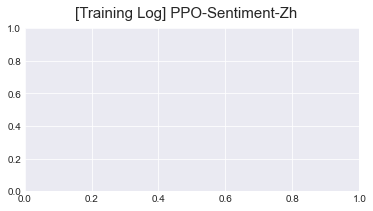

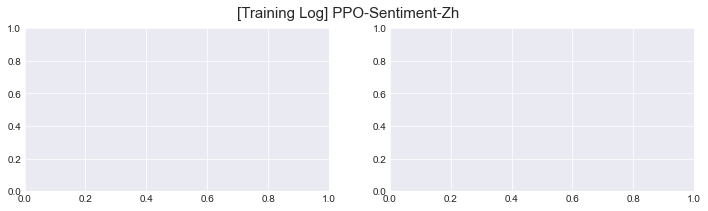

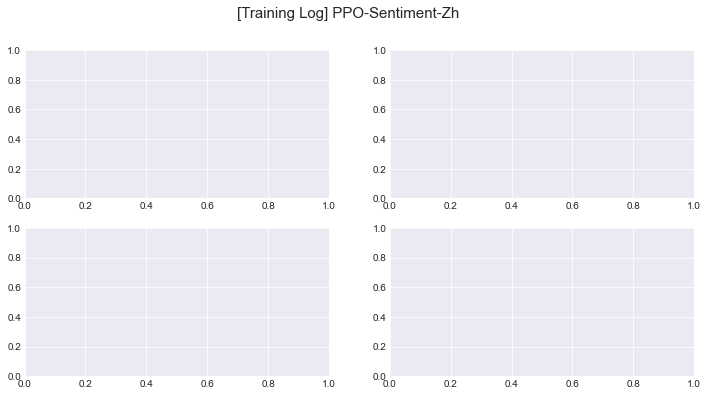

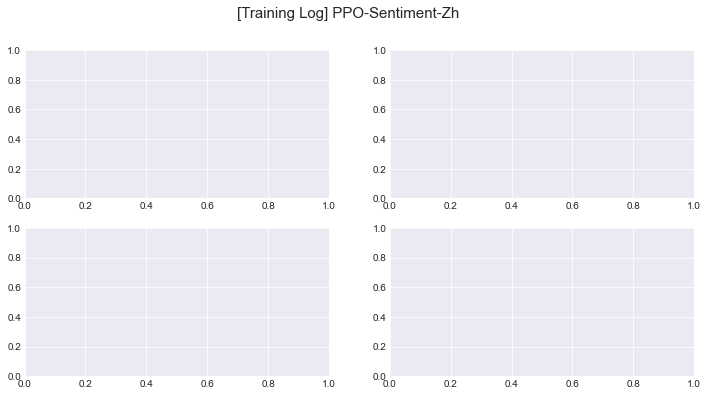

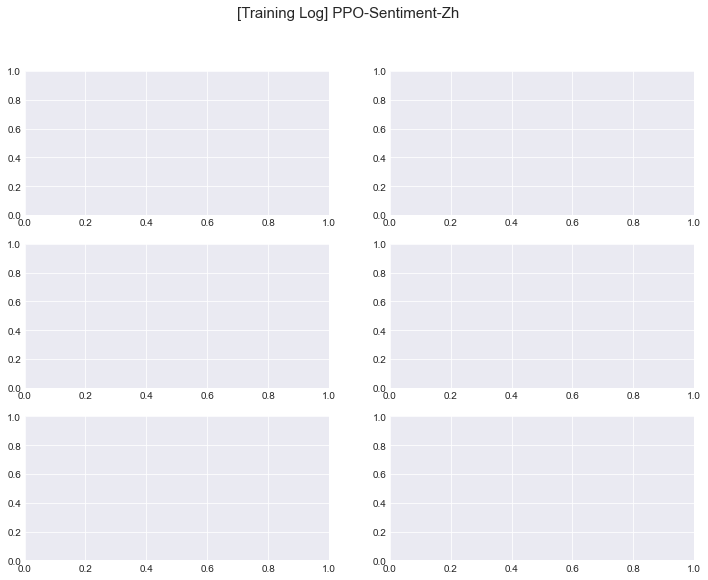

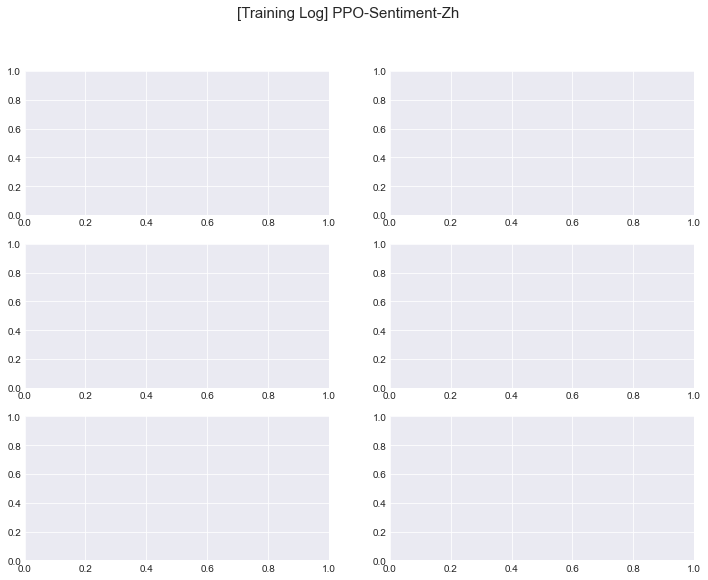

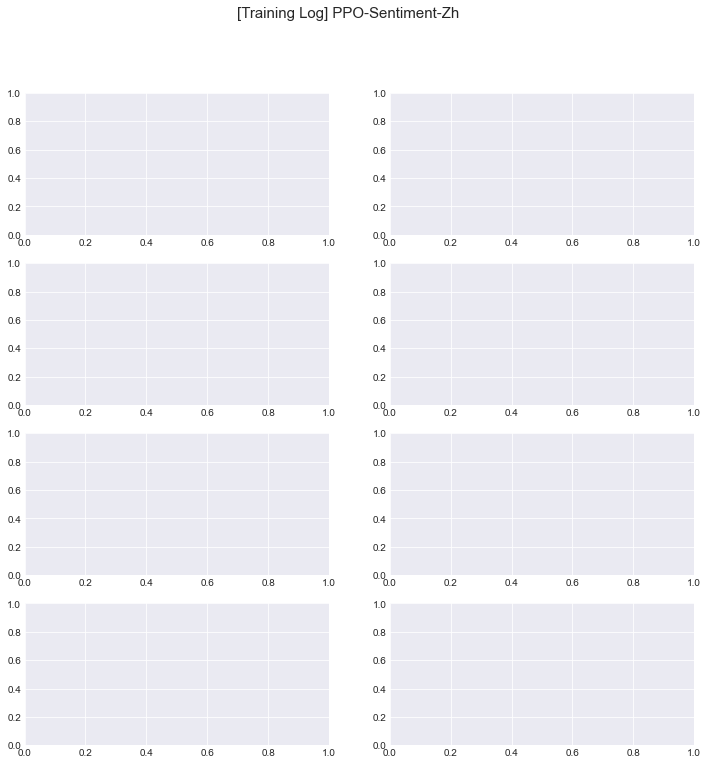

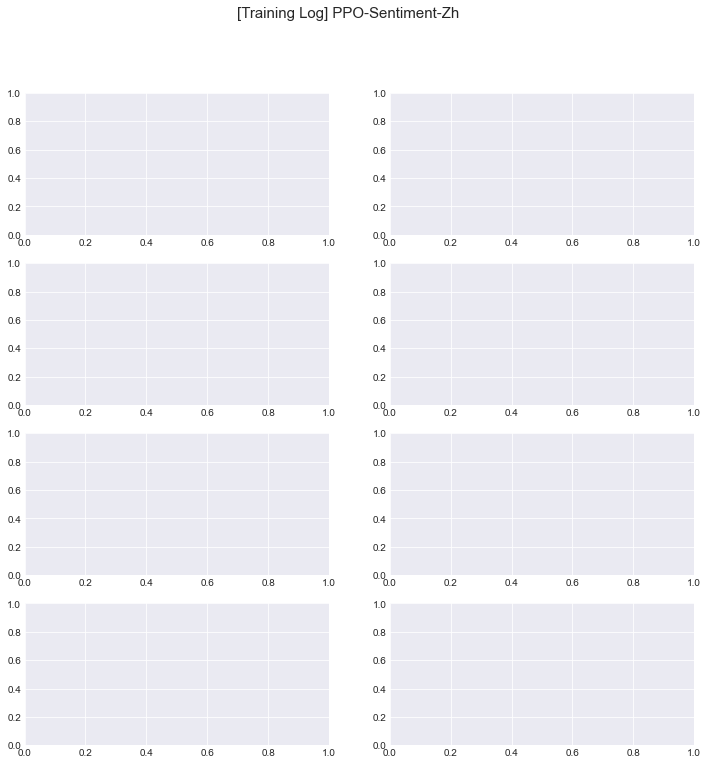

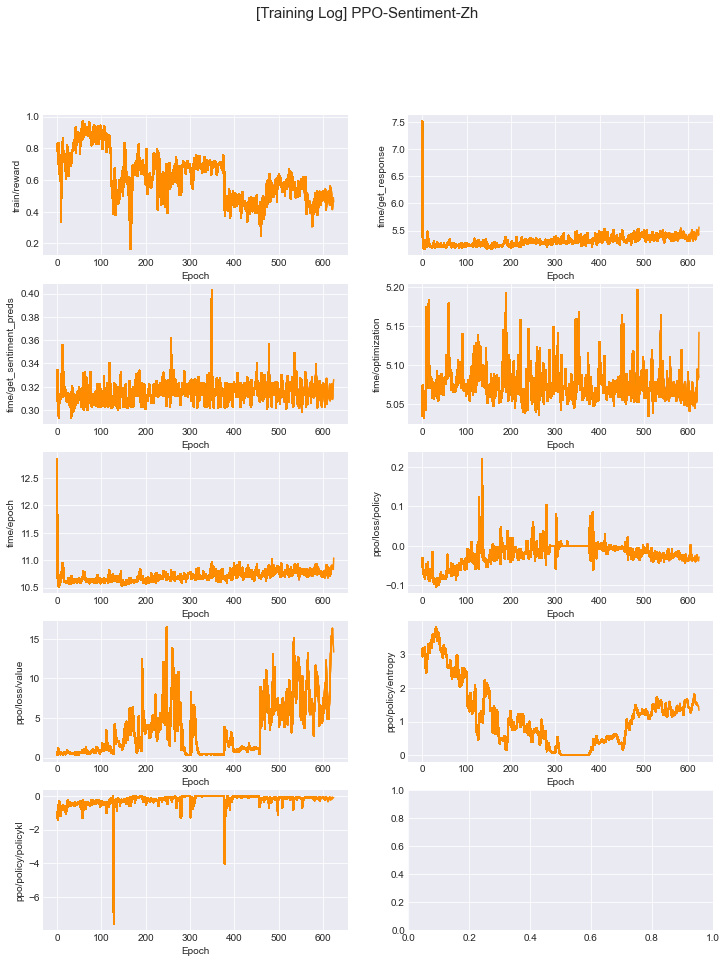

In [10]:
# RL trainer
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, gpt2_tokenizer, **config)
total_ppo_epochs = int(np.ceil(config['steps'] / config['batch_size']))

for epoch in tqdm(range(total_ppo_epochs)):
    logs, timing = dict(), dict()
    t0 = time.time()
    
    batch = {
        'tokens': [],
        'query': []
    }
    
    for _ in range(config['batch_size']):
        random_prompt = random.choice(prompts)
        tokens = gpt2_tokenizer.encode(random_prompt)
        batch['tokens'].append(tokens)
        batch['query'].append(random_prompt)
    query_tensors = [torch.tensor(t).long().to(device) for t in batch['tokens']]
    
    t = time.time()
    response_tensors = []
    for i in range(config['batch_size']):
        gen_len = config['gen_len']
        response = gpt2_model.generate(query_tensors[i].unsqueeze(dim = 0),
                                       max_new_tokens = gen_len, **gen_kwargs)
#         if i == 0:
#             print(f'hoho: response = {response.size()}')
    
        response_tensors.append(response.squeeze()[-gen_len:])
    batch['response'] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]
    timing['time/get_response'] = time.time() - t
    
    t = time.time()
    texts = [q + r for q, r in zip(batch['query'], batch['response'])]
# 计算正向/负向情感得分
    
    pipe_outputs = sentiment_pipe(texts)
#     print(f'hoho: pipe_output = {pipe_outputs}')
    
    rewards = []
    for output in pipe_outputs:
        if output['label'] == 'positive (stars 4 and 5)':
            rewards.append(output['score'])
        elif output['label'] == 'negative (stars 1, 2 and 3)':
            rewards.append(1 - output['score'])
        else:
            raise ValueError(f"错误的推理结果{output['label']}.")
    rewards = torch.tensor(rewards).to(device)
#　将正向情感的得分作为生成得分
    timing['time/get_sentiment_preds'] = time.time() - t
    
    t = time.time()
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
#     print(f'hoho: ppo stats = {stats}')
# PPO update
    timing['time/optimization'] = time.time() - t
    timing['time/epoch'] = time.time() - t0

# logging
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    print(f"epoch {epoch} mean-reward: {logs['env/reward_mean']}")
    
    print('Random Sample 5 text(s) of model output:')
    for i in range(5):
# 随机输出5个生成的结果
        print(f'{i + 1}. {random.choice(texts)}')
    
    writer.add_scalar('train/reward', logs['env/reward_mean'], epoch)
    for k, v in timing.items():
        writer.add_scalar(k, v, epoch)
    writer.add_scalar('ppo/loss/policy', stats['ppo/loss/policy'], epoch)
    writer.add_scalar('ppo/loss/value', stats['ppo/loss/value'], epoch)
    writer.add_scalar('ppo/policy/entropy', stats['ppo/policy/entropy'], epoch)
    writer.add_scalar('ppo/policy/policykl', stats['ppo/policy/policykl'], epoch)
    
    writer.record()
    